<a href="https://colab.research.google.com/github/AmandineLecerfDefer/OC_P6_Classifiez_automatiquement_des_biens_de_consommation/blob/main/P6_02_Pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><u><font color='red'>Projet 6 : Classifiez automatiquement des biens de consommation</font></u><br> <br><font color='red'>Partie 2 : Classification par analyse d'image </font></center> 

# <font color='green'>Setting up the work environment</font>

## <font color='blue'>Library</font>

In [ ]:
# import packages
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras import layers
from keras import Sequential, optimizers
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Dense, Flatten
from keras.models import Model
from keras import models
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import keras
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.spatial import distance
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator
import imutils
import PIL
import cv2
from collections import Counter
import collections
from scipy.stats import variation
from scipy import stats
from scipy.stats.stats import pearsonr
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import missingno as msno
import pickle
#import mss
import os
from os import listdir
import pandas as pd
import numpy as np
import re
import math
from termcolor import colored
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.options.display.width = 0

%matplotlib inline

In [ ]:
# Format & option.
sns.set(rc={'figure.figsize': (16, 9)})
pd.options.display.max_columns = 50

# Style use.
sns.set_style('darkgrid')
plt.style.use('ggplot')

## <font color='blue'>Fonctions</font>

In [ ]:
def clustering(algo, data, true_category, label_true_category, algo_name, file_name=None):

    print(colored("Exécution \n ", 'red'))
    model = algo.fit(data)

    if file_name is None:
        pass
    else :
        # save the model to disk
        filename = file_name
        pickle.dump(model, open(filename, 'wb'))

    label_model = model.labels_

    lines = model.labels_.shape[0]
    print(colored(
        "Nombre de lignes pris en compte pour le clustering {} \n \n".format(lines), 'blue'))


    labels = pd.DataFrame(label_model, columns=['algo_cluster'])

    mylist = list(set(label_model))
    nb_cluster = len(mylist)

    print(colored("Qualité du Clustering \n \n ", 'red'))

    # mean Silhouette Coefficient of all samples
    """    label = model.labels_
    unique, counts = np.unique(label, return_counts=True)
    print(unique)"""

    silhouette = silhouette_score(X=data, labels=model.labels_)
    print(colored('Le coefficient de silhouette moyen est de {} pour la méthode {}.\n \n '.format(
        silhouette, algo_name), 'blue'))

    tot_data_label = pd.concat([true_category, label_true_category, labels], axis=1, names=[
        'category', 'label_category', 'algo_cluster'])
    tot_data_label.reset_index(drop=True)

    # Indice de Rand ajusté.
    ARI = adjusted_rand_score(
        tot_data_label['label_category'], tot_data_label['algo_cluster'])
    print(colored('Le score ARI est de {} pour la méthode {}. \n \n'.format(
        ARI, algo_name), 'blue'))

    print(colored("Visualisation \n \n ", 'red'))

    tsne = TSNE(n_components=2, init="pca")
    X_trans = tsne.fit_transform(data)

    plt.figure(figsize=(10, 10))
    plt.title(
        "TSNE selon les clusters via {}.\n" .format(algo_name), fontsize=30)
    sns.scatterplot(
        X_trans[:, 0],
        X_trans[:, 1],
        hue=model.labels_,
        legend="brief",
        palette=sns.color_palette("husl", nb_cluster),

    )
    sns.set_context("paper", font_scale=1)
    plt.xlabel("tsne1")
    plt.xlabel("tsne2")
    plt.show()

    print("ARI : ", adjusted_rand_score(tot_data_label['label_category'], tot_data_label['algo_cluster']))
    print('\n \n')


    from matplotlib import rcParams
    rcParams['axes.titlepad'] = 40

    values = tot_data_label['algo_cluster'].value_counts()
    labels = tot_data_label['algo_cluster'].value_counts().index

    #color = ['gold', 'pink', 'grey', 'orange', 'green', 'blue', 'purple', 'yellow', 'red', 'brown', 'violet']
    #colors = color[:nb_cluster]

    # Plot
    from matplotlib import cm
    cs = cm.Set2(np.arange(nb_cluster))

    plt.figure(figsize=(10, 10))
    plt.pie(values, labels=labels, colors=cs,
            autopct='%.2f%%', shadow=True, textprops={'fontsize': 24})

    plt.title(
        "Répartition des produits entre les différentes catégories déterminées par l'algorithme {}" .format(algo_name), fontsize=30)

    plt.axis('equal')
    plt.tight_layout()

    plt.show()

    return silhouette, ARI, tot_data_label

In [ ]:
def classification(best_param, X_train, y_train, X_test, y_test, algo_name, file_name=None):
    print(colored("Exécution \n ", 'red'))
    
    model = best_param.fit(X_train, y_train)
    if file_name is None:
        pass
    else :
        # save the model to disk
        filename = file_name
        pickle.dump(model, open(filename, 'wb'))


    prediction = best_param.predict(X_test)
    df = pd.DataFrame(prediction, columns=['prediction'])
    resume_class = pd.concat([y_test, df], axis=1)

    print(colored("Qualité de la classification \n \n ", 'red'))
    accuracy = accuracy_score(y_test, prediction)
    print(colored('L\'accuracy score est de {} pour la méthode {}.\n \n '.format(
        accuracy, algo_name), 'blue'))

    precision = precision_score(y_test, prediction, average='weighted')
    print(colored('Le score de précision est de {} pour la méthode {}.\n \n '.format(
        precision, algo_name), 'blue'))

    recall = recall_score(y_test, prediction, average='weighted')
    print(colored('Le score recall est de {} pour la méthode {}.\n \n '.format(
        recall, algo_name), 'blue'))

    f1 = f1_score(y_test, prediction, average='weighted')
    print(colored('Le score f1 est de {} pour la méthode {}.\n \n '.format(
        f1, algo_name), 'blue'))

    le = preprocessing.LabelEncoder()
    resume_class['label_cat_reel'] = le.fit_transform(
        np.array(resume_class['product_category']))
    resume_class['label_cat_predit'] = le.transform(
        np.array(resume_class['prediction']))

    print(colored("Visualisation \n \n ", 'red'))
    plt.figure(figsize=(10, 10))
    plt.title('Répartition des catégories après classification par la méthode {}.\n \n '.format(
        algo_name), fontsize=18, fontweight="bold")
    sns.distplot(resume_class['label_cat_reel'], bins=20, rug=True)
    sns.distplot(resume_class['label_cat_predit'], bins=20, rug=True)
    plt.xlabel("Catégories")
    plt.legend(['reel', 'prediction'])

    from matplotlib import cm
    fig = plt.figure(figsize=(30, 15))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    nb_label_real = resume_class['product_category'].nunique()
    cs_nb_label_real = cm.Set2(np.arange(nb_label_real))
    nb_label_predit = resume_class['prediction'].nunique()
    cs_nb_label_predit = cm.Set2(np.arange(nb_label_predit))

    ax1 = resume_class.groupby('product_category').count().plot(kind='pie',
                                                                y='label_cat_reel',
                                                                ax=ax1,
                                                                legend=False,
                                                                shadow=True,
                                                                startangle=0,
                                                                autopct='%1.1f%%',
                                                                textprops={
                                                                    'fontsize': 26},
                                                                colors=cs_nb_label_real)
    ax1.axis('equal')
    ax1.set_xlabel("classes réelles", fontsize=22)
    ax1.set_ylabel(" ")

    ax2 = resume_class.groupby('prediction').count().plot(kind='pie',
                                                          y='label_cat_predit',
                                                          ax=ax2,
                                                          legend=False,
                                                          shadow=True,
                                                          startangle=0,
                                                          autopct='%1.1f%%',
                                                          textprops={
                                                              'fontsize': 26},
                                                          colors=cs_nb_label_predit)
    ax2.axis('equal')
    ax2.set_xlabel("classes prédites par {}" .format(
        algo_name), fontsize=22)
    ax2.set_ylabel(" ")

    plt.suptitle('Répartition des produits (test data) entre les différentes catégories déterminées',
                 fontsize=30)

    plt.subplots_adjust(wspace=1.5)

    plt.show()

    cf_matrix = confusion_matrix(
        resume_class["product_category"], resume_class["prediction"], normalize='true')
    plt.figure(figsize=(18, 12))
    plt.title('Matrice de confusion', size=20, weight='bold')
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(cf_matrix, annot=True,
                fmt='.2%', cmap='BuPu',
                annot_kws={"size": 15, 'weight': 'bold'})
    plt.ylabel("Vraie catégorie", weight='bold', size=20)
    plt.xlabel('Prediction', weight='bold', size=17)
    plt.show()

    return accuracy, precision, recall, f1, resume_class

# <font color='green'>Importation csv + nettoyage</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd / content/drive/My\ Drive/Data_projet_OC
!ls

data = pd.read_csv(
    '/content/drive/MyDrive/Data_projet_OC/Flipkart/flipkart_com-ecommerce_sample_1050.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/ content/drive/My Drive/Data_projet_OC'
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt

In [ ]:
"""data = pd.read_csv(
    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC"
    "/WORK-projet6/Data/Flipkart/flipkart_com-ecommerce_sample_1050.csv")"""

'data = pd.read_csv(\n    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC"\n    "/WORK-projet6/Data/Flipkart/flipkart_com-ecommerce_sample_1050.csv")'

In [ ]:
def remove_columns(dataframe):
    new = pd.DataFrame()
    columns_to_keep = [
        'uniq_id', 'product_name', 'image', 'product_category_tree']

    for column in columns_to_keep:
        try:
            new[column] = dataframe[column]
        except:
            print('...colonne non présente : ', column)
            print('\n')
    print("All selected columns have been kept from the dataset")
    return new

In [ ]:
data_clean = remove_columns(data)

All selected columns have been kept from the dataset


In [ ]:
def recover_root_cat(column):
    categorie = column.split('["')[1].split('"]')[0]
    cat = categorie.split(' >> ')[0]
    return cat

In [ ]:
data_clean['product_category'] = data_clean['product_category_tree'].apply(
    recover_root_cat)
data_clean['product_category'] = data_clean['product_category'].str.replace(
    ' ', '_')
data_clean['product_category'] = data_clean['product_category'].str.replace(
    '&', 'and')
data_clean['product_category'] = data_clean['product_category'].str.lower()

# Encodage des catégories trouvées manuellement
le = preprocessing.LabelEncoder()
data_clean['label_product_category'] = le.fit_transform(
    np.array(data_clean['product_category']))

In [ ]:
data_clean['product_category'].unique()

array(['home_furnishing', 'baby_care', 'watches',
       'home_decor_and_festive_needs', 'kitchen_and_dining',
       'beauty_and_personal_care', 'computers'], dtype=object)

In [ ]:
data_clean.head()

uniq_id  \
0  55b85ea15a1536d46b7190ad6fff8ce7   
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                               product_category_tree product_category  \
0  ["Home Furnishing >> Curtains & Accessories >>...  home_furnishing   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        baby_care   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...        baby_care   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  home_furnishing   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  home_furnishing   

   label_product_category  
0                       4  
1                       0  
2                       0  
3                       4  
4                       4

In [ ]:
# correspondance
data_clean.loc[data_clean['label_product_category'] == 0]
print('Le label 0 correspond à la catégorie baby_care')
data_clean.loc[data_clean['label_product_category'] == 1]
print('Le label 1 correspond à la catégorie beauty_and_personal_care')
data_clean.loc[data_clean['label_product_category'] == 2]
print('Le label 2 correspond à la catégorie computers')
data_clean.loc[data_clean['label_product_category'] == 3]
print('Le label 3 correspond à la catégorie home_decor_&_festive_needs')
data_clean.loc[data_clean['label_product_category'] == 4]
print('Le label 4 correspond à la catégorie home_furnishing')
data_clean.loc[data_clean['label_product_category'] == 5]
print('Le label 5 correspond à la catégorie kitchen_&_dining')
data_clean.loc[data_clean['label_product_category'] == 6]
print('Le label 6 correspond à la catégorie watches')

Le label 0 correspond à la catégorie baby_care
Le label 1 correspond à la catégorie beauty_and_personal_care
Le label 2 correspond à la catégorie computers
Le label 3 correspond à la catégorie home_decor_&_festive_needs
Le label 4 correspond à la catégorie home_furnishing
Le label 5 correspond à la catégorie kitchen_&_dining
Le label 6 correspond à la catégorie watches


# <font color='green'>Exemple de preprocessing sur une image</font>

Pillow n'étant plus mis à jour, je décide d'utiliser la bibliothèque opencv-python et en particulier cv2 pour le traitement d'image.

Le preprocessing sur les images s'articule comme suit:

- Chargement des images en niveau de gris
- amélioration luminosité
- amélioration contraste
- débruitage
- Application d'un filtre médian
- Application d'un filtre Gaussien



Extraction des descripteurs de l'image par l'algorithme ORB.

ORB est aussi performant que SIFT pour la détection des caractéristiques (et est meilleur que SURF) tout en étant presque deux ordres de grandeur plus rapide.

In [ ]:
from PIL import Image

# Charger l'image
"""img = Image.open(
    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/cheval.png")"""


img = Image.open(
    "/content/drive/MyDrive/Data_projet_OC/cheval.png")


# Afficher l'image chargée
img.show()

# Récupérer et afficher la taille de l'image (en pixels)
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

Largeur : 800 px, hauteur : 533 px


Ce résultat signifie que l'image analogique a été découpée en 800 pixels sur la largeur et 533 pixels sur la hauteur pendant l'échantillonnage.

Shape of the image (738408,)


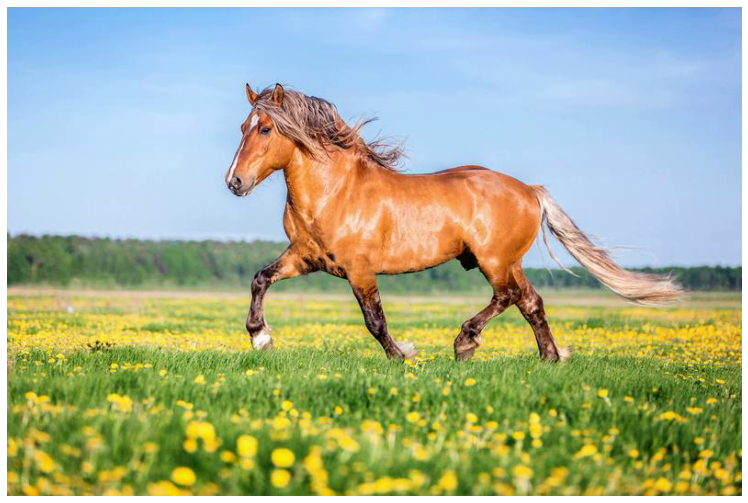

In [ ]:
"""data = open(
    '/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/cheval.png', 'rb').read()"""

data = open(
    '/content/drive/MyDrive/Data_projet_OC/cheval.png', 'rb').read()

image_array_horse = np.asarray(bytearray(data), dtype="uint8")
print(f'Shape of the image {image_array_horse.shape}')
image_horse = cv2.imdecode(image_array_horse, cv2.IMREAD_COLOR)
plt.axis('off')
# opencv if BGR color, matplotlib usr RGB so we need to switch
plt.imshow(cv2.cvtColor(image_horse, cv2.COLOR_BGR2RGB))
plt.show()

## <font color='blue'>Niveau de gris</font>

(40, 40, 3)
(40, 40)
255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  
255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  
255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  
255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  
255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  255  

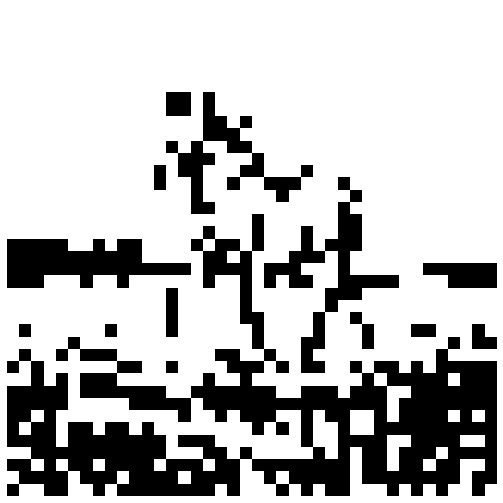

In [ ]:
# Transformation de l'image de 3D en 1D
res = cv2.resize(image_horse, dsize=(40, 40), interpolation=cv2.INTER_CUBIC)
print(res.shape)
res = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)  # TO 3D to 1D
print(res.shape)
# séparation en blanc et noir, côté gauche = noir, côté droit = blanc
res = cv2.threshold(res, 127, 255, cv2.THRESH_BINARY)[1]
# Si la valeur du pixel est inférieure au seuil, elle est fixée à 0, sinon elle est fixée à une valeur maximale.
d = res
for row in range(0, 40):
    for col in range(0, 40):
        print('%03d ' % d[row][col], end=' ')
    print('')
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

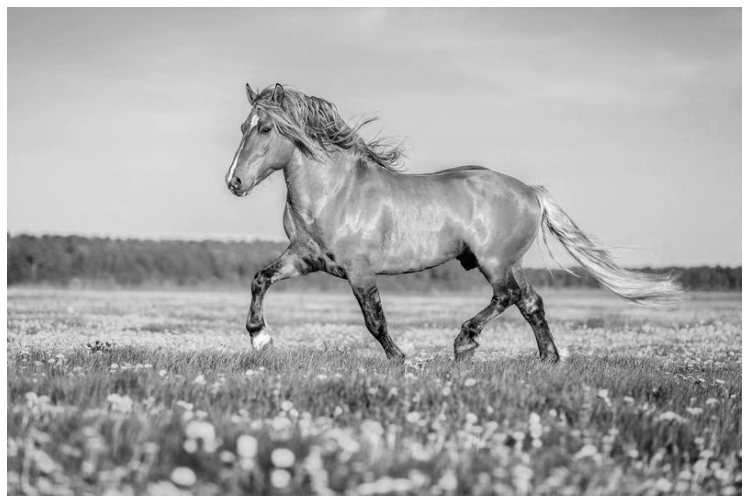

In [ ]:
# Ctransformation de l'image en noir et blanc
img_bw = cv2.imdecode(image_array_horse, cv2.IMREAD_GRAYSCALE)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_bw, cv2.COLOR_BGR2RGB))

In [ ]:
"""(thresh, img_bw) = cv2.threshold(img_bw, 127, 255, cv2.THRESH_BINARY)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_bw, cv2.COLOR_BGR2RGB))"""

"(thresh, img_bw) = cv2.threshold(img_bw, 127, 255, cv2.THRESH_BINARY)\nplt.axis('off')\nplt.imshow(cv2.cvtColor(img_bw, cv2.COLOR_BGR2RGB))"

Le premier argument est l'image source, qui doit être une image en niveaux de gris. Le deuxième argument est la valeur de seuil qui est utilisée pour classer les valeurs de pixels. Le troisième argument est la valeur maximale qui est attribuée aux valeurs de pixels dépassant le seuil.

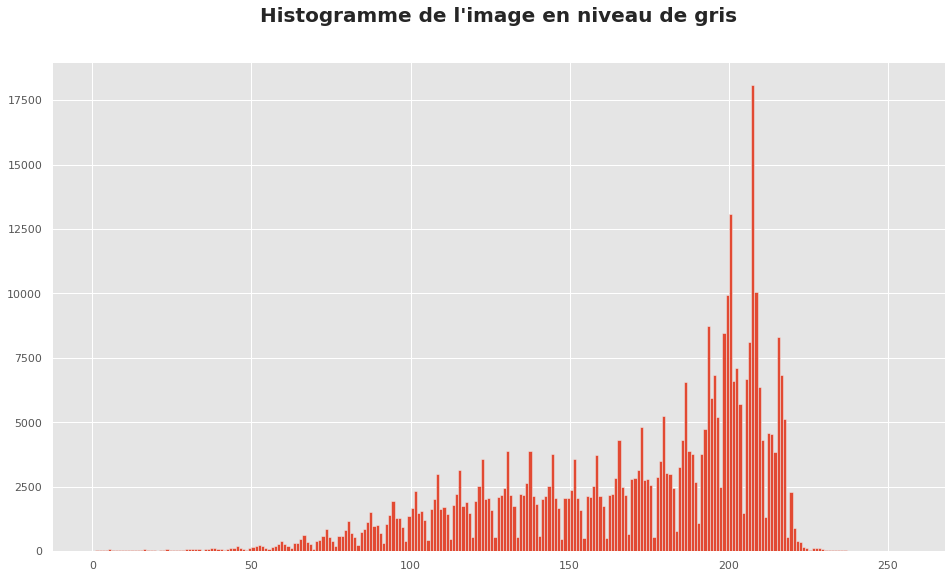

In [ ]:
plt.figure(figsize=(16, 9))
plt.title("Histogramme de l'image en niveau de gris", weight='bold', size=20)
n, bins, patches = plt.hist(img_bw.flatten(), bins=range(256))
plt.show()

à gauche se situent les pixels noirs, à droite les pixels blancs, et au milieu, toutes les nuances de gris

## <font color='blue'>amélioration luminosité</font>

étirement d'histogramme = corriger les défauts liés à l’exposition d'une image = l'objectif est d'étendre les valeurs des niveaux de gris de l'image mal exposée, majoritairement réparties dans un sous intervalle [Imin,Imax]⊂[0,255].

In [ ]:
def autocontrast_func(img, cutoff=0):
    '''
        same output as PIL.ImageOps.autocontrast
    '''
    n_bins = 256

    def tune_channel(ch):
        n = ch.size
        cut = cutoff * n // 100
        if cut == 0:
            high, low = ch.max(), ch.min()
        else:
            hist = cv2.calcHist([ch], [0], None, [n_bins], [0, n_bins])
            low = np.argwhere(np.cumsum(hist) > cut)
            low = 0 if low.shape[0] == 0 else low[0]
            high = np.argwhere(np.cumsum(hist[::-1]) > cut)
            high = n_bins - 1 if high.shape[0] == 0 else n_bins - 1 - high[0]
        if high <= low:
            table = np.arange(n_bins)
        else:
            scale = (n_bins - 1) / (high - low)
            offset = -low * scale
            table = np.arange(n_bins) * scale + offset
            table[table < 0] = 0
            table[table > n_bins - 1] = n_bins - 1
        table = table.clip(0, 255).astype(np.uint8)
        return table[ch]
    channels = [tune_channel(ch) for ch in cv2.split(img)]
    out = cv2.merge(channels)
    return out

In [ ]:
img_et = autocontrast_func(img_bw)

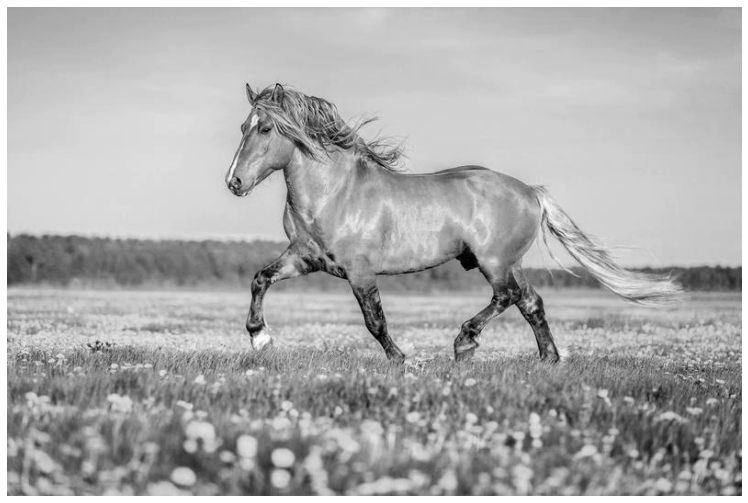

In [ ]:
plt.axis('off')
plt.imshow(cv2.cvtColor(img_et, cv2.COLOR_BGR2RGB))

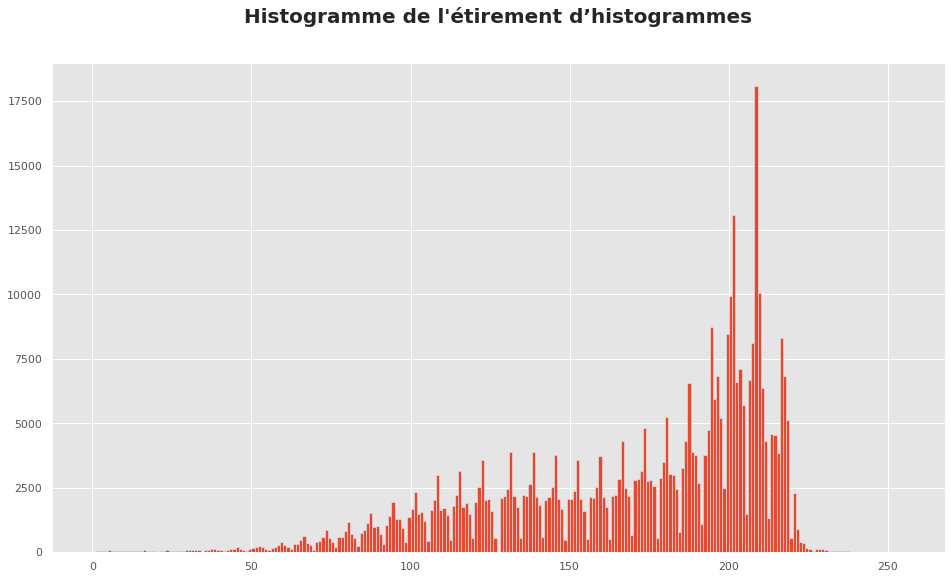

In [ ]:
plt.figure(figsize=(16, 9))
plt.title("Histogramme de l'étirement d’histogrammes", weight='bold', size=20)
n, bins, patches = plt.hist(img_et.flatten(), bins=range(256))
plt.show()

les pixels se répartissent bien dans tout l'intervalle [0,255] et l'image présente une meilleure luminosité

## <font color='blue'>amélioration du contrast </font>

égalisation d'histogrammes = amélioration du contraste de l'image = réajuster le contraste d'une image = harmoniser la distribution des niveaux de gris de l'image, de sorte que chaque niveau de l'histogramme contienne idéalement le même nombre de pixels. Concrètement, on essaye d'aplatir au maximum l'histogramme original.

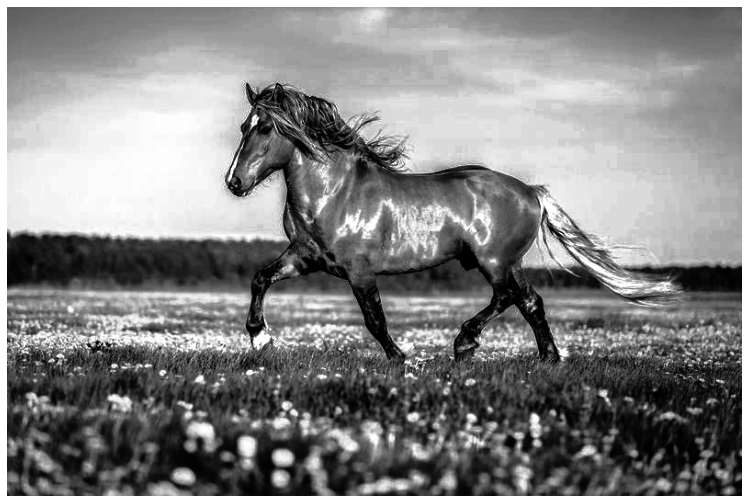

In [ ]:
image = cv2.equalizeHist(img_et)   # equalize image histogram
plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

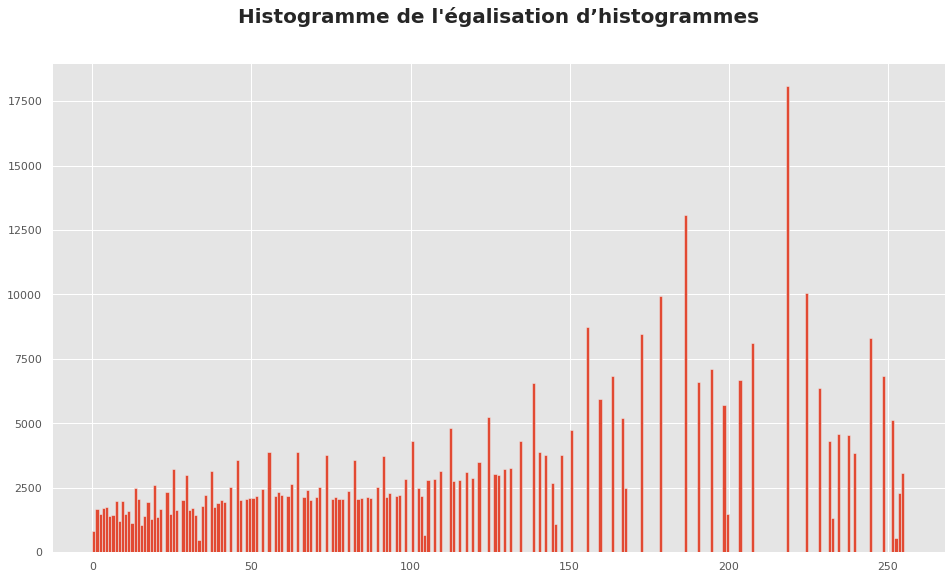

In [ ]:
plt.figure(figsize=(16, 9))
plt.title("Histogramme de l'égalisation d’histogrammes",
          weight='bold', size=20)
n, bins, patches = plt.hist(image.flatten(), bins=range(256))
plt.show()

L'image est plus contrastée et son histogramme confirme que la distribution de ses niveaux de gris est plus uniforme.

## <font color='blue'>Élimination du bruit : Débruitage = lissage</font>

lissage par moyennage = remplacer la valeur de chaque pixel par l'intensité moyenne de son voisinage

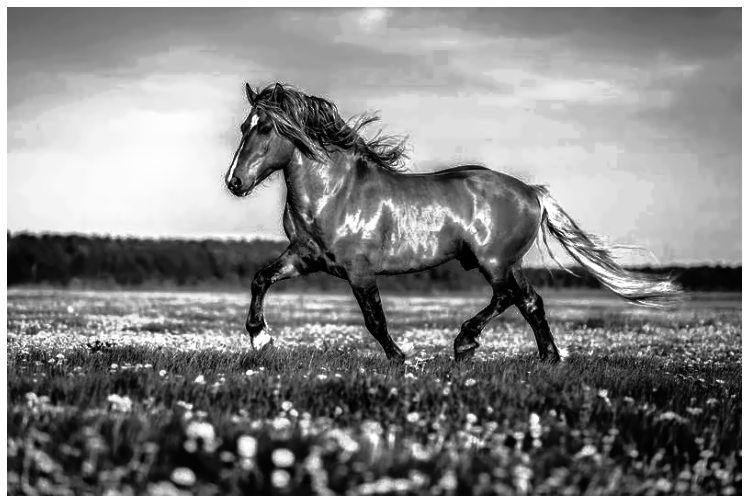

In [ ]:
image_denoise = cv2.fastNlMeansDenoising(image)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_denoise, cv2.COLOR_BGR2RGB))

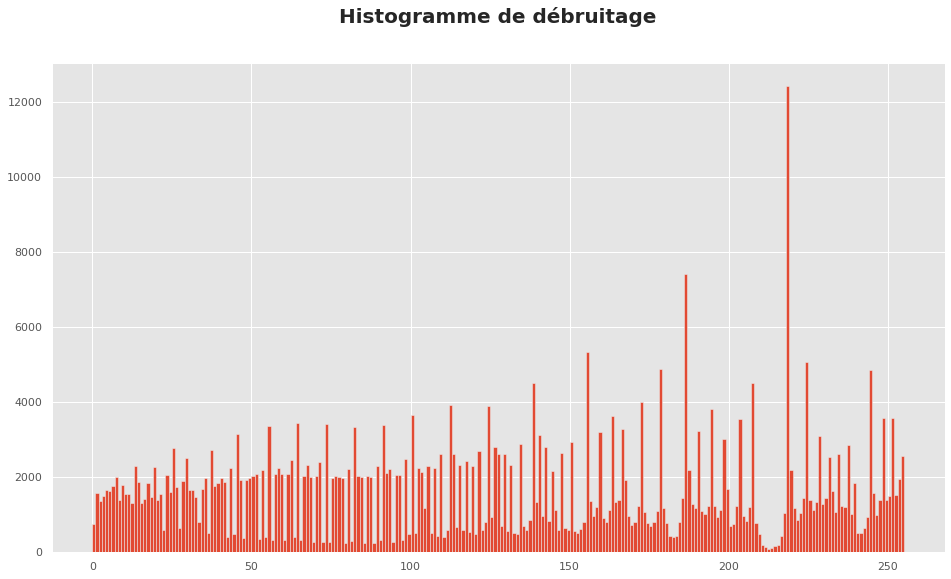

In [ ]:
plt.figure(figsize=(16, 9))
plt.title("Histogramme de débruitage", weight='bold', size=20)
n, bins, patches = plt.hist(image_denoise.flatten(), bins=range(256))
plt.show()

Le bruit est bien atténué, mais en contrepartie, l'image est devenue floue

## <font color='blue'>coeficient de convolution</font>

[[0 0 0]
 [0 1 0]
 [0 0 0]]


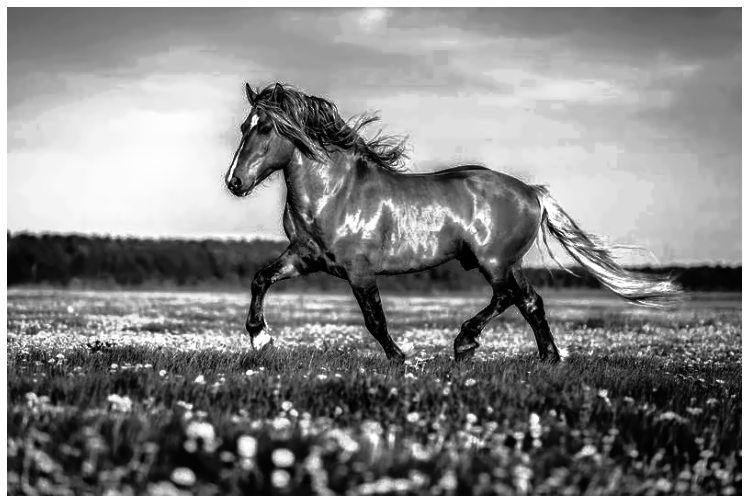

In [ ]:
# defining an identity kernel, will change nothing because each pixel will remain with is value
kernel = np.matrix([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
print(kernel)
img_1 = cv2.filter2D(image_denoise, -1, kernel)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

[[-10   0  10]
 [-10   0  10]
 [-10   0  10]]


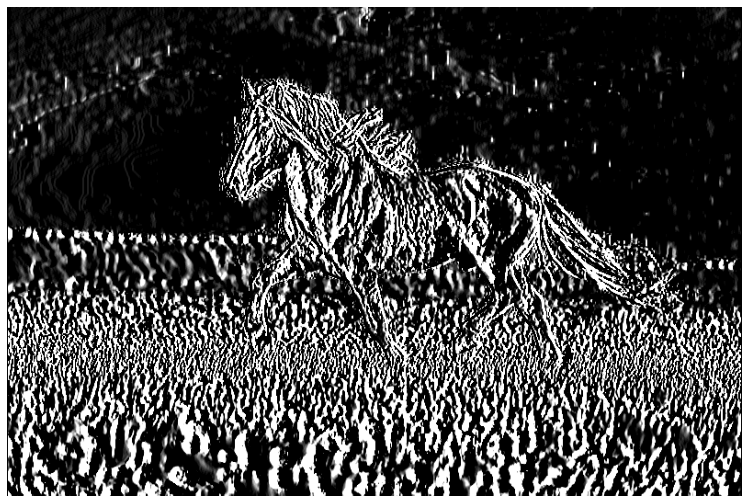

In [ ]:
# defining a vertical edge detection kernel
kernel = np.matrix([[-10, 0, 10], [-10, 0, 10], [-10, 0, 10]])
print(kernel)
img_1 = cv2.filter2D(image_denoise, -1, kernel)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

[[ 10  10  10]
 [  0   0   0]
 [-10 -10 -10]]


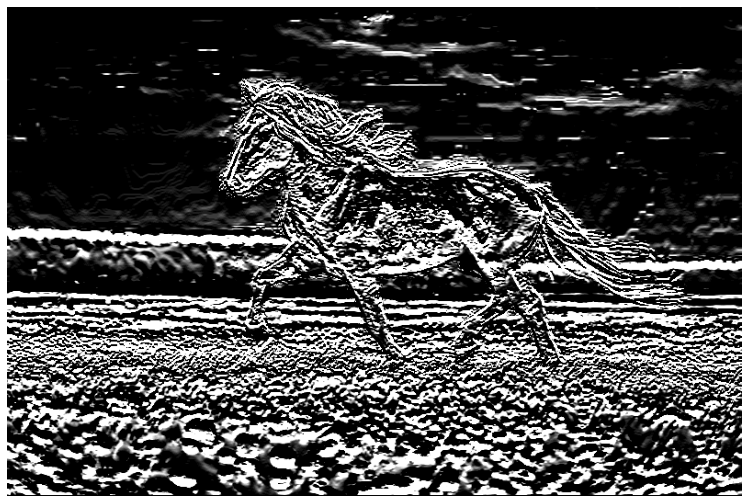

In [ ]:
# defining an horizontal edge detection kernel
kernel = np.matrix([[10, 10, 10], [0, 0, 0], [-10, -10, -10]])
print(kernel)
img_1 = cv2.filter2D(image_denoise, -1, kernel)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

In [ ]:
from scipy.ndimage import convolve
m = [[-10, 0, 10], [-10, 0, 10], [-10, 0, 10]]
k = [[10, 10, 10], [0, 0, 0], [-10, -10, -10]]

c = convolve(m, k, mode='constant', cval=0.0)
print('Matrix')
print('\n'.join([''.join(['{:4}'.format(item) for item in row])
      for row in m]))

print('Kernel')
print('\n'.join([''.join(['{:4}'.format(item) for item in row])
      for row in k]))

print('Convolution')
print('\n'.join([''.join(['{:4}'.format(item) for item in row])
      for row in c]))

Matrix
 -10   0  10
 -10   0  10
 -10   0  10
Kernel
  10  10  10
   0   0   0
 -10 -10 -10
Convolution
-100   0 100
   0   0   0
 100   0-100


(3, 3)


<function matplotlib.pyplot.show>

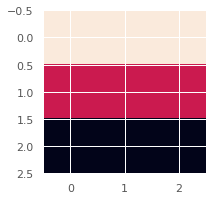

In [ ]:
k2 = np.matrix(k)
f_min, f_max = k2.min(), k2.max()
filter = (k2 - f_min) / (f_max - f_min)
print(k2.shape)
fig = plt.figure(figsize=(3, 3))
plt.imshow(k2)
plt.show

## <font color='blue'>Filtre médian</font>

il s'agit de filtres dont le fonctionnement ne peut être défini comme un produit de convolution = la valeur de chaque pixel est remplacée par la médiane (et non la moyenne) de son voisinage

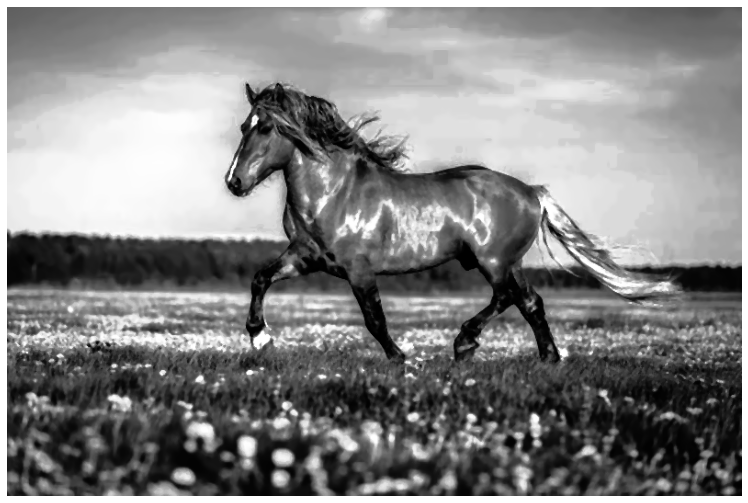

In [ ]:
image_filtre_1 = cv2.medianBlur(image_denoise, 3)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_filtre_1, cv2.COLOR_BGR2RGB))

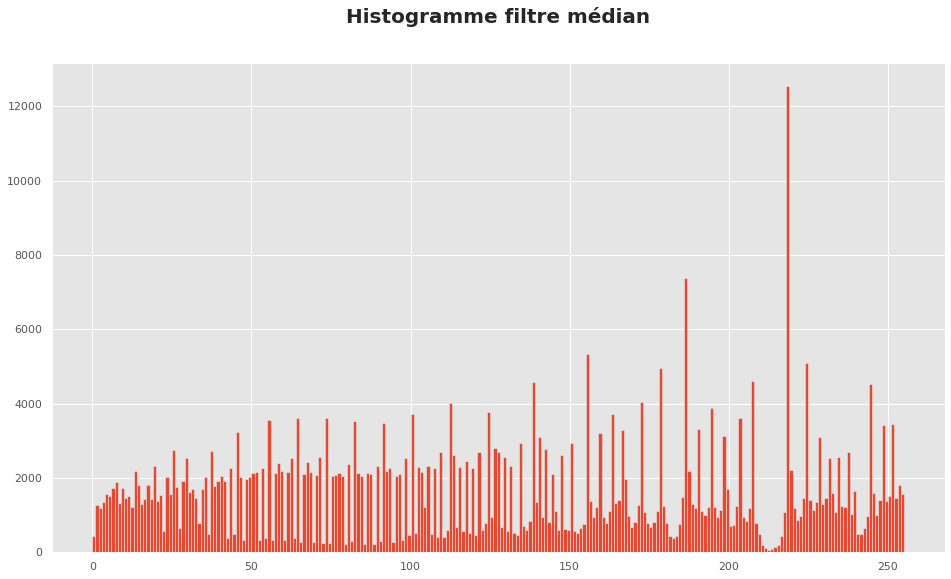

In [ ]:
plt.figure(figsize=(16, 9))
plt.title("Histogramme filtre médian", weight='bold', size=20)
n, bins, patches = plt.hist(image_filtre_1.flatten(), bins=range(256))
plt.show()

## <font color='blue'>filtre gausien</font>

Un filtre gaussien est un filtre linéaire dont les éléments du noyau de convolution sont déterminés selon la densité d'une loi gaussienne = c'est un filtre basé sur la moyenne : chaque pixel est corrigé avec une moyenne dont les poids ont des valeurs différentes

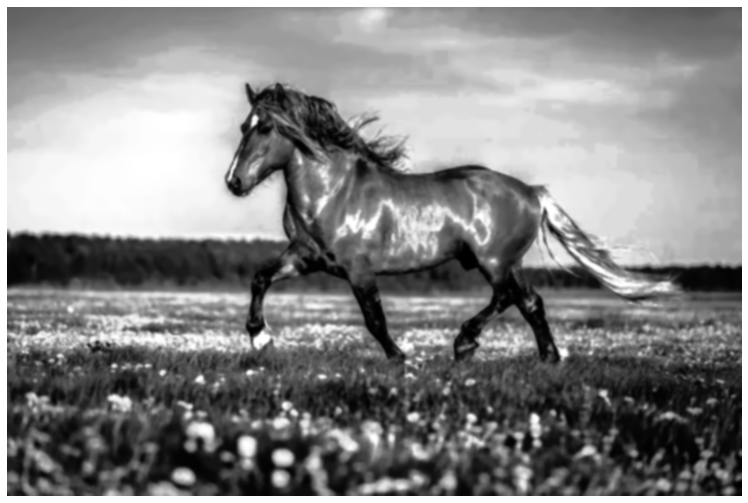

In [ ]:
image_filtre_2 = cv2.GaussianBlur(image_filtre_1, (5, 5), 1)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_filtre_2, cv2.COLOR_BGR2RGB))

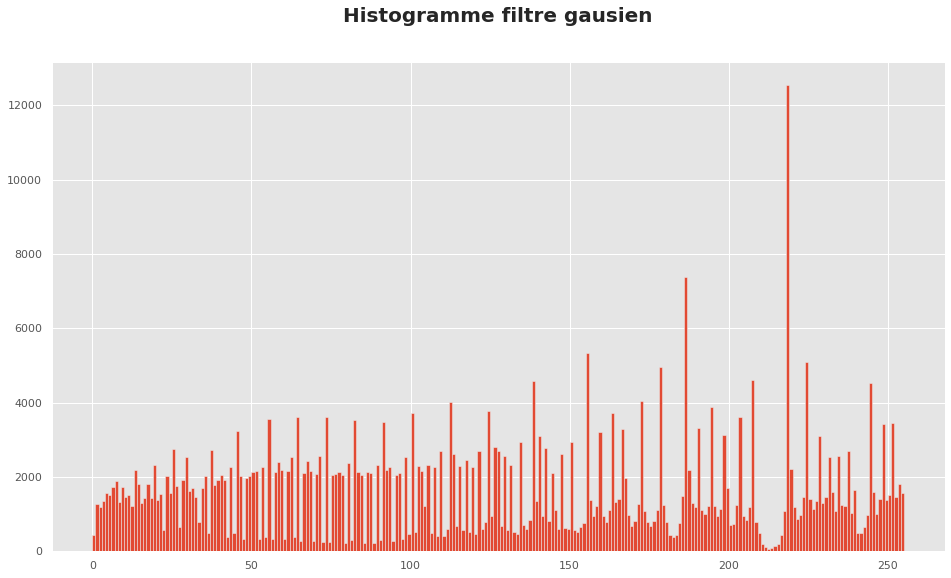

In [ ]:
plt.figure(figsize=(16, 9))
plt.title("Histogramme filtre gausien", weight='bold', size=20)
n, bins, patches = plt.hist(image_filtre_1.flatten(), bins=range(256))
plt.show()

## <font color='blue'>Recherche de Features</font>

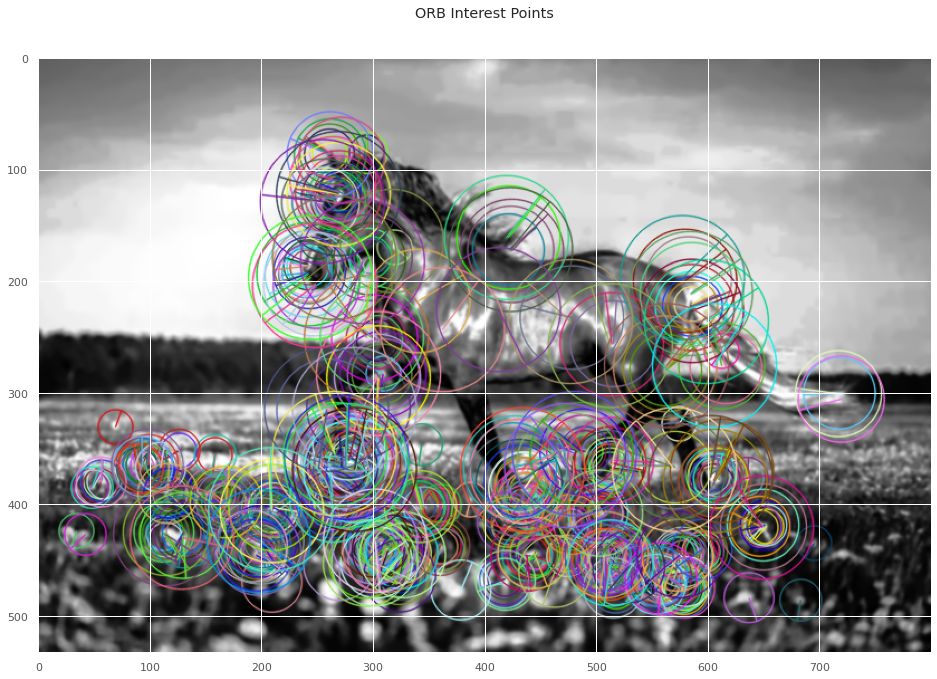

In [ ]:
# OpenCV 3 backward incompatibility: Do not create a detector with `cv2.ORB()`.
orb = cv2.ORB_create()
key_points, description = orb.detectAndCompute(image_filtre_2, None)
img_building_keypoints = cv2.drawKeypoints(image_filtre_2,
                                           key_points,
                                           image_filtre_2,
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)  # Draw circles.
plt.figure(figsize=(16, 16))
plt.title('ORB Interest Points')
plt.imshow(img_building_keypoints)
plt.show()

# <font color='green'>Travail sur toutes les images</font>

## <font color='blue'> Pré-traitement des images + Bag of Visual Words(BoVW) grâce au webinar openclassroom</font>

L'objectif final est d'avoir un training et un testing set à partir des images.

Un Bag of Visual Word est réalisé à l'aide de l'algorithme ORB. On cherchera à optimiser le nombre de Visual Word créé en utilisant un algorithme de classification k-means.


BoVW est une technique couramment utilisée dans la classification des images. L'idée derrière cette technique est similaire à celle du sac de mots du langage naturel, mais dans cette technique, nous utilisons les caractéristiques de l'image comme des mots.

1) Nous extrayons les caractéristiques locales de plusieurs images en utilisant SIFT ou ORB.

2) Quantifier l'espace des caractéristiques. Effectuer cette opération via des algorithmes de clustering tel que K-means. Les points centraux, que nous obtenons de l'algorithme de clustering, sont nos mots visuels.

3) Extraire les caractéristiques locales et les comparer aux mots visuels afin de créer des histogrammes pour chaque image, à la fois pour l'ensemble de données de test et d'entraînement.

### <font color='olive'>Créations des descripteurs de chaque image</font> 

- Pour chaque image passage en gris et equalisation

- création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image

- création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisée pour créer les clusters de descripteurs

ORB : ORB est fondamentalement une fusion du détecteur de keyspoints FAST et du descripteur BRIEF avec de nombreuses modifications pour améliorer les performances. Il utilise d'abord la FAST pour trouver les points clés, puis applique la mesure des coins de Harris pour trouver les N meilleurs points parmi eux. 

In [ ]:
"""# Liste contenant les descripteurs.
sift_keypoints = []
path = "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/Flipkart/Images/"

#path = "/content/drive/MyDrive/Data_projet_OC/Flipkart/Images/

# Extraction des descripteurs par orb
sift = cv2.SIFT_create()
    
for image_num in range(len(list_name_pictures)) :
    if image_num%100 == 0 : print(image_num)
    image_bw = cv2.imread(path+list_name_pictures[image_num],0) # convert in grey    
    image_bw_resized = imutils.resize(image_bw, width=400)# convert all picture to the same size

    # Amélioration luminosité
    #img_lum = autocontrast_func(image_bw_resized)

    # Amélioration contraste
    #image_cont = cv2.equalizeHist(img_lum)   # égalisation histogramme
    image_cont = cv2.equalizeHist(image_bw_resized)   # égalisation histogramme


    # Débruitage
    image_denoise = cv2.fastNlMeansDenoising(image_cont)

    # Filtre médian
    image_filtre_1 = cv2.medianBlur(image_denoise, 3)
    #image_filtre_1 = cv2.medianBlur(image_cont, 3)


    # filtre gausien
    image_filtre_2 = cv2.GaussianBlur(image_filtre_1, (5, 5), 1)  
    
    # Keypoints & Descripteurs.
    key_points, description = sift.detectAndCompute(image_filtre_2, None)
    #img = cv2.drawKeypoints(i,kp,i)

    sift_keypoints.append(description)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print("\n \n Nombre de descripteurs : ", sift_keypoints_all.shape[0]) """

'# Liste contenant les descripteurs.\nsift_keypoints = []\npath = "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/Flipkart/Images/"\n\n#path = "/content/drive/MyDrive/Data_projet_OC/Flipkart/Images/\n\n# Extraction des descripteurs par orb\nsift = cv2.SIFT_create()\n    \nfor image_num in range(len(list_name_pictures)) :\n    if image_num%100 == 0 : print(image_num)\n    image_bw = cv2.imread(path+list_name_pictures[image_num],0) # convert in grey    \n    image_bw_resized = imutils.resize(image_bw, width=400)# convert all picture to the same size\n\n    # Amélioration luminosité\n    #img_lum = autocontrast_func(image_bw_resized)\n\n    # Amélioration contraste\n    #image_cont = cv2.equalizeHist(img_lum)   # égalisation histogramme\n    image_cont = cv2.equalizeHist(image_bw_resized)   # égalisation histogramme\n\n\n    # Débruitage\n    image_denoise = cv2.fastNlMeansDenoising(image_cont)\n\n    # Filtre médian\n    image_filtre_1 = cv2.medianBlur(i

https://www.pyimagesearch.com/2015/02/02/just-open-sourced-personal-imutils-package-series-opencv-convenience-functions/

In [ ]:
# Liste contenant les descripteurs.
sift_keypoints = []
"""path = "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/Flipkart/Images"""

folder = "/content/drive/MyDrive/Data_projet_OC/Flipkart/Images"

# Extraction des descripteurs par orb
orb = cv2.ORB_create()
name_img = []

"""for image_num in range(len(list_name_pictures)):
    if image_num % 100 == 0:
        print(image_num)
    
    name_img.append(list_name_pictures[image_num])

    image_bw = cv2.imread(
        path+list_name_pictures[image_num], 0)  # convert in grey"""

# Boucle pour charger les images.
for img in os.listdir(folder):
    
    # Path.
    path = folder + '/' + img
    
    name_img.append(img)

    # Chargement des images et sizing à 224*224 pixels.
    image_bw = cv2.imread(path, 0)  # convert in gre


    # convert all picture to the same size
    image_bw_resized = imutils.resize(image_bw, width=400)

    # Amélioration luminosité
    #img_lum = autocontrast_func(image_bw_resized)

    # Amélioration contraste
    # image_cont = cv2.equalizeHist(img_lum)   # égalisation histogramme
    image_cont = cv2.equalizeHist(image_bw_resized)   # égalisation histogramme

    # Débruitage
    image_denoise = cv2.fastNlMeansDenoising(image_cont)

    # Filtre médian
    #image_filtre_1 = cv2.medianBlur(image_denoise, 3)
    #image_filtre_1 = cv2.medianBlur(image_cont, 3)

    # filtre gausien
    #image_filtre_2 = cv2.GaussianBlur(image_filtre_1, (5, 5), 1)
    image_filtre_2 = cv2.GaussianBlur(image_denoise, (5, 5), 1)

    # Keypoints & Descripteurs.
    key_points, description = orb.detectAndCompute(image_filtre_2, None)
    #img = cv2.drawKeypoints(i,kp,i)

    sift_keypoints.append(description)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print("\n \n Nombre de descripteurs : ", sift_keypoints_all.shape[0])


 
 Nombre de descripteurs :  482852


In [ ]:
df_order_image = pd.DataFrame(name_img)
df_order_image.columns = ['image']
df_order_image

image
0     f01140c02fd09e5c56312a64fa8db3da.jpg
1     b4d35b6536b623c83b293eb3a1c02bba.jpg
2     69446af66066146718cd569f87e99fff.jpg
3     6329ddb46087cb8c09ced95471dd9643.jpg
4     7e6ae1b372e8e0b509b83ba3658b8107.jpg
...                                    ...
1045  493d1eb6ad7a48a926092bf994cd0bb0.jpg
1046  e7cab08a267e815c72a26513222783e0.jpg
1047  d1899ab1d5c79ddaa311bc9f04d198ed.jpg
1048  02a53d335775b652f22f41b529b9d646.jpg
1049  3388d05e88972ff9f3e1321dc0cfdc28.jpg

[1050 rows x 1 columns]

In [ ]:
data_clean_ordered = pd.merge(
    df_order_image, data_clean, left_on='image', right_on='image')

In [ ]:
data_clean_ordered.head()

image                           uniq_id  \
0  f01140c02fd09e5c56312a64fa8db3da.jpg  f01140c02fd09e5c56312a64fa8db3da   
1  b4d35b6536b623c83b293eb3a1c02bba.jpg  b4d35b6536b623c83b293eb3a1c02bba   
2  69446af66066146718cd569f87e99fff.jpg  69446af66066146718cd569f87e99fff   
3  6329ddb46087cb8c09ced95471dd9643.jpg  6329ddb46087cb8c09ced95471dd9643   
4  7e6ae1b372e8e0b509b83ba3658b8107.jpg  7e6ae1b372e8e0b509b83ba3658b8107   

                                        product_name  \
0  Cookart Elegant S.S. Handi With Hot Pot Pack o...   
1  RoQ Slim Multimedia 105key Flexible Wired USB ...   
2                AKUP life-is-not-living Ceramic Mug   
3  JRB 1038 Smallest Mobile Powered By OTG Enable...   
4  JRB 1033 Smallest Mobile Powered By OTG Enable...   

                               product_category_tree    product_category  \
0  ["Kitchen & Dining >> Cookware >> Casserole & ...  kitchen_and_dining   
1  ["Computers >> Tablet Accessories >> Keyboards...           computers   
2  ["Kitchen & Dining >> Coffee Mugs >> AKUP Coff...  kitchen_and_dining   
3  ["Computers >> Laptop Accessories >> USB Gadge...           computers   
4  ["Computers >> Laptop Accessories >> USB Gadge...           computers   

   label_product_category  
0                       5  
1                       2  
2                       5  
3                       2  
4                       2

In [ ]:
final_data = pd.DataFrame()
final_data['image'] = data_clean_ordered['image']
final_data['category'] = data_clean_ordered['product_category']
final_data['label_category'] = data_clean_ordered['label_product_category']

In [ ]:
final_data

image                  category  \
0     f01140c02fd09e5c56312a64fa8db3da.jpg        kitchen_and_dining   
1     b4d35b6536b623c83b293eb3a1c02bba.jpg                 computers   
2     69446af66066146718cd569f87e99fff.jpg        kitchen_and_dining   
3     6329ddb46087cb8c09ced95471dd9643.jpg                 computers   
4     7e6ae1b372e8e0b509b83ba3658b8107.jpg                 computers   
...                                    ...                       ...   
1045  493d1eb6ad7a48a926092bf994cd0bb0.jpg        kitchen_and_dining   
1046  e7cab08a267e815c72a26513222783e0.jpg        kitchen_and_dining   
1047  d1899ab1d5c79ddaa311bc9f04d198ed.jpg                 computers   
1048  02a53d335775b652f22f41b529b9d646.jpg  beauty_and_personal_care   
1049  3388d05e88972ff9f3e1321dc0cfdc28.jpg        kitchen_and_dining   

      label_category  
0                  5  
1                  2  
2                  5  
3                  2  
4                  2  
...              ...  
1045               5  
1046               5  
1047               2  
1048               1  
1049               5  

[1050 rows x 3 columns]

In [ ]:
from matplotlib.image import imread

list_labels = ["baby_care", "beauty_and_personal_care", "computers",
               "home_decor_and_festive_needs", "home_furnishing", "kitchen_and_dining", "watches"]


def list_fct(name):
    list_image_name = [name_img[i]
                       for i in range(len(final_data)) if final_data["category"][i] == name]
    return list_image_name


list_baby_care = [name_img[i] for i in range(
    len(final_data)) if final_data["category"][i] == "baby_care"]
list_bepc = [name_img[i] for i in range(
    len(final_data)) if final_data["category"][i] == "beauty_and_personal_care"]
list_computers = [name_img[i] for i in range(
    len(final_data)) if final_data["category"][i] == "computers"]
list_hdfn = [name_img[i] for i in range(
    len(final_data)) if final_data["category"][i] == "home_decor_and_festive_needs"]
list_home_furnishing = [name_img[i] for i in range(
    len(final_data)) if final_data["category"][i] == "home_furnishing"]
list_kd = [name_img[i] for i in range(
    len(final_data)) if final_data["category"][i] == "kitchen_and_dining"]
list_watches = [name_img[i]
                for i in range(len(final_data)) if final_data["category"][i] == "watches"]

path = "/content/drive/MyDrive/Data_projet_OC/Flipkart/Images/"

for name in list_labels:
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
!ls

file_name = "sift_keypoints_by_img_total.pkl"
open_file = open(file_name, "wb")
pickle.dump(sift_keypoints_by_img, open_file)
open_file.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
!ls

open_file = open(file_name, "rb")
sift_keypoints_by_img = pickle.load(open_file)
open_file.close()

# print(sift_keypoints_by_img)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
!ls

file_name1 = "sift_keypoints_all_total.pkl"
open_file1 = open(file_name1, "wb")
pickle.dump(sift_keypoints_all, open_file1)
open_file1.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
!ls

open_file1 = open(file_name1, "rb")
sift_keypoints_all = pickle.load(open_file1)
open_file1.close()

# print(sift_keypoints_all)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

### <font color='olive'>Création des clusters de descripteurs</font> 

Envoyer le dictionnaire visuel à l'algorithme de clustering k-means et trouver les mots visuels qui sont des points centraux.

In [ ]:
from sklearn import cluster, metrics

# Determination number of clusters
k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
# MiniBatchKMeans k-means plus rapide argument en plus : init_size=3*k
kmeans = cluster.MiniBatchKMeans(
    n_clusters=k, random_state=0, init='k-means++', init_size=3*k)
kmeans.fit(sift_keypoints_all)

Nombre de clusters estimés :  695
Création de 695 clusters de descripteurs ...


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=2085, max_iter=100, max_no_improvement=10,
                n_clusters=695, n_init=3, random_state=0,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

### <font color='olive'>Création des features des images</font> 

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

In [ ]:
# Creation of histograms (features)
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    if i % 100 == 0:
        print(i)
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features = np.asarray(hist_vectors)

0
100
200
300
400
500
600
700
800
900
1000


In [ ]:
im_features

array([[0.00203252, 0.00406504, 0.00203252, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00510204, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.006     , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00447427, 0.00447427, 0.        , ..., 0.        , 0.00447427,
        0.        ],
       [0.        , 0.002     , 0.006     , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00402414, 0.00804829, ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
unique_rows = np.unique(im_features, axis=0)
unique_rows

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02066116, 0.00206612, 0.00206612, ..., 0.        , 0.        ,
        0.        ],
       [0.02369668, 0.00473934, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02666667, 0.00533333, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
file_name2 = "im_features.pkl"
open_file2 = open(file_name2, "wb")
pickle.dump(im_features, open_file2)
open_file2.close()

In [ ]:
open_file2 = open(file_name2, "rb")
im_features = pickle.load(open_file2)
open_file2.close()

# print(sift_keypoints_all)

In [ ]:
df_visual_word_total = pd.DataFrame(im_features)

In [ ]:
df_visual_word_total

0         1         2         3         4         5         6    \
0     0.002033  0.004065  0.002033  0.000000  0.002033  0.000000  0.002033   
1     0.000000  0.005102  0.000000  0.000000  0.000000  0.005102  0.002551   
2     0.000000  0.006000  0.000000  0.000000  0.002000  0.002000  0.002000   
3     0.005814  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4     0.005814  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.000000  0.002045  0.000000  0.000000  0.008180  0.000000  0.000000   
1046  0.000000  0.002092  0.008368  0.000000  0.006276  0.000000  0.004184   
1047  0.004474  0.004474  0.000000  0.002237  0.029083  0.002237  0.004474   
1048  0.000000  0.002000  0.006000  0.000000  0.000000  0.000000  0.000000   
1049  0.000000  0.004024  0.008048  0.000000  0.000000  0.000000  0.000000   

           7         8         9         10        11        12        13   \
0     0.004065  0.000000  0.000000  0.002033  0.002033  0.004065  0.002033   
1     0.002551  0.005102  0.002551  0.000000  0.005102  0.002551  0.000000   
2     0.012000  0.004000  0.002000  0.002000  0.000000  0.000000  0.004000   
3     0.000000  0.000000  0.000000  0.005814  0.002907  0.000000  0.000000   
4     0.000000  0.000000  0.000000  0.005814  0.002907  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.000000  0.002045  0.000000  0.004090  0.000000  0.000000  0.002045   
1046  0.004184  0.000000  0.002092  0.010460  0.004184  0.000000  0.002092   
1047  0.000000  0.002237  0.004474  0.000000  0.000000  0.000000  0.006711   
1048  0.006000  0.006000  0.000000  0.004000  0.002000  0.004000  0.002000   
1049  0.006036  0.002012  0.000000  0.006036  0.002012  0.002012  0.008048   

           14        15        16        17        18        19        20   \
0     0.000000  0.000000  0.000000  0.004065  0.000000  0.000000  0.004065   
1     0.005102  0.002551  0.002551  0.005102  0.002551  0.000000  0.002551   
2     0.002000  0.004000  0.000000  0.002000  0.004000  0.004000  0.000000   
3     0.000000  0.000000  0.000000  0.008721  0.000000  0.000000  0.000000   
4     0.000000  0.000000  0.000000  0.008721  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
1045  0.008180  0.004090  0.000000  0.002045  0.004090  0.004090  0.000000   
1046  0.006276  0.000000  0.000000  0.000000  0.000000  0.002092  0.000000   
1047  0.000000  0.000000  0.000000  0.000000  0.002237  0.000000  0.000000   
1048  0.006000  0.002000  0.002000  0.002000  0.002000  0.002000  0.002000   
1049  0.004024  0.002012  0.000000  0.000000  0.006036  0.004024  0.002012   

           21        22        23        24   ...       670       671  672  \
0     0.000000  0.002033  0.004065  0.000000  ...  0.004065  0.010163  0.0   
1     0.000000  0.000000  0.000000  0.002551  ...  0.002551  0.000000  0.0   
2     0.000000  0.016000  0.002000  0.000000  ...  0.000000  0.004000  0.0   
3     0.026163  0.000000  0.005814  0.005814  ...  0.000000  0.002907  0.0   
4     0.026163  0.000000  0.005814  0.005814  ...  0.000000  0.002907  0.0   
...        ...       ...       ...       ...  ...       ...       ...  ...   
1045  0.000000  0.008180  0.000000  0.000000  ...  0.000000  0.000000  0.0   
1046  0.008368  0.010460  0.000000  0.000000  ...  0.000000  0.000000  0.0   
1047  0.000000  0.000000  0.002237  0.000000  ...  0.002237  0.004474  0.0   
1048  0.000000  0.002000  0.002000  0.000000  ...  0.004000  0.002000  0.0   
1049  0.002012  0.002012  0.000000  0.002012  ...  0.000000  0.000000  0.0   

           673       674       675  676       677       678  679       680  \
0     0.000000  0.004065  0.000000  0.0  0.000000  0.002033  0.0  0.000000   
1     0.002551  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.000000   
2     0.004000  0.000000  0.0

In [ ]:
# sur google colab
from google.colab import drive
drive.mount('/content/drive')
df_visual_word_total.to_csv('df_visual_word_total.csv', index=False)
!cp df_visual_word_total.csv /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: 'df_visual_word_total.csv' and '/content/drive/My Drive/df_visual_word_total.csv' are the same file


In [ ]:
"""df_visual_word_total.to_csv('df_visual_word_total.csv', index=False)"""

"df_visual_word_total.to_csv('df_visual_word_total.csv', index=False)"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

df_visual_word_total = pd.read_csv('/content/drive/MyDrive/'
                                   'df_visual_word_total.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
"""df_visual_word_total = pd.read_csv(
    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC"
    "/WORK-projet6/df_visual_word_total.csv")"""

'df_visual_word_total = pd.read_csv(\n    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC"\n    "/WORK-projet6/df_visual_word_total.csv")'

# <font color='green'>Reduction de dimension : PCA</font>

## <font color='blue'>ACP</font>

* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (95%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [ ]:
im_features.shape

(1050, 695)

In [ ]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.95)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 695)
Dimensions dataset après réduction PCA :  (1050, 245)


In [ ]:
pca = PCA(n_components=0.95, random_state=40)
pca.fit_transform(im_features)

array([[-2.11994149e-02,  6.46699416e-03,  4.21754496e-03, ...,
        -4.97726339e-04,  3.46552689e-05, -1.84507669e-04],
       [ 3.22907276e-02,  7.82553407e-03, -6.66590669e-03, ...,
         1.34027709e-03, -1.15350805e-03,  7.20351168e-04],
       [-2.21815352e-02,  2.35793862e-03, -6.74191854e-03, ...,
         3.96021202e-04, -2.29381175e-04,  5.23606156e-03],
       ...,
       [-2.97568786e-02,  8.88494709e-03,  4.43874667e-03, ...,
        -5.06852345e-03,  2.61247915e-03, -1.26576567e-03],
       [-2.62411633e-02,  5.34420510e-03, -9.29803441e-03, ...,
        -1.71546901e-03, -4.56950454e-03, -1.43836301e-03],
       [-1.54696790e-02, -1.34498349e-03, -1.04279635e-02, ...,
        -1.39515458e-03, -4.37340608e-04,  6.42800931e-04]])

In [ ]:
def inertia(pca):
    """
    Graph representing the eigenvalues of the pca model based on the file
    under study
    pca : pca of the model"""
    scree = pca.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")
    plt.xlabel("rank of the axis of inertia")
    plt.ylabel("percentage of inertia")
    plt.title("Eigenvalue decay")  # Eboulis des valeurs propres
    plt.show(block=False)

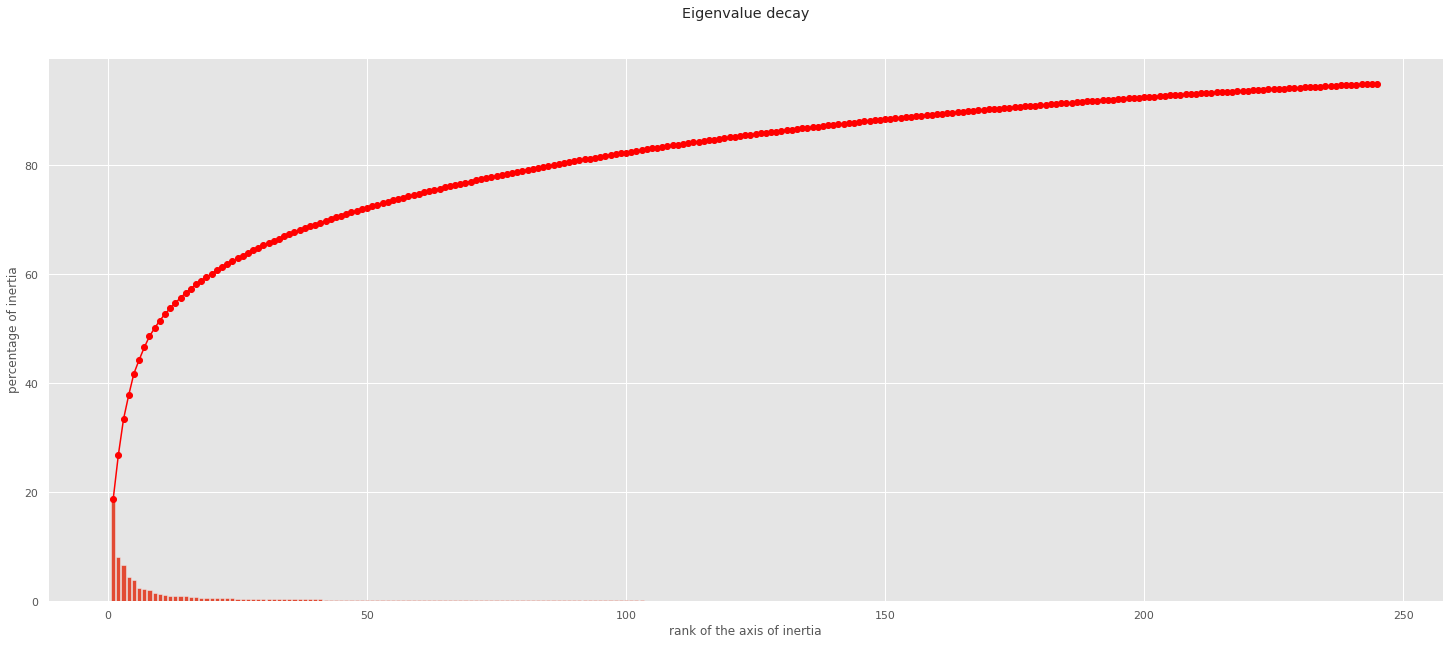

In [ ]:
plt.figure(figsize=(25, 10))
inertia(pca)

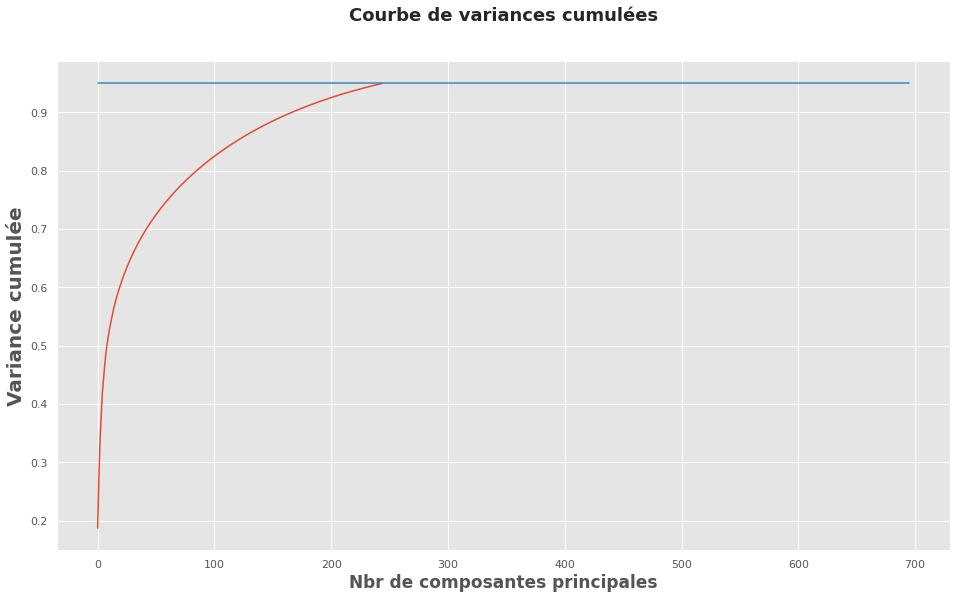

In [ ]:
plt.figure(figsize=(16, 9))
plt.ylabel("Variance cumulée", weight='bold', size=20)
plt.xlabel('Nbr de composantes principales', weight='bold', size=17)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Courbe de variances cumulées', size=18, weight='bold')
plt.plot([0, df_visual_word_total.shape[1]], [0.95, 0.95])

In [ ]:
c = 0
for i in pca.explained_variance_ratio_.cumsum():
    c += 1
    if(i > 0.95):
        print(
            'Il faut {} composantes pour expliquer 99% de la variance du dataset'.format(c))
        break

Il faut 245 composantes pour expliquer 99% de la variance du dataset


In [ ]:
composantes = pca.components_
nbre_composantes = pca.n_components

In [ ]:
a_show = pca.transform(im_features)[:, 0]  # Component 1

b_show = pca.transform(im_features)[:, 1]  # Component 2

X_pca = pca.transform(im_features)[:, :c]

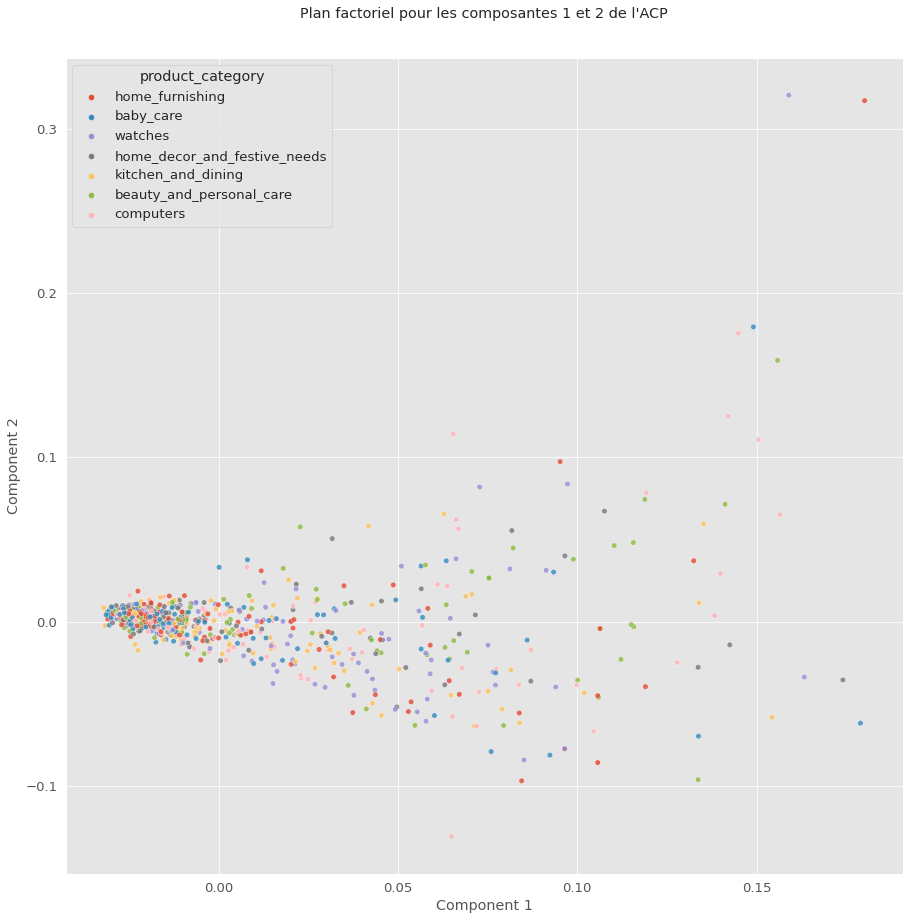

In [ ]:
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(15, 15))
chaine = "Plan factoriel pour les composantes 1 et 2 de l'ACP"
plt.title(chaine)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
ax = plt.gca()

sns.scatterplot(
    x=a_show,
    y=b_show,
    hue=data_clean['product_category'],
    alpha=0.8,
    s=30
)
sns.set_context("paper", font_scale=1)

## <font color='blue'>T-SNE</font>

In [ ]:
from sklearn import manifold, decomposition

tsne = TSNE(n_components=2, init='pca', random_state=6)
X_tsne = tsne.fit_transform(X_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = final_data["category"]
print(df_tsne.shape)

(1050, 3)


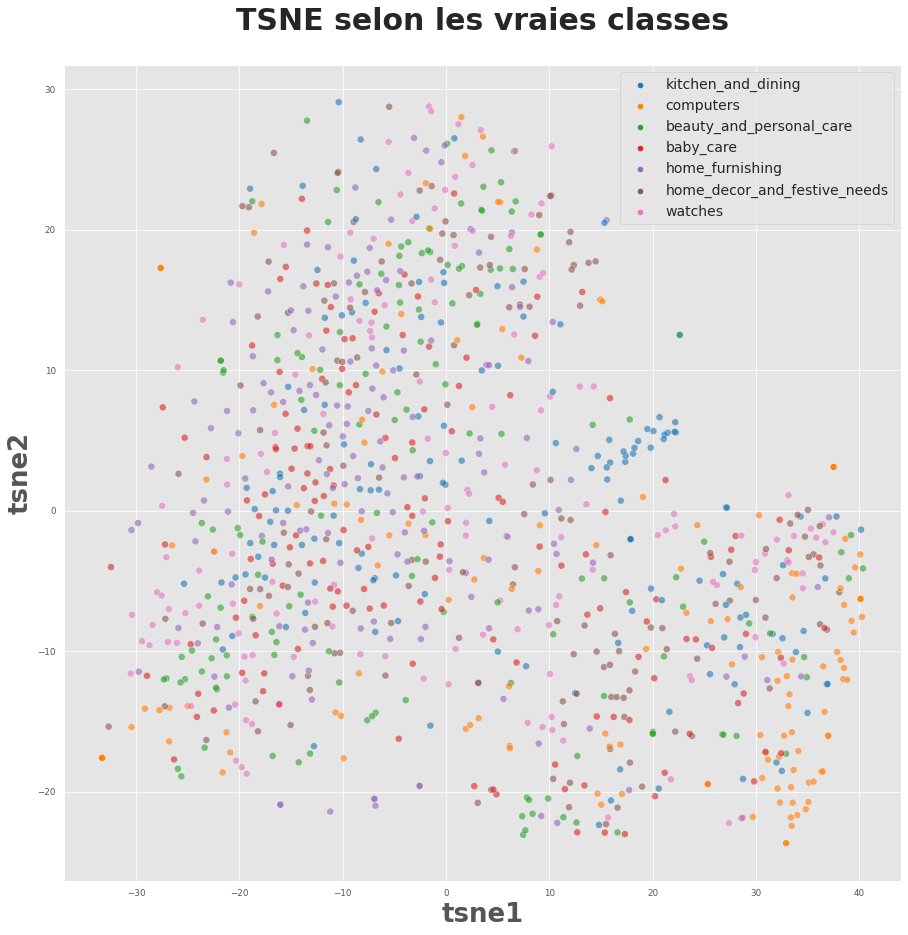

In [ ]:
plt.figure(figsize=(15,15))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

# <font color='green'>Clustering</font>

## <font color='blue'>K-means</font>

In [ ]:
km = KMeans(n_clusters=7,
            init='k-means++')

Exécution 
 
Nombre de lignes pris en compte pour le clustering 1050 
 

Qualité du Clustering 
 
 
Le coefficient de silhouette moyen est de 0.0798609700060452 pour la méthode k-means.
 
 
Le score ARI est de 0.018804758715058826 pour la méthode k-means. 
 

Visualisation 
 
 


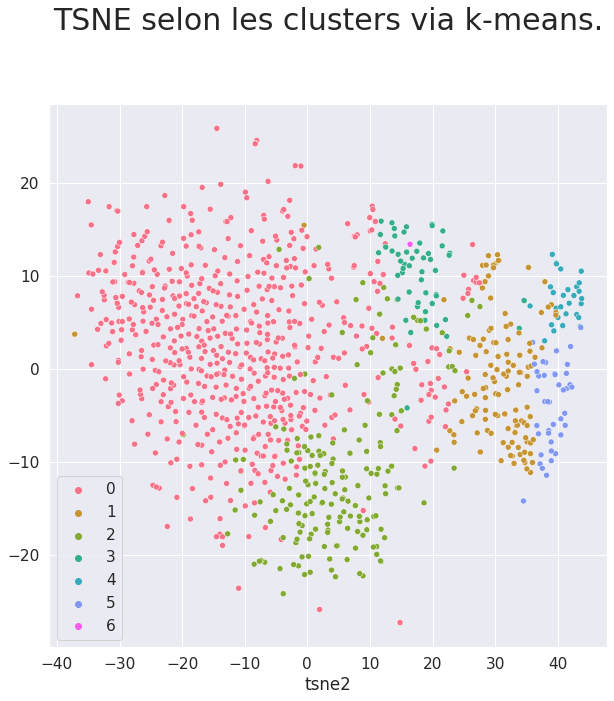

ARI :  0.018804758715058826

 



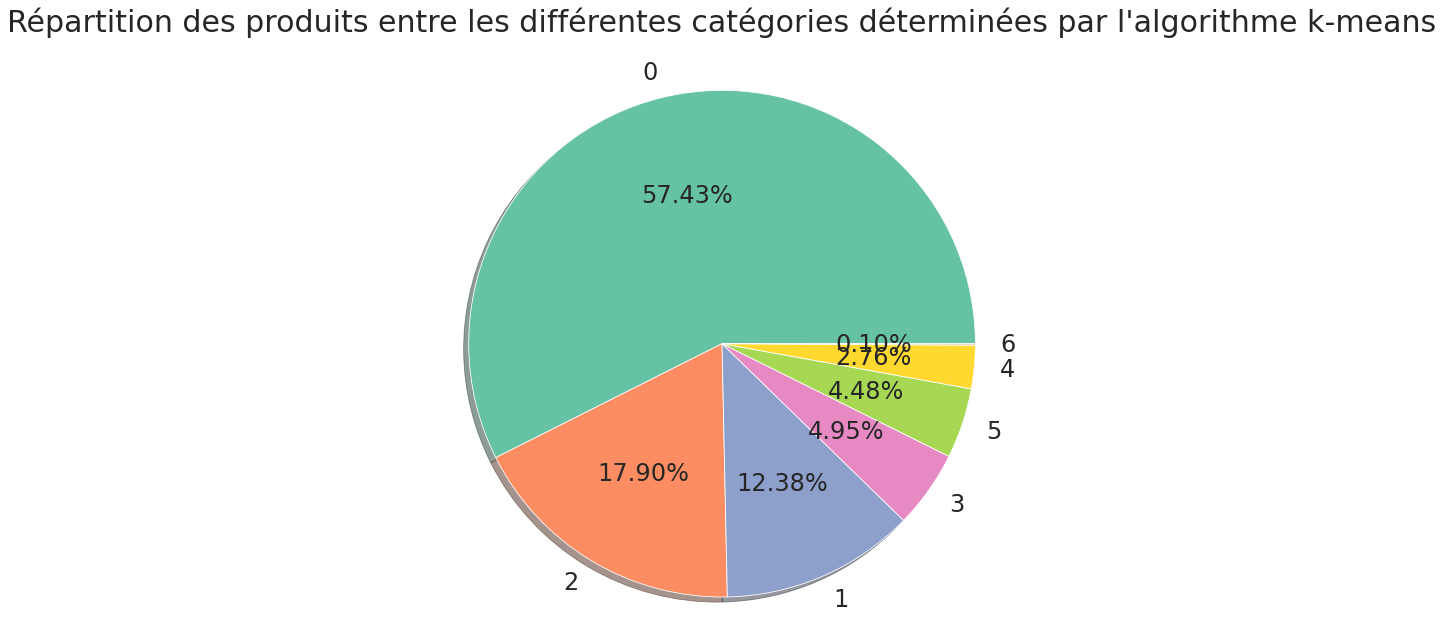

In [ ]:
silhouette, ARI, tot_data_label = clustering(
    km, X_pca, final_data['category'], final_data['label_category'], 'k-means')

In [ ]:
label = np.arange(tot_data_label['algo_cluster'].min(
), tot_data_label['algo_cluster'].max()+1, 1)
for i in range(len(label)):
    df = tot_data_label.loc[tot_data_label['algo_cluster'] == label.item(i)]
    cat = df['category'].unique()
    print('Dans le Cluster {} on retrouve des données réparties dans les catégories {} déterminées manuellement. \n \n' .format(label.item(i), cat))

Dans le Cluster 0 on retrouve des données réparties dans les catégories ['kitchen_and_dining' 'beauty_and_personal_care' 'baby_care'
 'home_furnishing' 'home_decor_and_festive_needs' 'computers' 'watches'] déterminées manuellement. 
 

Dans le Cluster 1 on retrouve des données réparties dans les catégories ['computers' 'kitchen_and_dining' 'home_decor_and_festive_needs'
 'beauty_and_personal_care' 'baby_care' 'watches' 'home_furnishing'] déterminées manuellement. 
 

Dans le Cluster 2 on retrouve des données réparties dans les catégories ['beauty_and_personal_care' 'home_decor_and_festive_needs'
 'home_furnishing' 'computers' 'kitchen_and_dining' 'watches' 'baby_care'] déterminées manuellement. 
 

Dans le Cluster 3 on retrouve des données réparties dans les catégories ['beauty_and_personal_care' 'baby_care' 'home_decor_and_festive_needs'
 'kitchen_and_dining' 'watches' 'home_furnishing' 'computers'] déterminées manuellement. 
 

Dans le Cluster 4 on retrouve des données réparties dans

In [ ]:
table = pd.pivot_table(tot_data_label, values='label_category', index=['category'],  # , 'category'
                       columns=['algo_cluster'], aggfunc=lambda x: len(x), fill_value=0)
table

algo_cluster                    0   1   2   3   4   5  6
category                                                
baby_care                     106  17  13  11   1   1  1
beauty_and_personal_care       89   7  37   8   2   7  0
computers                      54  23  20   7  21  25  0
home_decor_and_festive_needs   68  22  42  14   1   3  0
home_furnishing               116   4  23   4   0   3  0
kitchen_and_dining             77  33  25   6   2   7  0
watches                        93  24  28   2   2   1  0

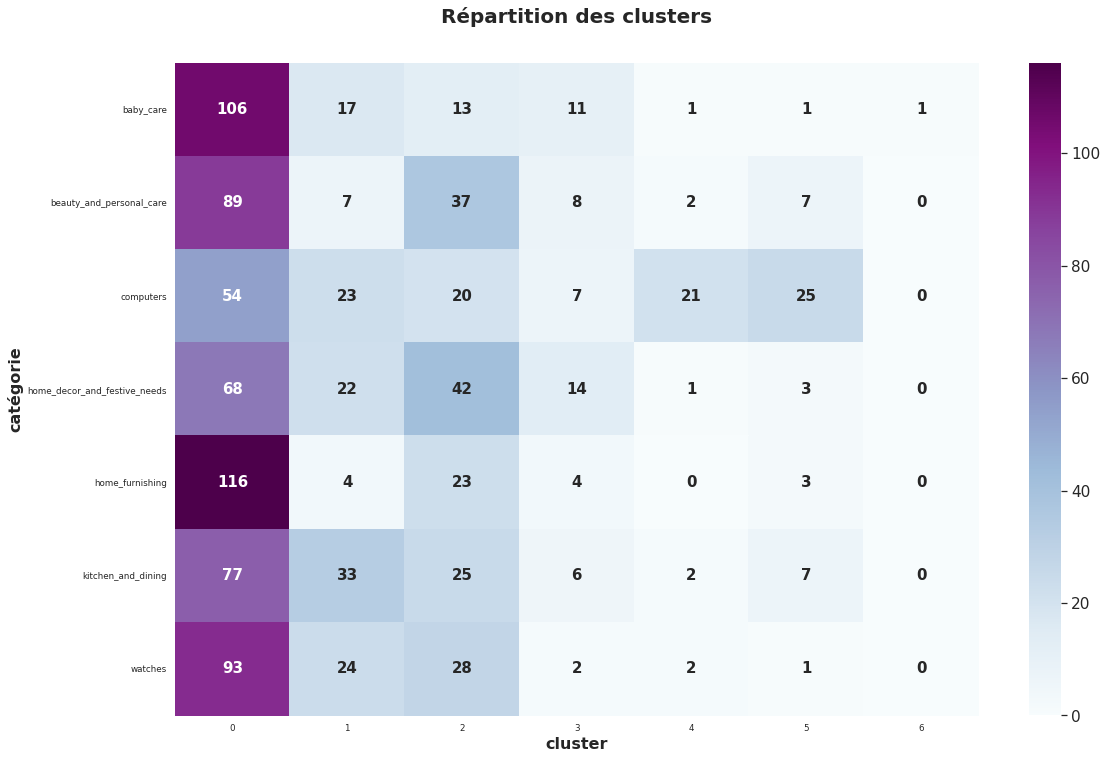

In [ ]:
plt.figure(figsize=(18, 12))
plt.title('Répartition des clusters', size=20, weight='bold')
sns.set(font_scale=1.4)  # for label size
sns.heatmap(table, annot=True,
            cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'},
            fmt='g')

plt.ylabel("catégorie", weight='bold', size=16)
plt.xlabel('cluster', weight='bold', size=16)
plt.show()

In [ ]:
clustering_resume = pd.DataFrame({})

clustering_resume = clustering_resume.append(
    pd.DataFrame(
        {
            "Algorithme": "k-means",
            "silhouette": silhouette,
            "ARI": ARI
        },
        index=[0],
    )
)
clustering_resume

Algorithme  silhouette       ARI
0    k-means    0.079861  0.018805

## <font color='blue'>Clustering Hiérarchique</font>

In [ ]:
hierarchique = AgglomerativeClustering(n_clusters=7)

Exécution 
 
Nombre de lignes pris en compte pour le clustering 1050 
 

Qualité du Clustering 
 
 
Le coefficient de silhouette moyen est de 0.19238307125347903 pour la méthode clustering hiérarchique.
 
 
Le score ARI est de 0.01110689531236173 pour la méthode clustering hiérarchique. 
 

Visualisation 
 
 


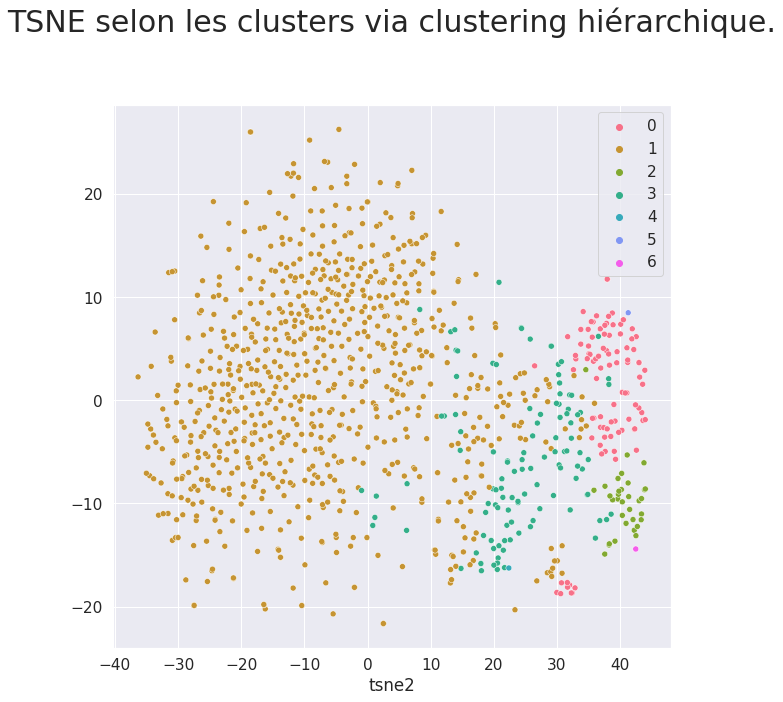

ARI :  0.01110689531236173

 



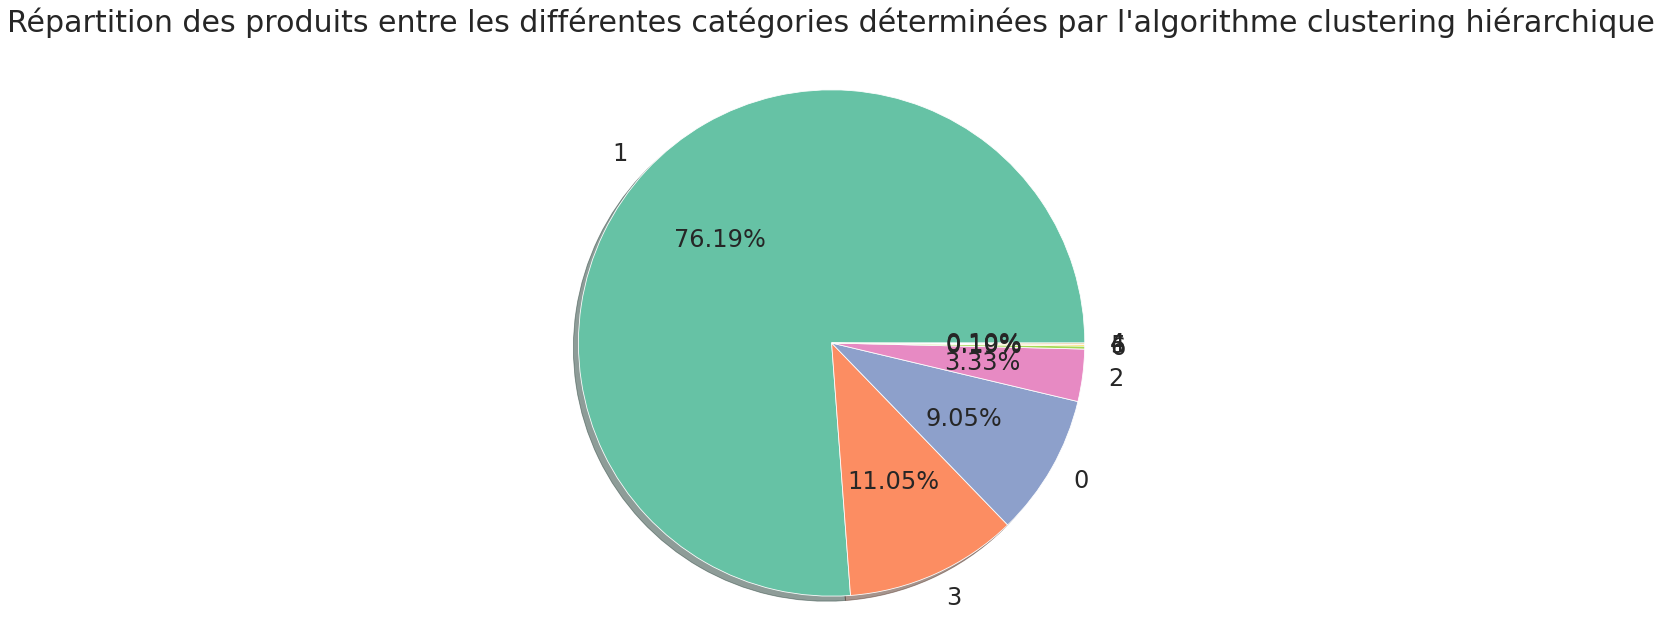

In [ ]:
silhouette, ARI, tot_data_label = clustering(
    hierarchique, X_pca, final_data['category'], final_data['label_category'], 'clustering hiérarchique')

In [ ]:
label = np.arange(tot_data_label['algo_cluster'].min(
), tot_data_label['algo_cluster'].max()+1, 1)
for i in range(len(label)):
    df = tot_data_label.loc[tot_data_label['algo_cluster'] == label.item(i)]
    cat = df['category'].unique()
    print('Dans le Cluster {} on retrouve des données réparties dans les catégories {} déterminées manuellement. \n \n' .format(label.item(i), cat))

Dans le Cluster 0 on retrouve des données réparties dans les catégories ['computers' 'beauty_and_personal_care' 'kitchen_and_dining'
 'home_decor_and_festive_needs' 'baby_care' 'watches' 'home_furnishing'] déterminées manuellement. 
 

Dans le Cluster 1 on retrouve des données réparties dans les catégories ['kitchen_and_dining' 'beauty_and_personal_care' 'baby_care'
 'home_furnishing' 'home_decor_and_festive_needs' 'computers' 'watches'] déterminées manuellement. 
 

Dans le Cluster 2 on retrouve des données réparties dans les catégories ['home_decor_and_festive_needs' 'kitchen_and_dining' 'computers'
 'beauty_and_personal_care' 'baby_care' 'watches'] déterminées manuellement. 
 

Dans le Cluster 3 on retrouve des données réparties dans les catégories ['computers' 'beauty_and_personal_care' 'baby_care' 'kitchen_and_dining'
 'home_decor_and_festive_needs' 'watches' 'home_furnishing'] déterminées manuellement. 
 

Dans le Cluster 4 on retrouve des données réparties dans les catégories ['

In [ ]:
table = pd.pivot_table(tot_data_label, values='label_category', index=['category'],  # , 'category'
                       columns=['algo_cluster'], aggfunc=lambda x: len(x), fill_value=0)
table

algo_cluster                   0    1   2   3  4  5  6
category                                              
baby_care                      5  123   2  19  1  0  0
beauty_and_personal_care       7  129   2  12  0  0  0
computers                     32   75  24  17  0  0  2
home_decor_and_festive_needs  12  107   2  29  0  0  0
home_furnishing                5  137   0   8  0  0  0
kitchen_and_dining            19  106   3  21  0  1  0
watches                       15  123   2  10  0  0  0

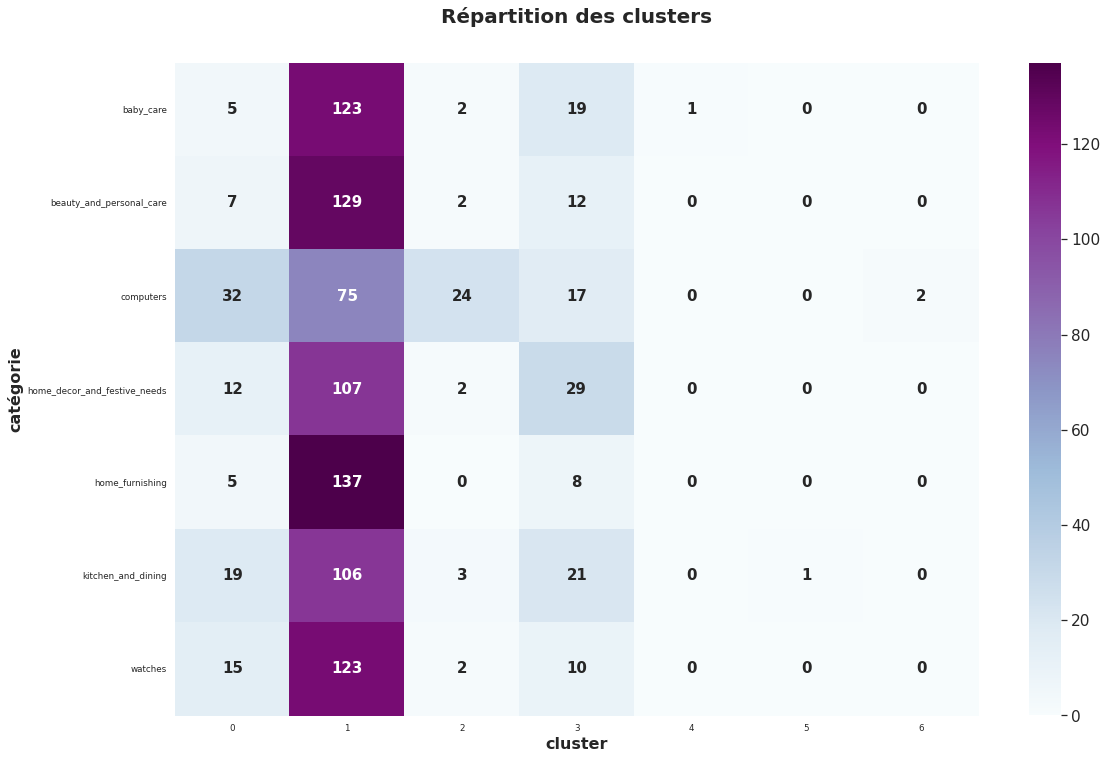

In [ ]:
plt.figure(figsize=(18, 12))
plt.title('Répartition des clusters', size=20, weight='bold')
sns.set(font_scale=1.4)  # for label size
sns.heatmap(table, annot=True,
            cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'},
            fmt='g'
            )

plt.ylabel("catégorie", weight='bold', size=16)
plt.xlabel('cluster', weight='bold', size=16)
plt.show()

In [ ]:
clustering_resume = clustering_resume.append(
    pd.DataFrame(
        {
            "Algorithme": "clustering hiérarchique",
            "silhouette": silhouette,
            "ARI": ARI
        },
        index=[1],
    )
)
clustering_resume

Algorithme  silhouette       ARI
0                  k-means    0.079861  0.018805
1  clustering hiérarchique    0.192383  0.011107

Dans notre cas, le clustering devrait être fait par  qui donne les meilleurs résultats. Mais il faut tout de même trouver un algorithme qui donnera de meilleurs résultats car ici le clustering est peu efficace.

# <font color='green'>Classification avec réduction de dimension</font>

### <font color='violet'>Preparation</font>

#### <font color='grey'>Séparation en train/test </font>

In [ ]:
def write_image_in_good_set(L1, L2, set_type):
    """
    Pour l'utilisation de data_generator : répartition des images dans les dossiers train et test correspondants
    en fonction du test_train split
    """

    c = 0

    for i, j in zip(L1, L2):

        c += 1
        # Lecture de l'image.
        """img = cv2.imread(
            '/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/Flipkart/Images/{}'.format(i))"""
        img = cv2.imread(
            '/content/drive/MyDrive/Data_projet_OC/Flipkart/Images/{}'.format(i))


        # Ecriture de l'image dans le dossier à la classe correspondante.
        """cv2.imwrite(
            '/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/{0}/{1}/im{2}.jpg'.format(set_type, j, c), img)"""
        # cv2.imwrite(
        #    '/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/{0}/im{1}.jpg'.format(set_type, c), img)
        cv2.imwrite(
            '/content/drive/MyDrive/Data_projet_OC/{0}/{1}/{2}'.format(set_type, j, i), img)

In [ ]:
df = data_clean_ordered[['image', 'product_category']].copy()
df

image          product_category
0     f01140c02fd09e5c56312a64fa8db3da.jpg        kitchen_and_dining
1     b4d35b6536b623c83b293eb3a1c02bba.jpg                 computers
2     69446af66066146718cd569f87e99fff.jpg        kitchen_and_dining
3     6329ddb46087cb8c09ced95471dd9643.jpg                 computers
4     7e6ae1b372e8e0b509b83ba3658b8107.jpg                 computers
...                                    ...                       ...
1045  493d1eb6ad7a48a926092bf994cd0bb0.jpg        kitchen_and_dining
1046  e7cab08a267e815c72a26513222783e0.jpg        kitchen_and_dining
1047  d1899ab1d5c79ddaa311bc9f04d198ed.jpg                 computers
1048  02a53d335775b652f22f41b529b9d646.jpg  beauty_and_personal_care
1049  3388d05e88972ff9f3e1321dc0cfdc28.jpg        kitchen_and_dining

[1050 rows x 2 columns]

In [ ]:
# Split en training/testing set.
X_train, X_test, y_train, y_test = train_test_split(df['image'],
                                                    df['product_category'],
                                                    test_size=0.20,
                                                    random_state=42)


# Writting the image of the training set.
write_image_in_good_set(X_train, y_train, 'Training Set')

# Writting the image of the training set.
write_image_in_good_set(X_test, y_test, 'Testing Set')

In [ ]:
# chargement des images
"""base_dir = '/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/'
"""
base_dir = '/content/drive/MyDrive/Data_projet_OC/'
train_dir = os.path.join(base_dir, 'Training Set')
test_dir = os.path.join(base_dir, 'Testing Set')
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)  # preprocessing image
batch_size = 20

print("Training Set :")
datagen.flow_from_directory(train_dir,
                            class_mode='categorical')
print("\n \n")

print("Test Set :")
datagen.flow_from_directory(test_dir,
                            class_mode='categorical')
print("\n \n")

Training Set :
Found 840 images belonging to 7 classes.

 

Test Set :
Found 210 images belonging to 7 classes.

 



In [ ]:
from google.colab import drive
y_train = pd.DataFrame(y_train)
#y_train.to_csv('y_train.csv', index=False)

# sur google colab
drive.mount('/content/drive')
y_train.to_csv('y_train_nt2.csv', index=False)
!cp y_train_nt2.csv /content/drive/My\ Drive/

y_train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: 'y_train_nt2.csv' and '/content/drive/My Drive/y_train_nt2.csv' are the same file


product_category
554                  computers
1012                   watches
481                    watches
432                  computers
626            home_furnishing
...                        ...
330   beauty_and_personal_care
466                    watches
121         kitchen_and_dining
1044        kitchen_and_dining
860                  baby_care

[840 rows x 1 columns]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

y_train = pd.read_csv('/content/drive/MyDrive/'
                      'y_train_nt2.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
from google.colab import drive
y_test = pd.DataFrame(y_test)
#y_test.to_csv('y_test.csv', index=False)

# sur google colab
drive.mount('/content/drive')
y_test.to_csv('y_test_nt2.csv', index=False)
!cp y_test.csv /content/drive/My\ Drive/


y_test

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat 'y_test.csv': No such file or directory


product_category
352      beauty_and_personal_care
689  home_decor_and_festive_needs
485                       watches
388               home_furnishing
31   home_decor_and_festive_needs
..                            ...
694               home_furnishing
539                       watches
449                       watches
622            kitchen_and_dining
209  home_decor_and_festive_needs

[210 rows x 1 columns]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

y_test = pd.read_csv('/content/drive/MyDrive/'
                     'y_test_nt2.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
from google.colab import drive
X_train = pd.DataFrame(X_train)
#y_train.to_csv('y_train.csv', index=False)

# sur google colab
drive.mount('/content/drive')
X_train.to_csv('X_train_nt2.csv', index=False)
!cp X_train_nt2.csv /content/drive/My\ Drive/

X_train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: 'X_train_nt2.csv' and '/content/drive/My Drive/X_train_nt2.csv' are the same file


image
554   85aec4bf3185da7ebcc45003429cbfe2.jpg
1012  1e8741b5ae27a513546c94b3f3312aee.jpg
481   b4e829e38d69d299a923abf8d11ac18d.jpg
432   9f9bb0ef3bb8af571bcfbfa1a22150bd.jpg
626   ce9cb60201f1cdc33e4b58d3583c7a5c.jpg
...                                    ...
330   955abcd11312fce2fd02a91a9b05ae71.jpg
466   86b358a265312c139e5714e663daff05.jpg
121   c5590e238d44b370337624f5987fb9b8.jpg
1044  8050d31bffe6827c804b8222338aafb2.jpg
860   3aaa50eb5d2cf4c18b57346423871624.jpg

[840 rows x 1 columns]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

X_train = pd.read_csv('/content/drive/MyDrive/'
                      'X_train_nt2.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
from google.colab import drive
y_test = pd.DataFrame(y_test)
#y_test.to_csv('y_test.csv', index=False)

# sur google colab
drive.mount('/content/drive')
X_test.to_csv('X_test_nt2.csv', index=False)
!cp X_test.csv /content/drive/My\ Drive/


X_test

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat 'X_test.csv': No such file or directory


352    726de30d1473ecb9641c1cd5286b6344.jpg
689    5fdb912462da9891e5b21c677ceb15e4.jpg
485    b19c9174113c2b9288157e14c48a8250.jpg
388    26269fd0df12630eec4508c2cf3c94e1.jpg
31     57578c1e6ec61a880a6f3f971f5f77b8.jpg
                       ...                 
694    037c2402fee39fbc80433935711d1383.jpg
539    156bcd3aba1838a2b6bad856654db964.jpg
449    d5d6c94b78fb0875b2894d44e7c46312.jpg
622    c997312abfa36281d41366cb4a3b908e.jpg
209    9833d0de7f7e1927c807411c10b19189.jpg
Name: image, Length: 210, dtype: object

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

X_test = pd.read_csv('/content/drive/MyDrive/'
                     'X_test_nt2.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

#### <font color='grey'>Bag of visual word : train set </font>

##### <font color='violet'>Read and detect keypoints</font>

In [ ]:
# Liste contenant les descripteurs.
sift_keypoints = []

"""total_list = []
path = "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/Training Set/"
for subdir, dirs, files in os.walk(path):
    for file in files:
        # print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".jpg"):
            total_list.append(file)"""


# Extraction des descripteurs par orb
orb = cv2.ORB_create()


classes = ["baby_care", "beauty_and_personal_care", "computers",
           "home_decor_and_festive_needs", "home_furnishing", "kitchen_and_dining", "watches"]

for cat in classes:

    #path = "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/Training Set/{}/".format(cat)
    path = "/content/drive/MyDrive/Data_projet_OC/Training Set/{}/".format(cat)

    list_name_pictures_train = [file for file in listdir(path)]
    print(cat)
    print("Nombre d'images pour cette classe : {} \n \n " .format(
        len(list_name_pictures_train)))

    for image_num in range(len(list_name_pictures_train)):
        extension = list_name_pictures_train[image_num].split('.')[-1]
        if extension != "jpg":
            pass
        else:
            image_bw = cv2.imread(
                path+list_name_pictures_train[image_num], 0)  # convert in grey
            # convert all picture to the same size
            image_bw_resized = imutils.resize(image_bw, width=400)

            # Amélioration luminosité
            #img_lum = autocontrast_func(image_bw_resized)

            # Amélioration contraste
            # image_cont = cv2.equalizeHist(img_lum)   # égalisation histogramme
            image_cont = cv2.equalizeHist(
                image_bw_resized)   # égalisation histogramme

            # Débruitage
            image_denoise = cv2.fastNlMeansDenoising(image_cont)

            # Filtre médian
            image_filtre_1 = cv2.medianBlur(image_denoise, 3)
            #image_filtre_1 = cv2.medianBlur(image_cont, 3)

            # filtre gausien
            image_filtre_2 = cv2.GaussianBlur(image_filtre_1, (5, 5), 1)

            # Keypoints & Descripteurs.
            key_points, descriptors = orb.detectAndCompute(
                image_filtre_2, None)
            #img = cv2.drawKeypoints(i,kp,i)

            sift_keypoints.append(descriptors)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print('\n \n Nombre de descripteurs au total pour les données train:',
      sift_keypoints_all.shape[0])

baby_care
Nombre d'images pour cette classe : 121 
 
 
beauty_and_personal_care
Nombre d'images pour cette classe : 113 
 
 
computers
Nombre d'images pour cette classe : 126 
 
 
home_decor_and_festive_needs
Nombre d'images pour cette classe : 125 
 
 
home_furnishing
Nombre d'images pour cette classe : 117 
 
 
kitchen_and_dining
Nombre d'images pour cette classe : 119 
 
 
watches
Nombre d'images pour cette classe : 119 
 
 

 
 Nombre de descripteurs au total pour les données train: 380019


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
!ls

file_name = "sift_keypoints_by_img_train.pkl"
open_file = open(file_name, "wb")
pickle.dump(sift_keypoints_by_img, open_file)
open_file.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
!ls

open_file = open(file_name, "rb")
sift_keypoints_by_img = pickle.load(open_file)
open_file.close()

# print(sift_keypoints_by_img)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
!ls

file_name1 = "sift_keypoints_all_train.pkl"
open_file1 = open(file_name1, "wb")
pickle.dump(sift_keypoints_all, open_file1)
open_file1.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
!ls

open_file1 = open(file_name1, "rb")
sift_keypoints_all = pickle.load(open_file1)
open_file1.close()

# print(sift_keypoints_all)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

#### <font color='grey'>Clustering via kmeans</font> 

In [ ]:
from sklearn import cluster, metrics

# Determination number of clusters
k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
model = cluster.MiniBatchKMeans(
    n_clusters=k, random_state=0, init='k-means++', init_size=3*k).fit(sift_keypoints_all)
# MiniBatchKMeans k-means plus rapide argument en plus : init_size=3*k

"""def clust_kmeans(k, descriptor_list):
    kmeans = cluster.MiniBatchKMeans(n_clusters=k, random_state=0, init='k-means++', init_size=3*k)   #MiniBatchKMeans k-means plus rapide argument en plus : init_size=3*k
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words

visual_words = clust_kmeans(k, sift_keypoints_all)"""

Nombre de clusters estimés :  616
Création de 616 clusters de descripteurs ...


"def clust_kmeans(k, descriptor_list):\n    kmeans = cluster.MiniBatchKMeans(n_clusters=k, random_state=0, init='k-means++', init_size=3*k)   #MiniBatchKMeans k-means plus rapide argument en plus : init_size=3*k\n    kmeans.fit(descriptor_list)\n    visual_words = kmeans.cluster_centers_ \n    return visual_words\n\nvisual_words = clust_kmeans(k, sift_keypoints_all)"

#### <font color='grey'>Extracting histograms : vecteur features des images</font> 

In [ ]:
"""# Creation of histograms (features)
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)"""


# Creation of histograms (features vectors)
feature_vectors = []

for cat in classes:

    #path = "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/Training Set/{}/".format(cat)
    path = "/content/drive/MyDrive/Data_projet_OC/Training Set/{}/".format(cat)

    list_name_pictures_train = [file for file in listdir(path)]
    print(cat)
    print("Nombre d'images pour cette classe : {} \n \n " .format(
        len(list_name_pictures_train)))

    for image_num in range(len(list_name_pictures_train)):
        extension = list_name_pictures_train[image_num].split('.')[-1]
        if extension != "jpg":
            pass
        else:
            image_bw = cv2.imread(path+list_name_pictures_train[image_num], 0)
            image_bw_resized = imutils.resize(image_bw, width=400)
            image_cont = cv2.equalizeHist(image_bw_resized)
            image_denoise = cv2.fastNlMeansDenoising(image_cont)
            image_filtre_1 = cv2.medianBlur(image_denoise, 3)
            image_filtre_2 = cv2.GaussianBlur(image_filtre_1, (5, 5), 1)

            # Keypoints & Descripteurs : orb extraction
            key_points, descriptors = orb.detectAndCompute(
                image_filtre_2, None)

            # classification of all descriptors in the model
            predict_kmeans = model.predict(descriptors)

            # calculates the histogram
            # k =int(round(np.sqrt(len(sift_keypoints_all)),0))
            hist, bin_edges = np.histogram(predict_kmeans, bins=k)

            # histogram is the feature vector
            feature_vectors.append(hist)

    im_features = np.asarray(feature_vectors)

baby_care
Nombre d'images pour cette classe : 121 
 
 
beauty_and_personal_care
Nombre d'images pour cette classe : 113 
 
 
computers
Nombre d'images pour cette classe : 126 
 
 
home_decor_and_festive_needs
Nombre d'images pour cette classe : 125 
 
 
home_furnishing
Nombre d'images pour cette classe : 117 
 
 
kitchen_and_dining
Nombre d'images pour cette classe : 119 
 
 
watches
Nombre d'images pour cette classe : 119 
 
 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
!ls

file_name2 = "im_features_train.pkl"
open_file2 = open(file_name2, "wb")
pickle.dump(im_features, open_file2)
open_file2.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive
!ls

open_file2 = open(file_name2, "rb")
im_features = pickle.load(open_file2)
open_file2.close()

# print(sift_keypoints_all)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
df_visual_word_Xtrain = pd.DataFrame(im_features)

In [ ]:
# sur google colab
from google.colab import drive
drive.mount('/content/drive')
df_visual_word_Xtrain.to_csv('df_visual_word_Xtrain.csv', index=False)
!cp df_visual_word_Xtrain.csv /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: 'df_visual_word_Xtrain.csv' and '/content/drive/My Drive/df_visual_word_Xtrain.csv' are the same file


In [ ]:
#df_visual_word_Xtrain.to_csv('df_visual_word_Xtrain.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

df_visual_word_Xtrain = pd.read_csv('/content/drive/MyDrive/'
                                    'df_visual_word_Xtrain.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
"""df_visual_word_Xtrain = pd.read_csv(
    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC"
    "/WORK-projet6/df_visual_word_Xtrain.csv")"""

'df_visual_word_Xtrain = pd.read_csv(\n    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC"\n    "/WORK-projet6/df_visual_word_Xtrain.csv")'

In [ ]:
df_visual_word_Xtrain

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  \
0    4  0  0  0  0  0  0  0  0  0   0   5   0   0   4   3   0   1   0   0   2   
1    4  1  0  0  8  2  2  2  1  0   0   1   5   0   3   0   0   0   0   1   1   
2    1  2  1  1  1  2  0  0  0  2   1   2   0   0   0   0   1   1   2   0   1   
3    1  0  1  0  0  0  3  0  0  3   0   2   0   2   4   8   1   2   0   0   0   
4    1  0  0  0  1  0  9  0  0  0   5   1   6   0   0   0   1   1   0   0   5   
..  .. .. .. .. .. .. .. .. .. ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
835  1  0  0  0  2  1  0  0  1  0   0   1   0   1   0   0   0   1   2   0   0   
836  5  0  0  0  1  1  3  1  2  0   1   0   1   6   0   0   1   0   0   1   0   
837  1  0  0  0  3  2  2  0  1  1   1   0   0   0   1   2   0   2   0   0   0   
838  2  1  0  0  0  0  0  0  0  0   0   0   0   0   4   2   0   0   0   0   0   
839  1  0  0  1  0  0  0  0  1  0   0   0   1   0   1   3   1   0   0   0   0   

     21  22  23  24  ...  591  592  593  594  595  596  597  598  599  600  \
0     0   2   0   1  ...    0    1    0    0    0    0    0    0    2    1   
1     1   1   0   1  ...    2    2    0    0    0    1    1    0    0    3   
2     6   1   0   1  ...    0    0    2    0    0    0    0    2    0    1   
3     1   0   0   5  ...    1    0    0    0    1    0    0    2    0    2   
4     0   0   1   1  ...    0    0    6    0    1    0    0    0    0    0   
..   ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
835   1   2   0   4  ...    0    0    2    0    0    0    3    0    1    0   
836   0   2   0   0  ...    1    5    1    1    2    2    2    0    2    5   
837   0   1   0   2  ...    1    0    0    1    0    0    7    0    0    0   
838   3   1   0   0  ...    0    0    0    0    0    0    2    0    1    0   
839   0   1   0   2  ...    0    1    0    1    0    0    0    1    1    0   

     601  602  603  604  605  606  607  608  609  610  611  612  613  614  615  
0      0    1    0    0    2    2    0    0    0    3    1    1    0    0    5  
1      1    0    0    0    1    0    3    0    0    0    0    0    0    0    2  
2      0    0    0    0    0    0    0    0    0    0    0    0    1    0    1  
3      0    1    0    2    0    3    0    0    1    1    0    2    0    0    2  
4      1    0    0    0    0    0    1    1    2    0    2    0    0    0    1  
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
835    0    1    0    1    0    0    0    0    0    2    0    1    0    4    1  
836    1    2    0    0    3    0    0    0    0    1    1    0    0    1    1  
837    0    0    3    4    3    0    0    0    0    1    0    0    0    0    1  
838    0    2    0    0    0    0    2    0    0    0    5    0    0    0    1  
839    1    0    1    2    0    6    1    0    1    0    0    1    0    1    1  

[840 rows x 616 columns]

#### <font color='grey'>Bag of visual word : test set </font>

In [ ]:
# Creation of histograms (features vectors)
feature_vectors = []

for cat in classes:

    #path = "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/Testing Set/{}/".format(cat)
    path = "/content/drive/MyDrive/Data_projet_OC/Testing Set/{}/".format(cat)

    list_name_pictures_test = [file for file in listdir(path)]
    print(cat)
    print("Nombre d'images pour cette classe : {} \n \n " .format(
        len(list_name_pictures_test)))

    for image_num in range(len(list_name_pictures_test)):
        extension = list_name_pictures_test[image_num].split('.')[-1]
        if extension != "jpg":
            pass
        else:
            image_bw = cv2.imread(path+list_name_pictures_test[image_num], 0)
            image_bw_resized = imutils.resize(image_bw, width=400)
            image_cont = cv2.equalizeHist(image_bw_resized)
            image_denoise = cv2.fastNlMeansDenoising(image_cont)
            image_filtre_1 = cv2.medianBlur(image_denoise, 3)
            image_filtre_2 = cv2.GaussianBlur(image_filtre_1, (5, 5), 1)

            # Keypoints & Descripteurs : orb extraction
            key_points, descriptors = orb.detectAndCompute(
                image_filtre_2, None)

            # classification of all descriptors in the model
            predict_kmeans = model.predict(descriptors)

            # calculates the histogram
            # k =int(round(np.sqrt(len(sift_keypoints_all)),0))
            hist, bin_edges = np.histogram(predict_kmeans, bins=k)

            # histogram is the feature vector
            feature_vectors.append(hist)

    im_features = np.asarray(feature_vectors)

baby_care
Nombre d'images pour cette classe : 29 
 
 
beauty_and_personal_care
Nombre d'images pour cette classe : 37 
 
 
computers
Nombre d'images pour cette classe : 24 
 
 
home_decor_and_festive_needs
Nombre d'images pour cette classe : 25 
 
 
home_furnishing
Nombre d'images pour cette classe : 33 
 
 
kitchen_and_dining
Nombre d'images pour cette classe : 31 
 
 
watches
Nombre d'images pour cette classe : 31 
 
 


In [ ]:
file_name2 = "im_features_test.pkl"
open_file2 = open(file_name2, "wb")
pickle.dump(im_features, open_file2)
open_file2.close()

In [ ]:
open_file2 = open(file_name2, "rb")
im_features = pickle.load(open_file2)
open_file2.close()

# print(sift_keypoints_all)

In [ ]:
df_visual_word_Xtest = pd.DataFrame(im_features)

In [ ]:
# sur google colab
from google.colab import drive
drive.mount('/content/drive')
df_visual_word_Xtest.to_csv('df_visual_word_Xtest.csv', index=False)
!cp df_visual_word_Xtest.csv /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: 'df_visual_word_Xtest.csv' and '/content/drive/My Drive/df_visual_word_Xtest.csv' are the same file


In [ ]:
"""df_visual_word_Xtest.to_csv('df_visual_word_Xtest.csv', index=False)"""

"df_visual_word_Xtest.to_csv('df_visual_word_Xtest.csv', index=False)"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/
!ls

data = pd.read_csv('/content/drive/MyDrive/'
                   'df_visual_word_Xtest.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
 classification_model_random_forest_description.sav
 clustering_model_kmeans_description.sav
 CNN_pictures_model
'convert ipynb to html pdf.ipynb'
 Data_projet_OC
 df_tfidfvect.csv
 df_tfidfvect_total.csv
 df_untokenize_description.csv
 df_visual_word_total.csv
 df_visual_word_Xtest.csv
 df_visual_word_Xtrain.csv
 im_features.pkl
 im_features_test.pkl
 im_features_train.pkl
 proba_prediction_description_rf.pkl
 proba_prediction_image_cnn.pkl
 Projet6_01_NLP.html
 Projet6_01_NLP.ipynb
 Projet6_02_Pictures.html
 Projet6_02_Pictures.ipynb
 Projet6_03_NLP+Pictures.html
 Projet6_03_NLP+Pictures.ipynb
 __pycache__
 sift_keypoints_all_total.pkl
 sift_keypoints_all_train.pkl
 sift_keypoints_by_img_total.pkl
 sift_keypoints_by_img_train.pkl
 X_test_nt2.csv
 X_test_nt3.csv
 X_train_nt2.csv
 X_train_nt3.csv
 y_test_description_prediction.csv
 y_t

In [ ]:
"""df_visual_word_Xtest = pd.read_csv(
    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC"
    "/WORK-projet6/df_visual_word_Xtest.csv")"""

'df_visual_word_Xtest = pd.read_csv(\n    "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC"\n    "/WORK-projet6/df_visual_word_Xtest.csv")'

In [ ]:
df_visual_word_Xtest

0    1    2    3    4    5    6    7    8    9    10   11   12   13   \
0      2    0    1    0    0    0    1    0    0    0    0    2    1    2   
1      1    0    2    0    0    0    0    2    0    1    0    2    0    0   
2     15    0   10    0    0    1    0    2    0    0    3    0    0    0   
3      1    0    0    1    0    0    2    2    0    0    0    0    0    0   
4      1    0    0    0    0    1    0    3    4    0    0    0    0    1   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
205    2    0    0    2    0    6    1    1    1    2    0    0    0    1   
206    1    0    1    0    0    0    0    1    0    2    2    4    1    0   
207    3    0    0    0    0    0    0    1    2    0    4    1    1    1   
208    1    0    0    0    0    1    0    5    0    2    0    5    1    1   
209    2    2    0    0    0    0    5    1    1    0    0    6    0    1   

     14   15   16   17   18   19   20   21   22   23   24   ...  591  592  \
0      0    1    0    1    1    0    1    2    0    0    1  ...    1    1   
1      1    1    1    2    0    6    0    2    2    0    1  ...    1    0   
2      0    0    0    0    0    4    3    1    1    0    6  ...    0    0   
3      0    1    1    1    0    7    2    0    0    0    4  ...    0    0   
4      4    0    2    2    0    2    0    0    0    0    2  ...    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
205    0    0    0    0    0    1    1    0    0    0    8  ...    1    0   
206    1    0    0    0    1    2    1    2    4    0    6  ...    0    3   
207    0    2    2    3    3    0    0    0    0    0    4  ...    0    0   
208    0    2    0    2    0    1    0    3    1    3    1  ...    0    1   
209   10    3    2    2    0    0    0    0    0    1    0  ...    0    1   

     593  594  595  596  597  598  599  600  601  602  603  604  605  606  \
0      0    3    4    0    2    0    2    2    0    0    0    0    2    3   
1      1    1    0    0    0    1    2    4    1    0    2    0    2    1   
2      1    0    0    0    2    0    1    0    1    1    0    1    1    0   
3      0    0    0    0    0    0    0    3    0    1    0    0    0    0   
4      1    2    0    0    2    2    0    0    0    6    4    2    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
205    0    3    1    0    0    1    1    0    0    0    0    0    0    0   
206    0    0    0    0    0    0    1    0    1    1    0    1    2    0   
207    1    0    0    0    1    0    1    2    0    2    0    0    3    0   
208    0    1    0    1    1    1    0    0    1    0    0    0    0    0   
209    0    1    0    0    1    0    1    0    0    1    0    1    1    0   

     607  608  609  610  611  612  613  614  615  
0      0    1    0    0    0    1    1    0    2  
1      0    0    1    1    3    0    1    2    1  
2      0    0    0    1    2    0    2    0    1  
3      0    0    0    3    0    0    1    0    8  
4      3    0    1    0    0    0    3    0    1  
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  
205    0    0    0    0    0    1    0    1    1  
206    1    0    0    2    0    0    0    0    1  
207    0    0    0    0    0    3    0    0    1  
208    0    0    2    1    0    0    1    0    1  
209    6    0    1    0    2    2    1    0    3  

[210 rows x 616 columns]

#### <font color='grey'>Reduction de dimension PCA</font>


In [ ]:
df_visual_word_Xtrain.shape

(840, 616)

In [ ]:
pca = PCA(n_components=df_visual_word_Xtrain.shape[1], random_state=40)
pca.fit_transform(df_visual_word_Xtrain)

array([[-1.4028967 , -5.09754616,  5.1814019 , ...,  0.15402643,
         0.04497115, -0.18616402],
       [-0.21155838, -0.40594314, -0.89013449, ...,  0.10940805,
         0.0623943 , -0.07518046],
       [-0.14716179,  2.96908947, -1.96079994, ..., -0.2011566 ,
        -0.12468721,  0.00782868],
       ...,
       [ 0.85666775, -2.72159324, -1.48545418, ...,  0.01397435,
        -0.16409247,  0.16748097],
       [-0.72583498, -3.94890768,  2.8954761 , ..., -0.27468013,
        -0.06136832, -0.22198374],
       [-0.8128352 , -5.55444701,  1.67254438, ..., -0.25823471,
         0.18565975,  0.27169878]])

In [ ]:
X_pca_train = pca.transform(df_visual_word_Xtrain)[:, :c]
X_pca_test = pca.transform(df_visual_word_Xtest)[:, :c]

### <font color='violet'>Knn classifier</font>

In [ ]:
# GridSearch
# create new a knn model
knn2 = KNeighborsClassifier()

# create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
score = 'accuracy'

# use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

# Fit sur le training set.
knn_gscv.fit(X_pca_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
best_param = knn_gscv.best_estimator_
print("Best paramètres: {}".format(best_param))

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
    knn_gscv.cv_results_['mean_test_score'],  # score moyen
    knn_gscv.cv_results_['std_test_score'],  # écart-type du score
    knn_gscv.cv_results_['params']           # valeur de l'hyperparamètre
):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ))

Best paramètres: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')
Résultats de la validation croisée :
accuracy = 0.143 (+/-0.046) for {'n_neighbors': 1}
accuracy = 0.154 (+/-0.023) for {'n_neighbors': 2}
accuracy = 0.149 (+/-0.031) for {'n_neighbors': 3}
accuracy = 0.158 (+/-0.056) for {'n_neighbors': 4}
accuracy = 0.157 (+/-0.051) for {'n_neighbors': 5}
accuracy = 0.155 (+/-0.021) for {'n_neighbors': 6}
accuracy = 0.163 (+/-0.025) for {'n_neighbors': 7}
accuracy = 0.151 (+/-0.018) for {'n_neighbors': 8}
accuracy = 0.139 (+/-0.038) for {'n_neighbors': 9}
accuracy = 0.145 (+/-0.069) for {'n_neighbors': 10}
accuracy = 0.158 (+/-0.043) for {'n_neighbors': 11}
accuracy = 0.160 (+/-0.046) for {'n_neighbors': 12}
accuracy = 0.154 (+/-0.028) for {'n_neighbors': 13}
accuracy = 0.143 (+/-0.021) for {'n_neighbors': 14}
accuracy = 0.146 (+/-0.016) for {'n_neig

Exécution 
 
Qualité de la classification 
 
 
L'accuracy score est de 0.10952380952380952 pour la méthode knn.
 
 
Le score de précision est de 0.11253703554787148 pour la méthode knn.
 
 
Le score recall est de 0.10952380952380952 pour la méthode knn.
 
 
Le score f1 est de 0.10322602686268235 pour la méthode knn.
 
 
Visualisation 
 
 


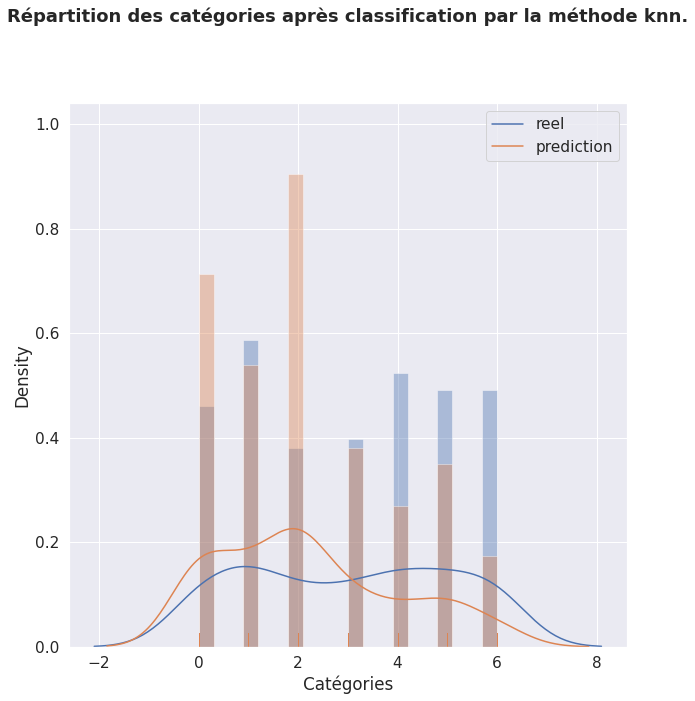

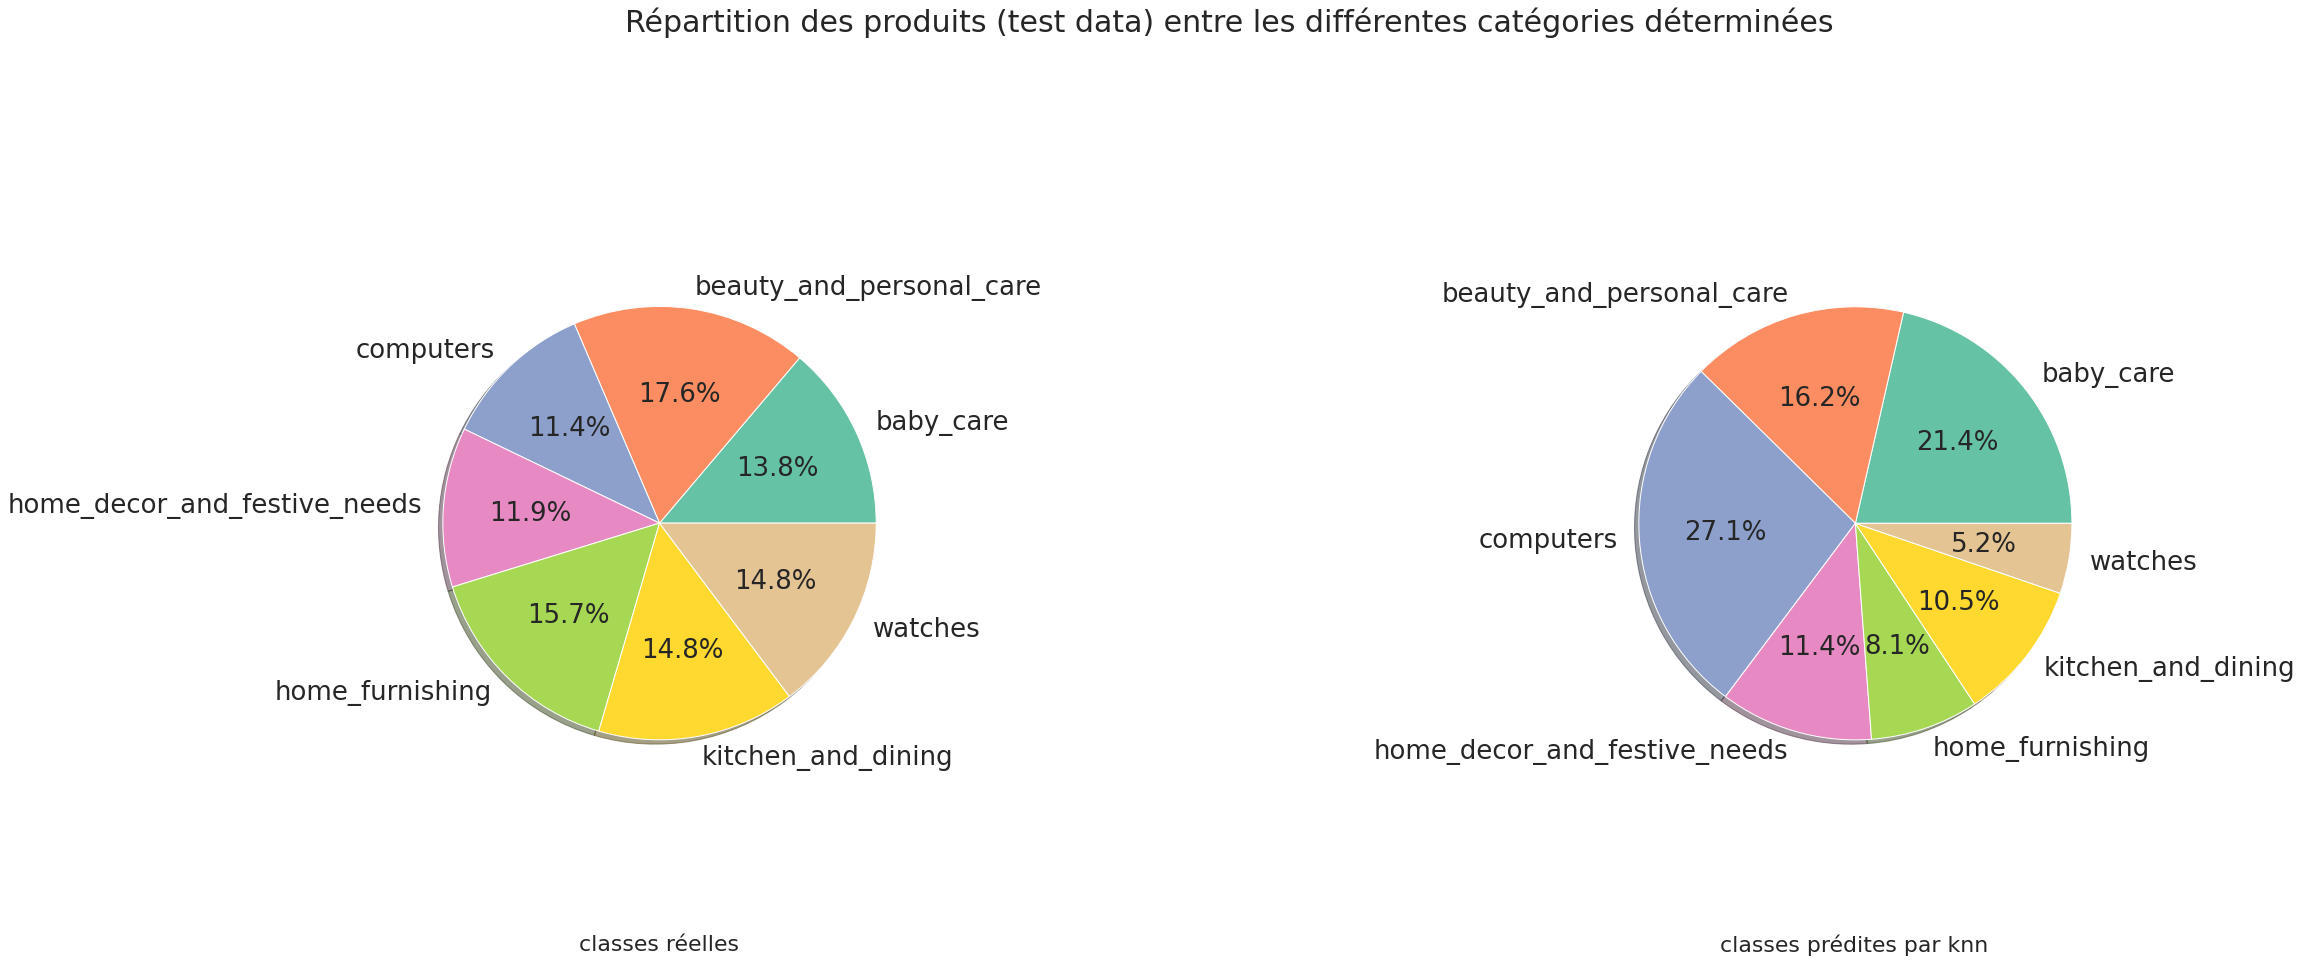

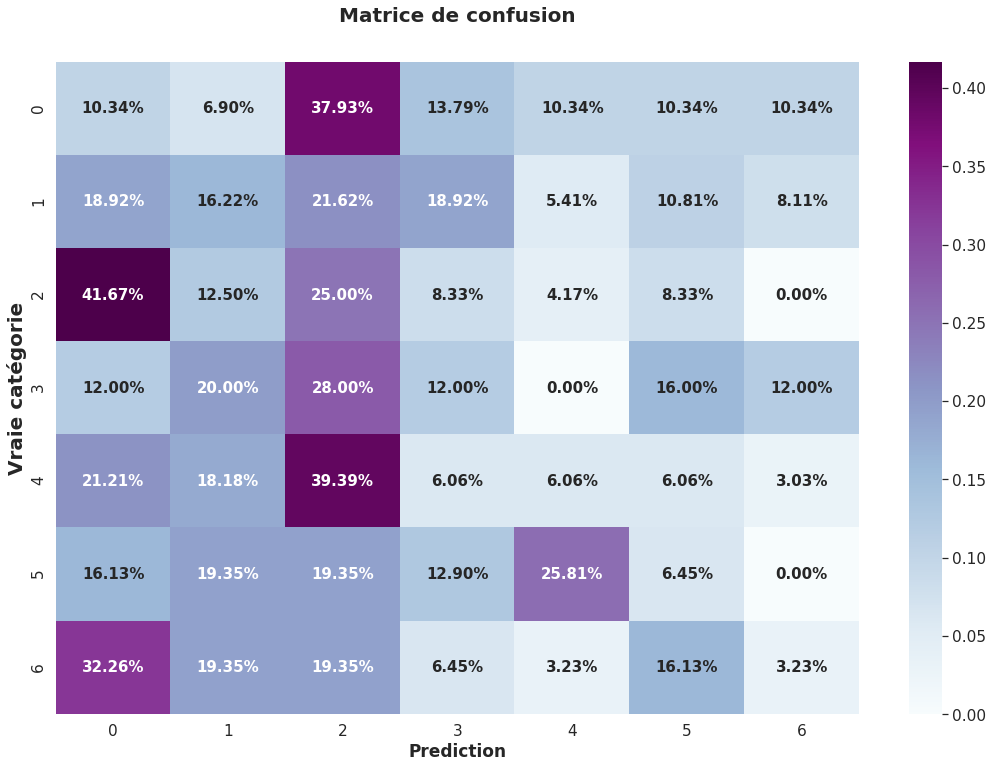

In [ ]:
accuracy, precision, recall, f1, resume_class = classification(
    best_param, X_pca_train, y_train, X_pca_test, y_test, 'knn')

Ici le score d'accuracy est de 0.109 ce qui montre que la classification fonctionne très mal.

Ici le score de précision est de 0.112 montre que la prédiction est très peu précise car le score est proche de 0.

Ici le score de recall est de 0.109 montre que la prédiction ne fait pas en majorité des vrais positifs car le score est proche de 0.

Les labels des catégories prédites correspondent aux labels des catégories réelles pour les donnéees test. On peut voir  que pour les catégories 1, 3, 4, 5 et 6, la classification regroupe moins de produits dans ces catégorie par rapport à la réalité. La conclusion inverse peut être faîte pour les catégories 0 et 2.

Les articles sont surtout regroupés dans les catégories 0, 2.

In [ ]:
classification_resume = pd.DataFrame({})

classification_resume = classification_resume.append(
    pd.DataFrame(
        {
            "Algorithme": "knn",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        },
        index=[0],
    )
)

In [ ]:
classification_resume

Algorithme  accuracy  precision    recall  f1_score
0        knn  0.109524   0.112537  0.109524  0.103226

### <font color='violet'>Random Forest</font>

In [ ]:
# GridSearch
param_grid = [{'max_depth': range(2, 10, 2)}]
gridSearch = GridSearchCV(RandomForestClassifier(),
                          param_grid, cv=5, scoring='accuracy')
score = 'accuracy'


# Fit sur le training set.
gridSearch.fit(X_pca_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
best_param = gridSearch.best_estimator_
print("Best paramètres: {}".format(best_param))

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
    gridSearch.cv_results_['mean_test_score'],  # score moyen
    gridSearch.cv_results_['std_test_score'],  # écart-type du score
    gridSearch.cv_results_['params']           # valeur de l'hyperparamètre
):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ))

Best paramètres: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Résultats de la validation croisée :
accuracy = 0.158 (+/-0.021) for {'max_depth': 2}
accuracy = 0.148 (+/-0.019) for {'max_depth': 4}
accuracy = 0.160 (+/-0.035) for {'max_depth': 6}
accuracy = 0.142 (+/-0.039) for {'max_depth': 8}


Exécution 
 
Qualité de la classification 
 
 
L'accuracy score est de 0.15714285714285714 pour la méthode Random Forest.
 
 
Le score de précision est de 0.13872200774538138 pour la méthode Random Forest.
 
 
Le score recall est de 0.15714285714285714 pour la méthode Random Forest.
 
 
Le score f1 est de 0.13424382577560562 pour la méthode Random Forest.
 
 
Visualisation 
 
 


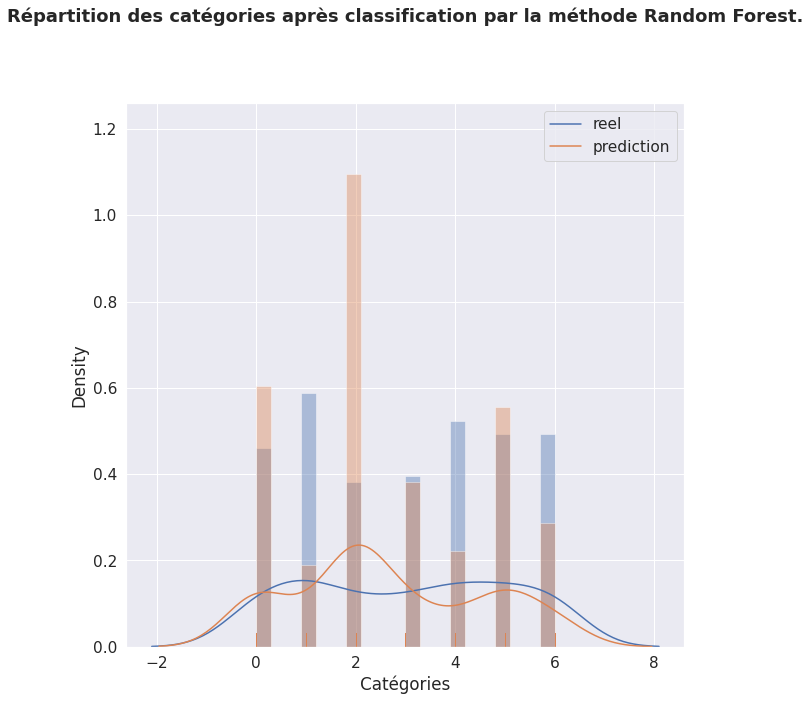

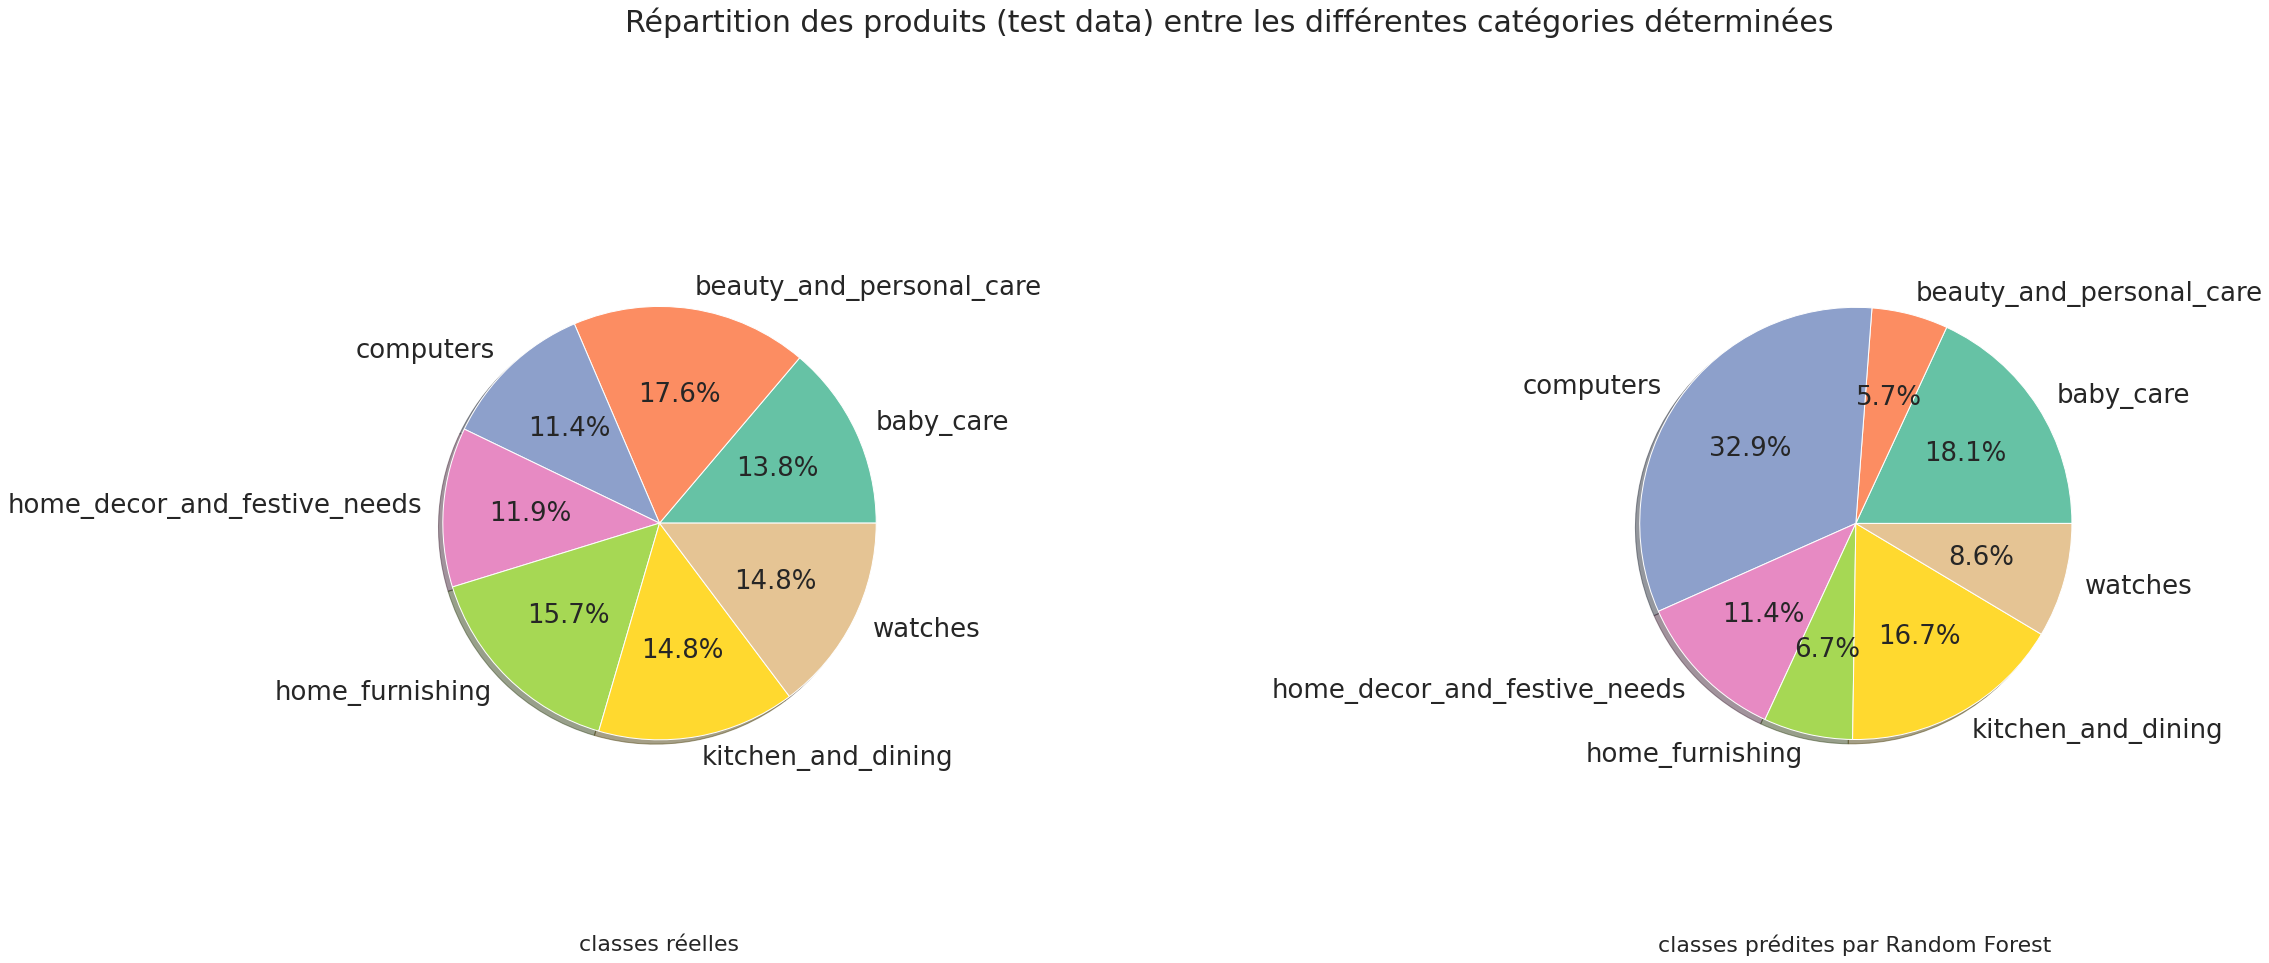

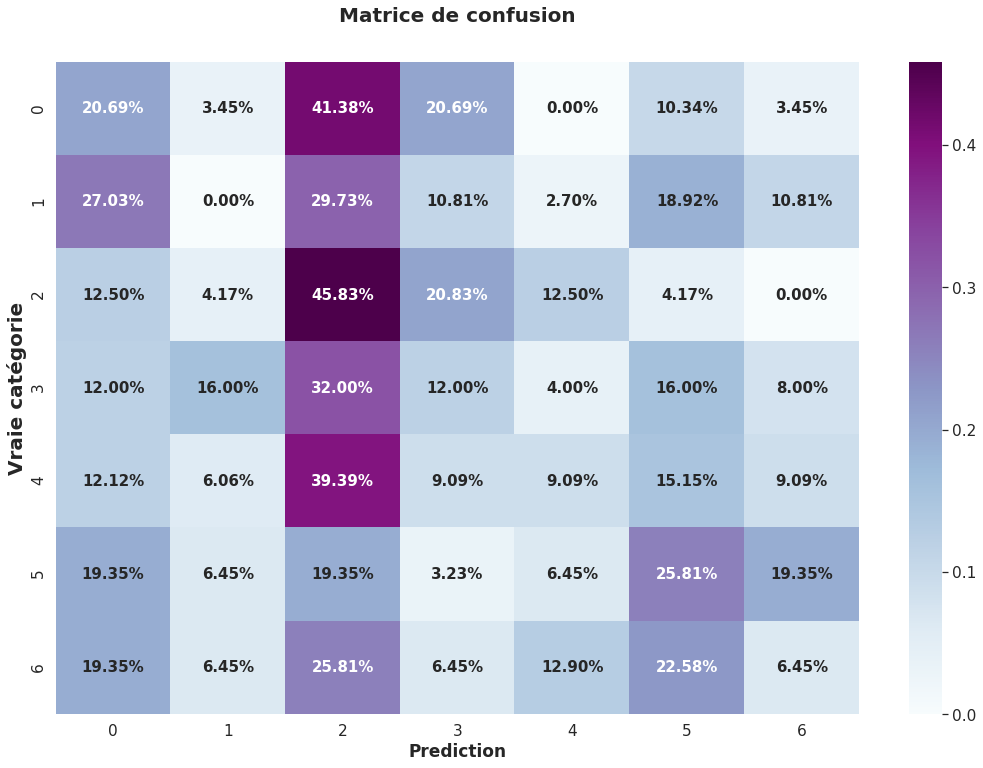

In [ ]:
accuracy, precision, recall, f1, resume_class = classification(
    best_param, X_pca_train, y_train, X_pca_test, y_test, 'Random Forest')

Ici le score d'accuracy est de 0.15 ce qui montre que la classification fonctionne mal.

Ici le score de précision est de 0.13 montre que la prédiction est peu précise car le score est proche de 1.

Ici le score de recall est de 0.15 montre que la prédiction ne fait pas en majorité des vrais positifs car le score est proche de 0.

Les labels des catégories prédites correspondent aux labels des catégories rélles pour les donnéees test. On peut voir aussi que pour les catégories 1, 3, 4 et 6 la classification regroupe moins de produits dans ces catégorie par rapport à la réalité. La conclusion inverse peut être faîte pour les catégories 0, 2 et 5. 

In [ ]:
classification_resume = classification_resume.append(
    pd.DataFrame(
        {
            "Algorithme": "Random Forest",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        },
        index=[1],
    )
)

In [ ]:
classification_resume

Algorithme  accuracy  precision    recall  f1_score
0            knn  0.109524   0.112537  0.109524  0.103226
1  Random Forest  0.157143   0.138722  0.157143  0.134244

Avec une classification standard, nous avons de très mauvais résultats. Voyons si avec un réseau de neurones covolutif adapté à la classification des images nous donne de meilleurs résultats.

# <font color='green'>Deep learning : CNN Transfer Learning</font>

deep learning : type d'apprentissage automatique basé sur des réseaux neuronaux artificiels dans lesquels plusieurs couches de traitement sont utilisées pour extraire des données des caractéristiques.

Le transfert learning utilise des modèles pré-entraînés comme point de départ, il permet de développer rapidement des modèles performants et résoudre efficacement des problèmes complexes en Computer Vision ou Natural Language Processing, NLP.

Le Transfer Learning repose sur une idée simple, celle de ré-exploiter les connaissances acquises dans d’autres configurations (sources) pour la résolution d’un problème particulier (cible).

CNN (réseau de neurones par convolution) est un empilement de couches de neurones qui utilise un modèles pré-entraîné comme extracteurs de features. Ces couches apprennent différentes caractéristiques en fonction du niveau où elles se situent. Plus la couche se situe en profondeur, plus elle permet d’extraire des features spécifiques.


Ici, transfer learning via le réseau VGG16 pré-entrainé sur une base d'images riches (imagenet). Le VGG-16 (Very Deep Convolutional Networks for Large-Scale Image Recognition, 16 couches) est l'un des modèles pré-entraînés les plus populaires pour la classification des images.

## <font color='blue'>Mise en place du modèle</font>

In [ ]:
new_model = Sequential()

# Charger VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected (couches hautes).
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

#On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches :
for layer in model.layers:
   layer.trainable = False

new_model.add(model)

# Ajout d'une couche Flatten pour réduire les dimensions de l'input.
new_model.add(Flatten())

# Ajout de la couche Dense de prédiciton adaptée à notre problème de classifications (7 classes).
new_model.add(Dense(7, activation='softmax'))

In [ ]:
# réseau de neurones
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 175623    
Total params: 14,890,311
Trainable params: 175,623
Non-trainable params: 14,714,688
_________________________________________________________________


En résumé, le VGG-16 contient 16 couches où le nombre de caractéristiques est de 25 088 (flatten) après l'aplatissement de la dernière couche convolutive (la 1ère mise en évidence) et dans la couche finale (prédiction ou couche dense finale), le nombre de nœuds est de 7 car le VGG-16 est principalement entraîné pour un problème de classification de 7 classes (la 2ème mise en évidence) (prédiction).

In [ ]:
# Compilation du modèle
new_model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(
    lr=0.0001, momentum=0.9), metrics=["accuracy"])

batch_size = 32

categorical_crossentropy quand nombre de cat>2 sinon binary_crossentropy


## <font color='blue'>Mise en place des données</font>

In [ ]:
# Path du dossier.
#folder = "/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/Testing Set"
folder = "/content/drive/MyDrive/Data_projet_OC/Testing Set"

i = 0

# Liste contenant les catégories des images chargées
y_test_category = []

for j in os.listdir(folder):

    folder_courant = folder + '/' + j

    for filename in os.listdir(folder_courant):

        y_test_category.append(j)

        # Path du fichier.
        path = folder_courant + '/' + filename

        # Charger l'image à la bonne dimension.
        img_resize = load_img(path, target_size=(224, 224))

        # Transformation de l'image en tableau numpy.
        img = img_to_array(img_resize)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))

        # Preprocessing.
        img = preprocess_input(img)

        # Ajout de l'image à la liste de stockage.
        if (i == 0):
            x1 = img
            i = 1
        else:
            x1 = np.concatenate((x1, img), axis=0)

In [ ]:
# Training Augmentation configuration
#base_dir = '/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet6/Data/'
base_dir = '/content/drive/MyDrive/Data_projet_OC/'

train_dir = os.path.join(base_dir, 'Training Set')
test_dir = os.path.join(base_dir, 'Testing Set')


train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.2,
                                   preprocessing_function=preprocess_input)

# Testing Augmentation
test_datagen = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  preprocessing_function=preprocess_input)

# Generates batches of Augmented Image data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# Generator for validation data
validation_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(224, 224),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 840 images belonging to 7 classes.
Found 210 images belonging to 7 classes.


## <font color='blue'>Exécution</font>

In [ ]:
# Fit the model on Training data
history = new_model.fit_generator(train_generator,
                                  epochs=5,
                                  validation_data=validation_generator,
                                  verbose=1)

with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


# Entraînement du modèle via le train_generator.
# On fait attention à l'overfitting en utilisant notre validation set.
# fit_generator fait la même chose que fit mais fit_generator est mieux adapté au nombreuse données

Epoch 1/5
27/27 [==============================] - 295s 11s/step - loss: 2.0000 - accuracy: 0.1821 - val_loss: 1.6323 - val_accuracy: 0.3857
Epoch 2/5
27/27 [==============================] - 290s 11s/step - loss: 1.6073 - accuracy: 0.4279 - val_loss: 1.3613 - val_accuracy: 0.5476
Epoch 3/5
27/27 [==============================] - 295s 11s/step - loss: 1.2931 - accuracy: 0.5925 - val_loss: 1.1787 - val_accuracy: 0.6476
Epoch 4/5
27/27 [==============================] - 294s 11s/step - loss: 1.1115 - accuracy: 0.6977 - val_loss: 1.0792 - val_accuracy: 0.6381
Epoch 5/5
27/27 [==============================] - 293s 11s/step - loss: 1.0560 - accuracy: 0.6939 - val_loss: 1.0051 - val_accuracy: 0.6952


In [ ]:
new_model.save("CNN_pictures_model")

INFO:tensorflow:Assets written to: CNN_pictures_model/assets


une epoch : une passe avant et une passe arrière de tous les exemples d'entraînement

batch size :  nombre d'échantillons qui seront propagés dans le réseau. 1050 échantillons d'entraînement et vous souhaitez définir une taille de lot égale à 100. 

L'algorithme prend les 100 premiers échantillons (du 1er au 100e) de l'ensemble de données d'apprentissage et entraîne le réseau. 

Ensuite, il prend les 100 autres échantillons (du 101e au 200e) et entraîne à nouveau le réseau.

steps_per_epochs : nombre d'itérations de lot avant qu'une époque d'apprentissage soit considérée comme terminée : steps_per_epoch = len(X_train)//batch_size

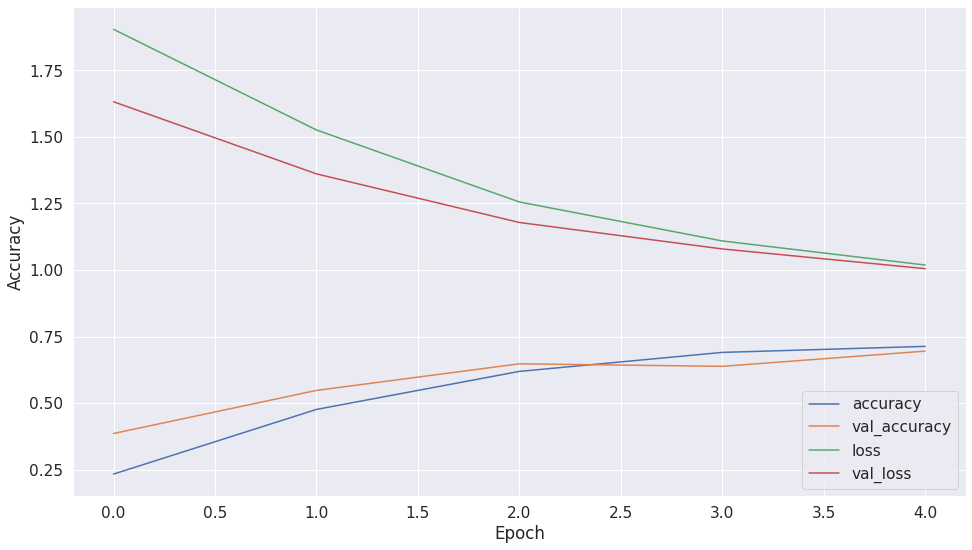

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

fit() sert à entraîner le modèle avec les entrées données (et les étiquettes d'entraînement correspondantes).

evaluate() permet d'évaluer le modèle déjà formé en utilisant les données de validation (ou de test) et les étiquettes correspondantes. Elle renvoie la valeur de perte et les valeurs métriques du modèle.

predict() sert à la prédiction proprement dite. Elle génère des prédictions de sortie pour les échantillons d'entrée.

In [ ]:
# Évaluation de la performance du modèle sur des données de test
loss, accuracy = new_model.evaluate(validation_generator)

print("\nModel's Evaluation Metrics: ")
print("---------------------------")
print("Accuracy: {} \nLoss: {}".format(accuracy, loss))

7/7 [==============================] - 58s 8s/step - loss: 0.9958 - accuracy: 0.7286

Model's Evaluation Metrics: 
---------------------------
Accuracy: 0.7285714149475098 
Loss: 0.9957885146141052


Le CNN a atteint une précision de prédiction de plus de 72%

## <font color='blue'>Prédiction</font>

In [ ]:
# Prediction sur le testing Set.
pred = new_model.predict(x1, verbose=1)
pred

7/7 [==============================] - 54s 8s/step


array([[3.5158644e-16, 1.9895142e-12, 5.6425917e-36, ..., 9.3360141e-14,
        4.1952361e-20, 9.9999988e-01],
       [1.0000000e+00, 4.4294621e-21, 3.5592798e-22, ..., 1.5600742e-10,
        2.3367349e-08, 4.1835616e-13],
       [1.2955138e-04, 5.3446595e-08, 3.6717810e-07, ..., 4.3401320e-12,
        3.1956148e-19, 6.8199378e-04],
       ...,
       [1.1065733e-08, 3.2137439e-07, 9.8907872e-13, ..., 4.5997162e-08,
        4.5584309e-12, 9.9999964e-01],
       [6.8256165e-25, 2.3635848e-14, 9.3629671e-07, ..., 2.2708388e-34,
        7.7163473e-16, 9.9999905e-01],
       [2.1465370e-10, 5.6039959e-01, 4.3959931e-01, ..., 1.0048411e-06,
        1.1771001e-11, 5.8575228e-08]], dtype=float32)

In [ ]:
y_classes = [np.argmax(element) for element in pred]
y_classes[:5]

[6, 0, 3, 0, 4]

In [ ]:
df = pd.DataFrame(y_classes, columns=['predict_category'])
df

predict_category
0                   6
1                   0
2                   3
3                   0
4                   4
..                ...
205                 2
206                 2
207                 6
208                 6
209                 1

[210 rows x 1 columns]

In [ ]:
dico_categ = {0: 'baby_care',
              1: 'beauty_and_personal_care',
              2: 'computers',
              3: 'home_decor_and_festive_needs',
              4: 'home_furnishing',
              5: 'kitchen_and_dining',
              6: 'watches'}

In [ ]:
df = df.replace({"predict_category": dico_categ})
df

predict_category
0                         watches
1                       baby_care
2    home_decor_and_festive_needs
3                       baby_care
4                 home_furnishing
..                            ...
205                     computers
206                     computers
207                       watches
208                       watches
209      beauty_and_personal_care

[210 rows x 1 columns]

In [ ]:
df1 = pd.DataFrame(y_test_category, columns=['product_category'])
df1['product_category'] = df1['product_category'].str.replace(
    "'", '')
df1

product_category
0          baby_care
1          baby_care
2          baby_care
3          baby_care
4          baby_care
..               ...
205        computers
206        computers
207        computers
208        computers
209        computers

[210 rows x 1 columns]

In [ ]:
resume_cnn = pd.concat([df, df1], axis=1)
resume_cnn

predict_category product_category
0                         watches        baby_care
1                       baby_care        baby_care
2    home_decor_and_festive_needs        baby_care
3                       baby_care        baby_care
4                 home_furnishing        baby_care
..                            ...              ...
205                     computers        computers
206                     computers        computers
207                       watches        computers
208                       watches        computers
209      beauty_and_personal_care        computers

[210 rows x 2 columns]

## <font color='blue'>Qualité de la prédiction</font>

In [ ]:
# Qualité de la classification
accuracy = accuracy_score(
    resume_cnn['product_category'], resume_cnn['predict_category'])
print('L\'accuracy score est de {} \n \n '.format(
    accuracy))
precision = precision_score(
    resume_cnn['product_category'], resume_cnn['predict_category'], average='weighted')
print('La score précision est de {} \n \n '.format(
    precision))
recall = recall_score(resume_cnn['product_category'],
                      resume_cnn['predict_category'], average='weighted')
print('Le score recall est de {} \n \n '.format(
    recall))
f1 = f1_score(resume_cnn['product_category'],
              resume_cnn['predict_category'], average='weighted')
print('Le score f1 est de {} \n \n '.format(
    f1))

L'accuracy score est de 0.5857142857142857 
 
 
La score précision est de 0.6405181700101799 
 
 
Le score recall est de 0.5857142857142857 
 
 
Le score f1 est de 0.5694621198387979 
 
 


Ici le score d'accuracy est de 0.58 ce qui montre que la classification fonctionne bien avec une grande précision.

Ici le score de précision est de 0.64 montre que la prédiction est assez précise car le score est proche de 1.

Ici le score f1 est de 0.56 montre que la prédiction fait en majorité des vrais positifs car le score est proche de 1.

In [ ]:
le = preprocessing.LabelEncoder()
resume_cnn['label_cat_reel'] = le.fit_transform(
    np.array(resume_cnn['product_category']))
resume_cnn['label_cat_predit'] = le.transform(
    np.array(resume_cnn['predict_category']))
resume_cnn

predict_category product_category  label_cat_reel  \
0                         watches        baby_care               0   
1                       baby_care        baby_care               0   
2    home_decor_and_festive_needs        baby_care               0   
3                       baby_care        baby_care               0   
4                 home_furnishing        baby_care               0   
..                            ...              ...             ...   
205                     computers        computers               2   
206                     computers        computers               2   
207                       watches        computers               2   
208                       watches        computers               2   
209      beauty_and_personal_care        computers               2   

     label_cat_predit  
0                   6  
1                   0  
2                   3  
3                   0  
4                   4  
..                ...  
205                 2  
206                 2  
207                 6  
208                 6  
209                 1  

[210 rows x 4 columns]

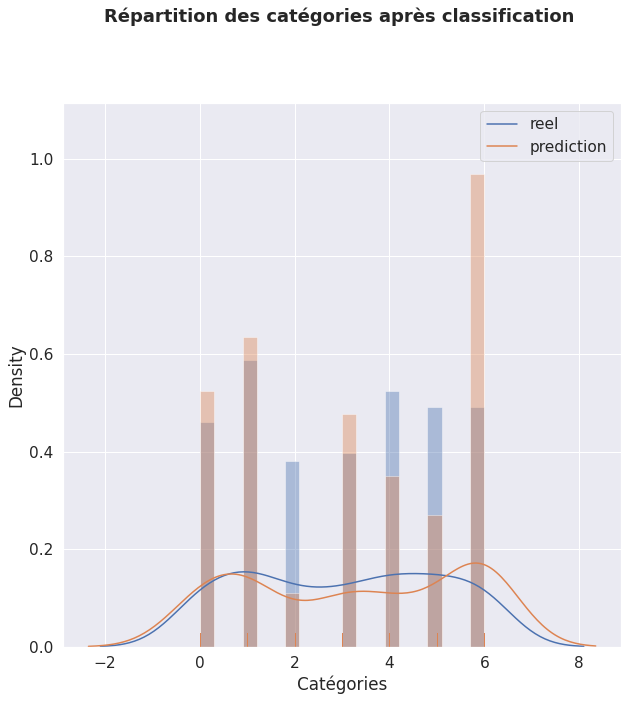

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Répartition des catégories après classification \n \n ',
          fontsize=18, fontweight="bold")
sns.distplot(resume_cnn['label_cat_reel'], bins=20, rug=True)
sns.distplot(resume_cnn['label_cat_predit'], bins=20, rug=True)
plt.xlabel("Catégories")
plt.legend(['reel', 'prediction'])

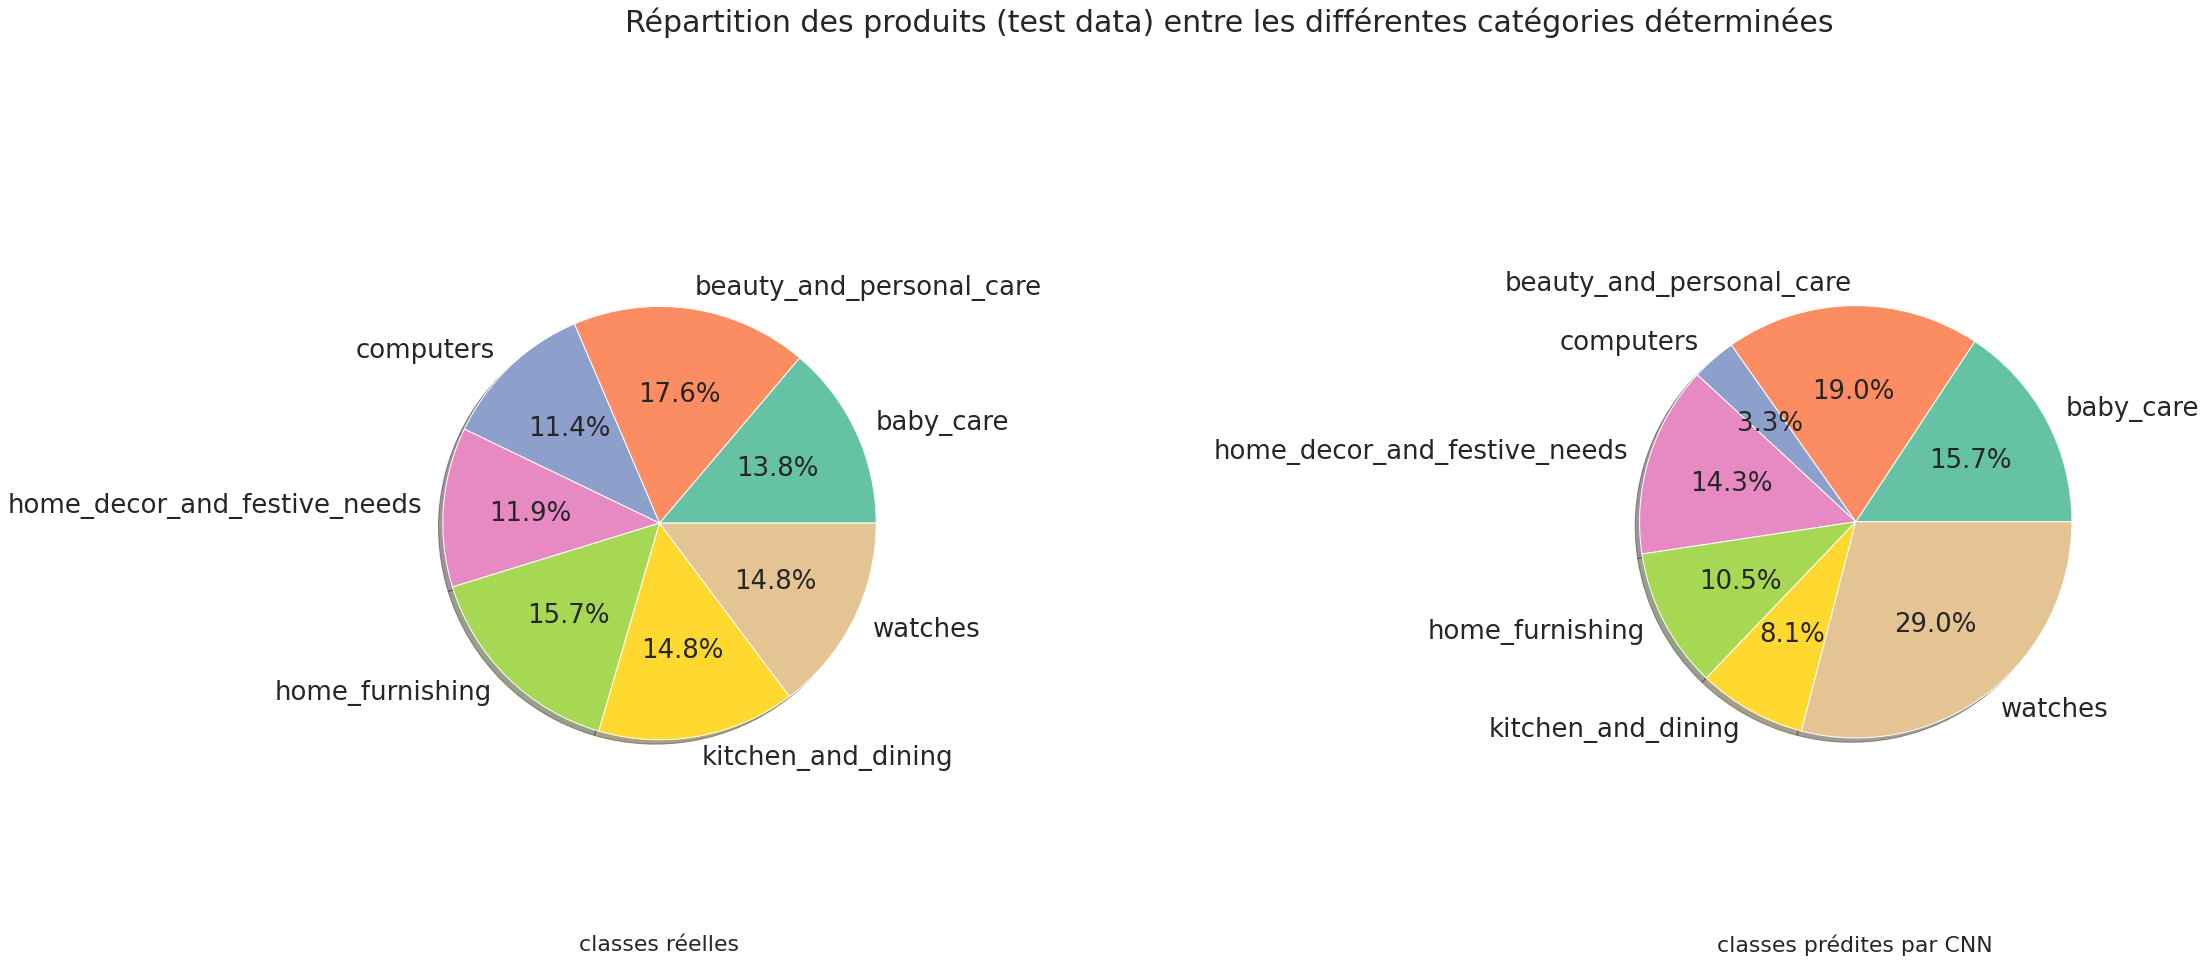

In [ ]:
from matplotlib import cm
fig = plt.figure(figsize=(30, 15))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
nb_label_real = resume_cnn['product_category'].nunique()
cs_nb_label_real = cm.Set2(np.arange(nb_label_real))
nb_label_predit = resume_cnn['predict_category'].nunique()
cs_nb_label_predit = cm.Set2(np.arange(nb_label_predit))

ax1 = resume_cnn.groupby('product_category').count().plot(kind='pie',
                                                          y='label_cat_reel',
                                                          ax=ax1,
                                                          legend=False,
                                                          shadow=True,
                                                          startangle=0,
                                                          autopct='%1.1f%%',
                                                          textprops={
                                                               'fontsize': 26},
                                                          colors=cs_nb_label_real)
ax1.axis('equal')
ax1.set_xlabel("classes réelles", fontsize=22)
ax1.set_ylabel(" ")

ax2 = resume_cnn.groupby('predict_category').count().plot(kind='pie',
                                                          y='label_cat_predit',
                                                          ax=ax2,
                                                          legend=False,
                                                          shadow=True,
                                                          startangle=0,
                                                          autopct='%1.1f%%',
                                                          textprops={
                                                               'fontsize': 26},
                                                          colors=cs_nb_label_predit)
ax2.axis('equal')
ax2.set_xlabel("classes prédites par CNN", fontsize=22)
ax2.set_ylabel(" ")

plt.suptitle('Répartition des produits (test data) entre les différentes catégories déterminées',
             fontsize=30)

plt.subplots_adjust(wspace=1.5)

plt.show()

Les labels des catégories prédites correspondent aux labels des catégories réelles pour les donnéees test. Avec ce graphique, on peut voir que les catégories prédites sont proches de la classification manuelle. On peut voir aussi que pour les catégories 2, 4 et 5, le CNN regroupe moins de produits dans ces catégories par rapport à la réalité. La conclusion inverse peut être faîte pour les catégories 0, 3, 1 et 6.

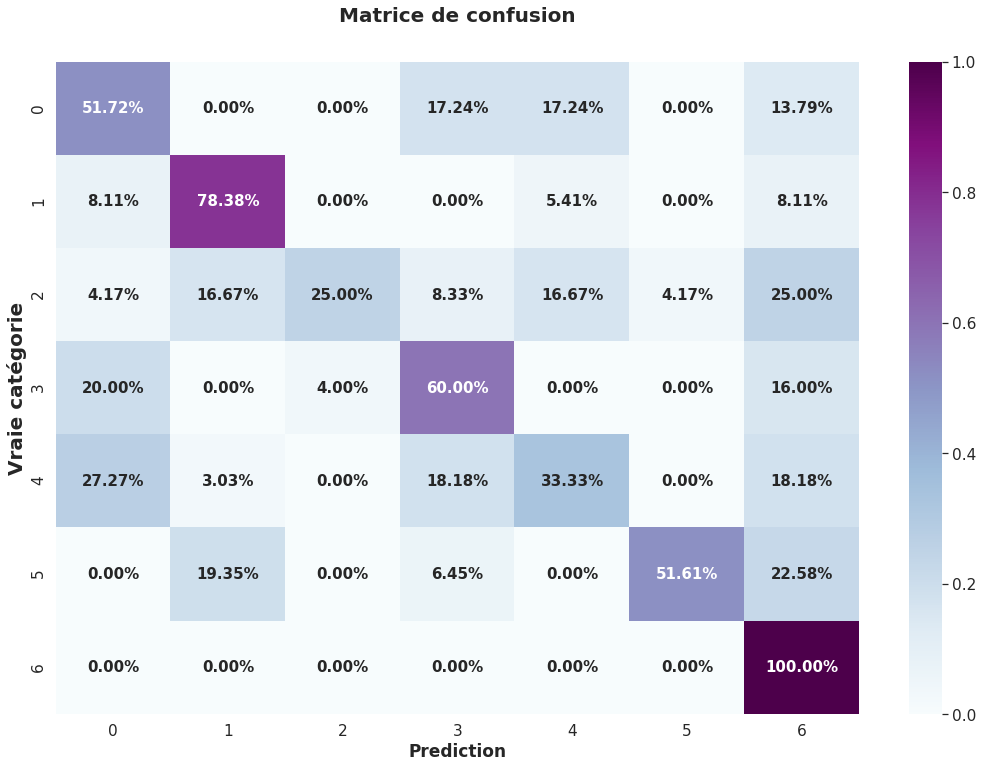

In [ ]:
cf_matrix = confusion_matrix(
    resume_cnn["product_category"], resume_cnn["predict_category"], normalize='true')
plt.figure(figsize=(18, 12))
plt.title('Matrice de confusion', size=20, weight='bold')
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cf_matrix, annot=True,
            fmt='.2%', cmap='BuPu',
            annot_kws={"size": 15, 'weight': 'bold'})
plt.ylabel("Vraie catégorie", weight='bold', size=20)
plt.xlabel('Prediction', weight='bold', size=17)
plt.show()

L'algorithme se trompe surtout sur la prédiction des catégories 2 et 4.

# <font color='green'>Conclusion de cette partie</font>

Le clustering trouve bien des clusters pour séparer les données, il peut également être intéressant de voir l'effet d'une classification.

Les algorithmes les mieux adaptés à nos données pour une classification est l'algorithmes du CNN qui nous donne les meilleurs résultats.

Pour le Clustering, il s'agit de l'algorithme du K-means qui nous donne les meilleurs résultats.

Cependant, on peut dire que le CNN, pour l'extraction de features es imagesest plus performant que la méthode SIFT/ORB. 

# <font color='pink'>Annexe: Classification sans réduction de dimension</font>

### <font color='violet'>Knn classifier</font>

In [ ]:
# GridSearch
# create new a knn model
knn2 = KNeighborsClassifier()

# create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
score = 'accuracy'

# use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

# Fit sur le training set.
knn_gscv.fit(df_visual_word_Xtrain, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
best_param = knn_gscv.best_estimator_
print("Best paramètres: {}".format(best_param))

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
    knn_gscv.cv_results_['mean_test_score'],  # score moyen
    knn_gscv.cv_results_['std_test_score'],  # écart-type du score
    knn_gscv.cv_results_['params']           # valeur de l'hyperparamètre
):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ))

Best paramètres: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Résultats de la validation croisée :
accuracy = 0.137 (+/-0.048) for {'n_neighbors': 1}
accuracy = 0.145 (+/-0.045) for {'n_neighbors': 2}
accuracy = 0.162 (+/-0.043) for {'n_neighbors': 3}
accuracy = 0.155 (+/-0.036) for {'n_neighbors': 4}
accuracy = 0.156 (+/-0.068) for {'n_neighbors': 5}
accuracy = 0.148 (+/-0.049) for {'n_neighbors': 6}
accuracy = 0.162 (+/-0.036) for {'n_neighbors': 7}
accuracy = 0.145 (+/-0.026) for {'n_neighbors': 8}
accuracy = 0.137 (+/-0.029) for {'n_neighbors': 9}
accuracy = 0.139 (+/-0.034) for {'n_neighbors': 10}
accuracy = 0.151 (+/-0.040) for {'n_neighbors': 11}
accuracy = 0.154 (+/-0.037) for {'n_neighbors': 12}
accuracy = 0.145 (+/-0.032) for {'n_neighbors': 13}
accuracy = 0.129 (+/-0.028) for {'n_neighbors': 14}
accuracy = 0.124 (+/-0.030) for {'n_neig

In [ ]:
best_param = KNeighborsClassifier()

Exécution 
 
Qualité de la classification 
 
 
L'accuracy score est de 0.13333333333333333 pour la méthode knn.
 
 
Le score de précision est de 0.14214705080298642 pour la méthode knn.
 
 
Le score recall est de 0.13333333333333333 pour la méthode knn.
 
 
Le score f1 est de 0.11427738894086213 pour la méthode knn.
 
 
Visualisation 
 
 


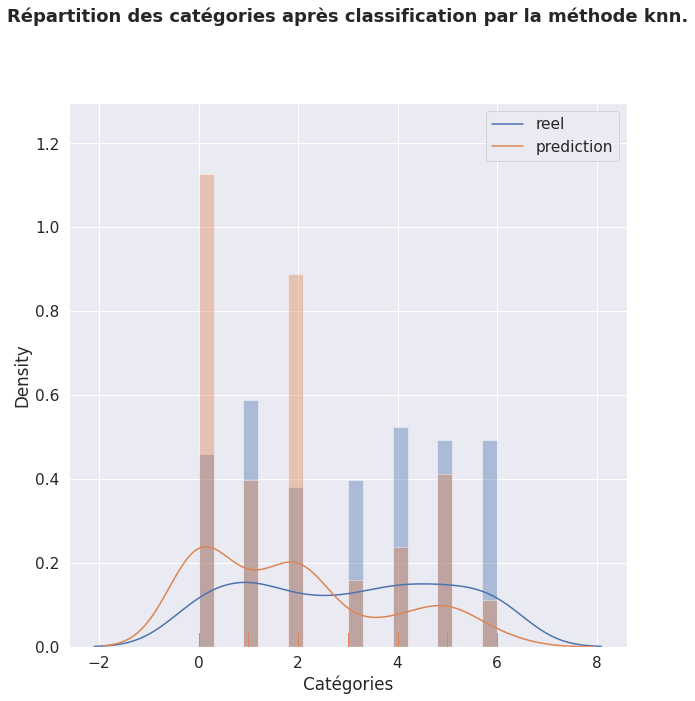

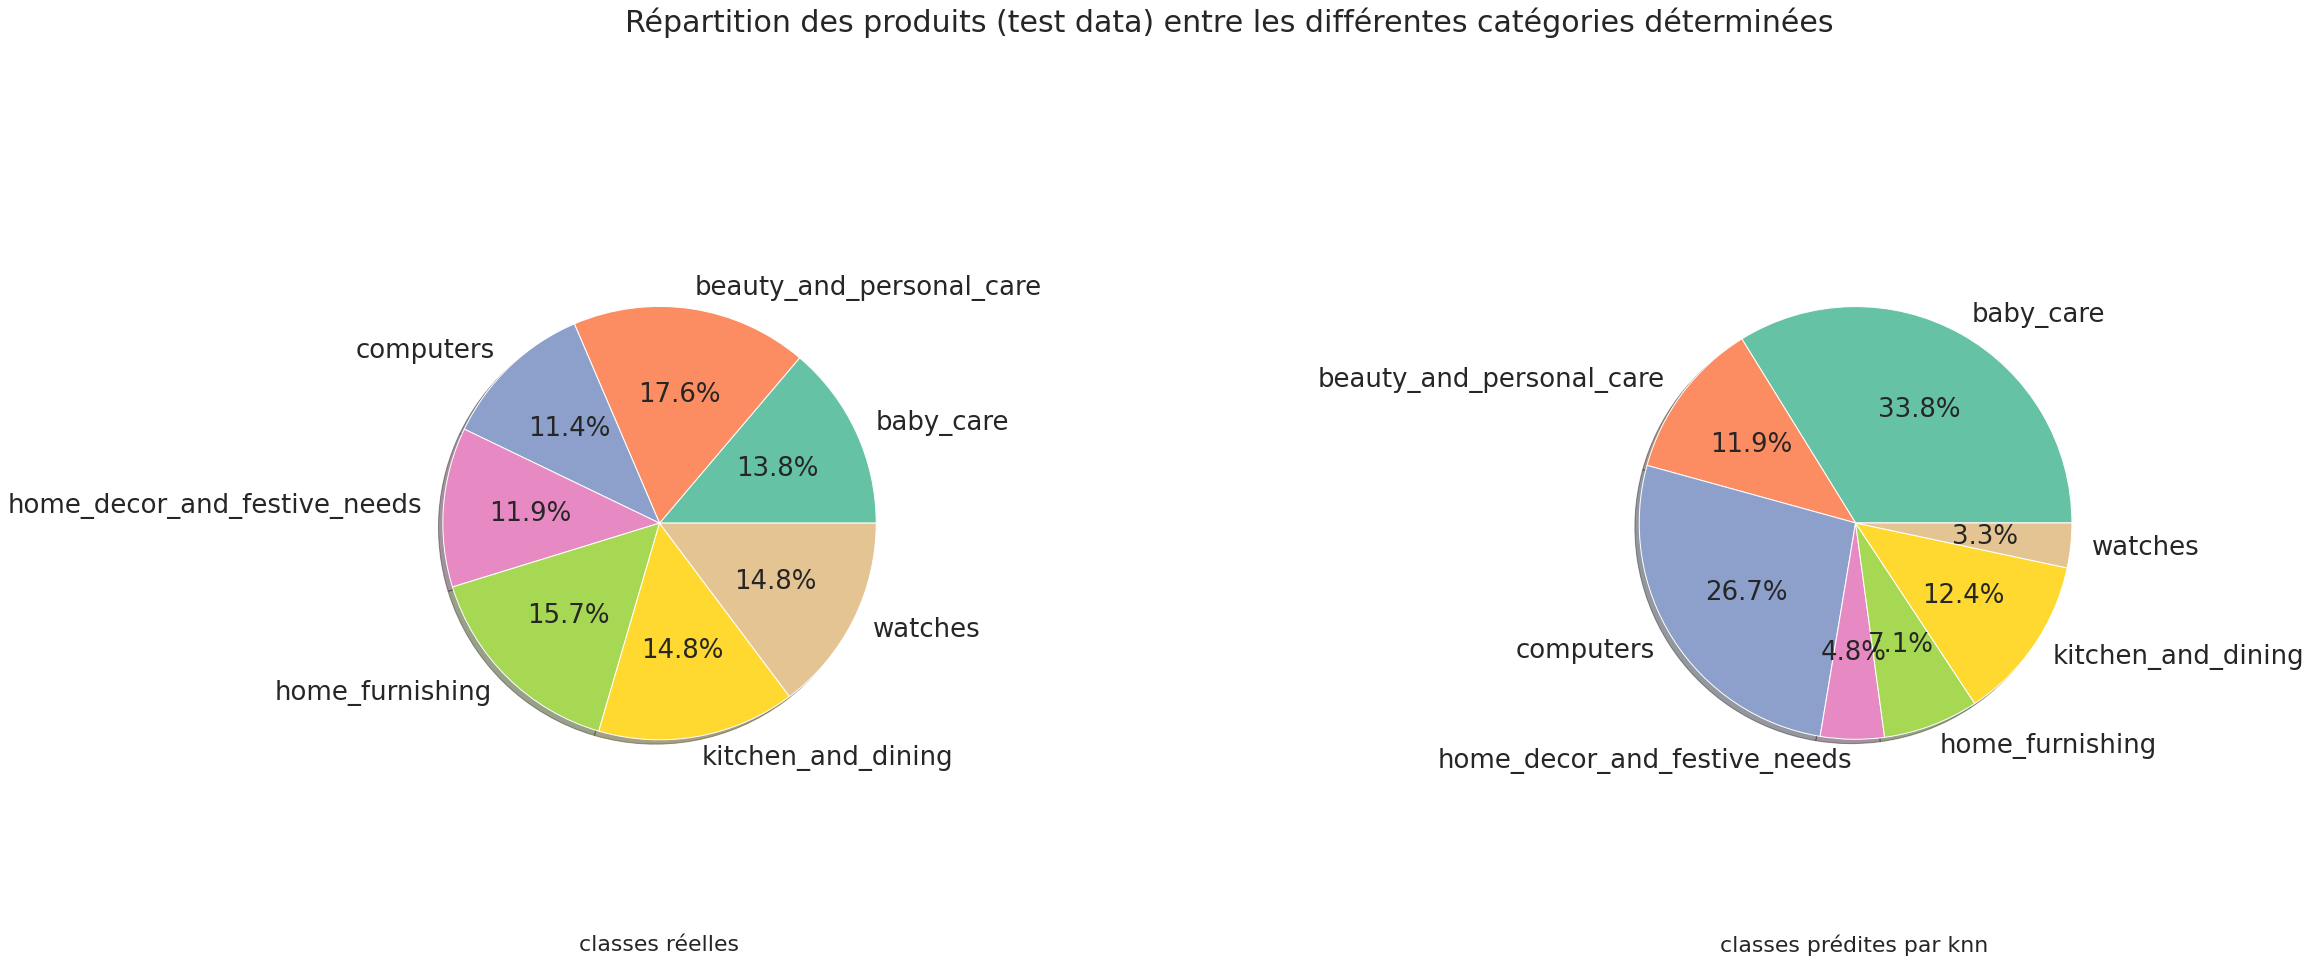

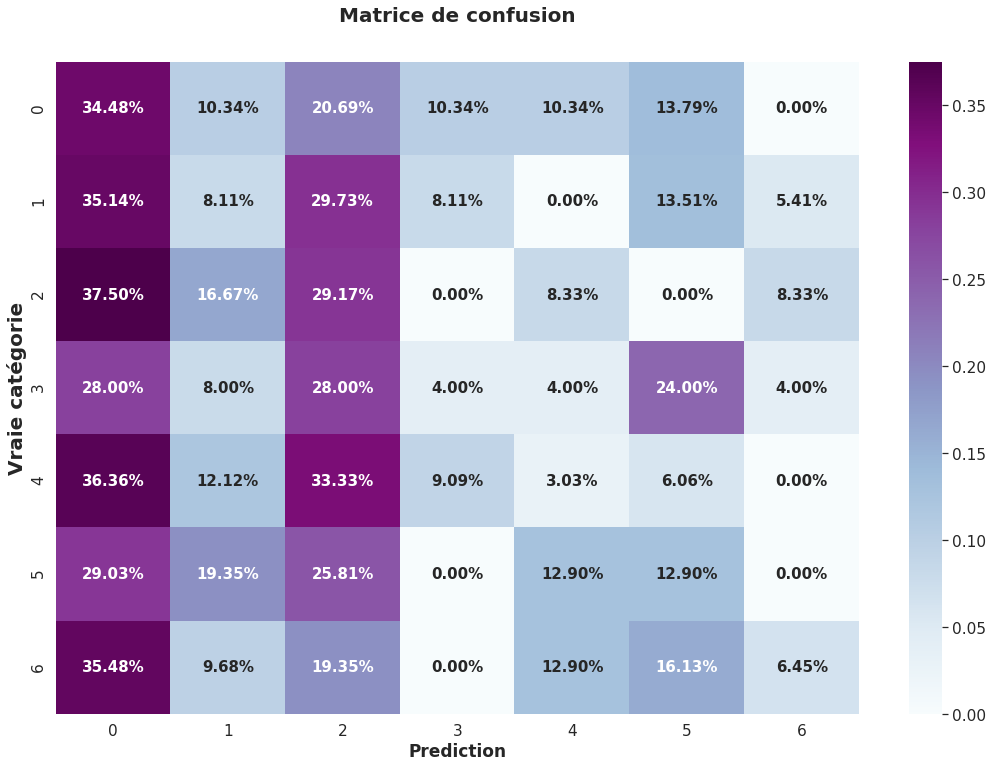

In [ ]:
accuracy, precision, recall, f1, resume_class = classification(
    best_param, df_visual_word_Xtrain, y_train, df_visual_word_Xtest, y_test, 'knn')

Ici le score d'accuracy est de 0.13 ce qui montre que la classification fonctionne très mal.

Ici le score de précision est de 0.12 montre que la prédiction est très peu précise car le score est proche de 0.

Ici le score de recall est de 0.13 montre que la prédiction ne fait pas en majorité des vrais positifs car le score est proche de 0.

Les labels des catégories prédites correspondent aux labels des catégories réelles pour les donnéees test. On peut voir  que pour les catégories 1, 2, 3, 4 et 6, la classification regroupe moins de produits dans ces catégories par rapport à la réalité. La conclusion inverse peut être faîte pour les catégories 0 et 5.

Les produits se regroupe surtout dans les catégories 0 et 5

In [ ]:
classification_resume_sans_pca = pd.DataFrame({})

classification_resume_sans_pca = classification_resume_sans_pca.append(
    pd.DataFrame(
        {
            "Algorithme": "knn",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        },
        index=[0],
    )
)

In [ ]:
classification_resume_sans_pca

Algorithme  accuracy  precision    recall  f1_score
0        knn  0.133333   0.142147  0.133333  0.114277

### <font color='violet'>Random Forest</font>

In [ ]:
# GridSearch
param_grid = [{'max_depth': range(2, 10, 2)}]
gridSearch = GridSearchCV(RandomForestClassifier(),
                          param_grid, cv=5, scoring='accuracy')
score = 'accuracy'


# Fit sur le training set.
gridSearch.fit(df_visual_word_Xtrain, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
best_param = gridSearch.best_estimator_
print("Best paramètres: {}".format(best_param))

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
    gridSearch.cv_results_['mean_test_score'],  # score moyen
    gridSearch.cv_results_['std_test_score'],  # écart-type du score
    gridSearch.cv_results_['params']           # valeur de l'hyperparamètre
):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ))

Best paramètres: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Résultats de la validation croisée :
accuracy = 0.155 (+/-0.064) for {'max_depth': 2}
accuracy = 0.140 (+/-0.055) for {'max_depth': 4}
accuracy = 0.136 (+/-0.040) for {'max_depth': 6}
accuracy = 0.139 (+/-0.014) for {'max_depth': 8}


In [ ]:
best_param = RandomForestClassifier(random_state=40)

Exécution 
 
Qualité de la classification 
 
 
L'accuracy score est de 0.12380952380952381 pour la méthode Random Forest.
 
 
Le score de précision est de 0.11465623584132631 pour la méthode Random Forest.
 
 
Le score recall est de 0.12380952380952381 pour la méthode Random Forest.
 
 
Le score f1 est de 0.1150783779090297 pour la méthode Random Forest.
 
 
Visualisation 
 
 


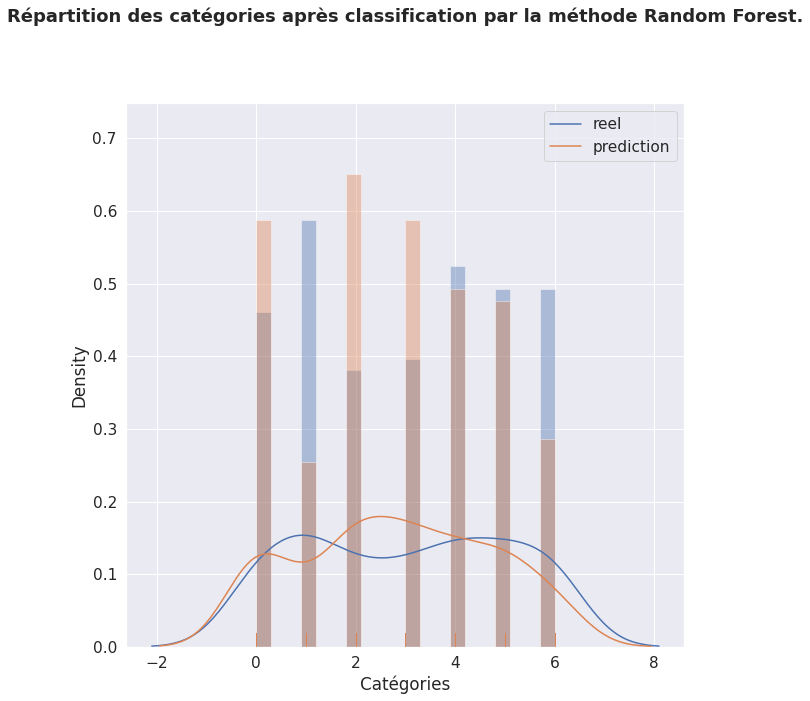

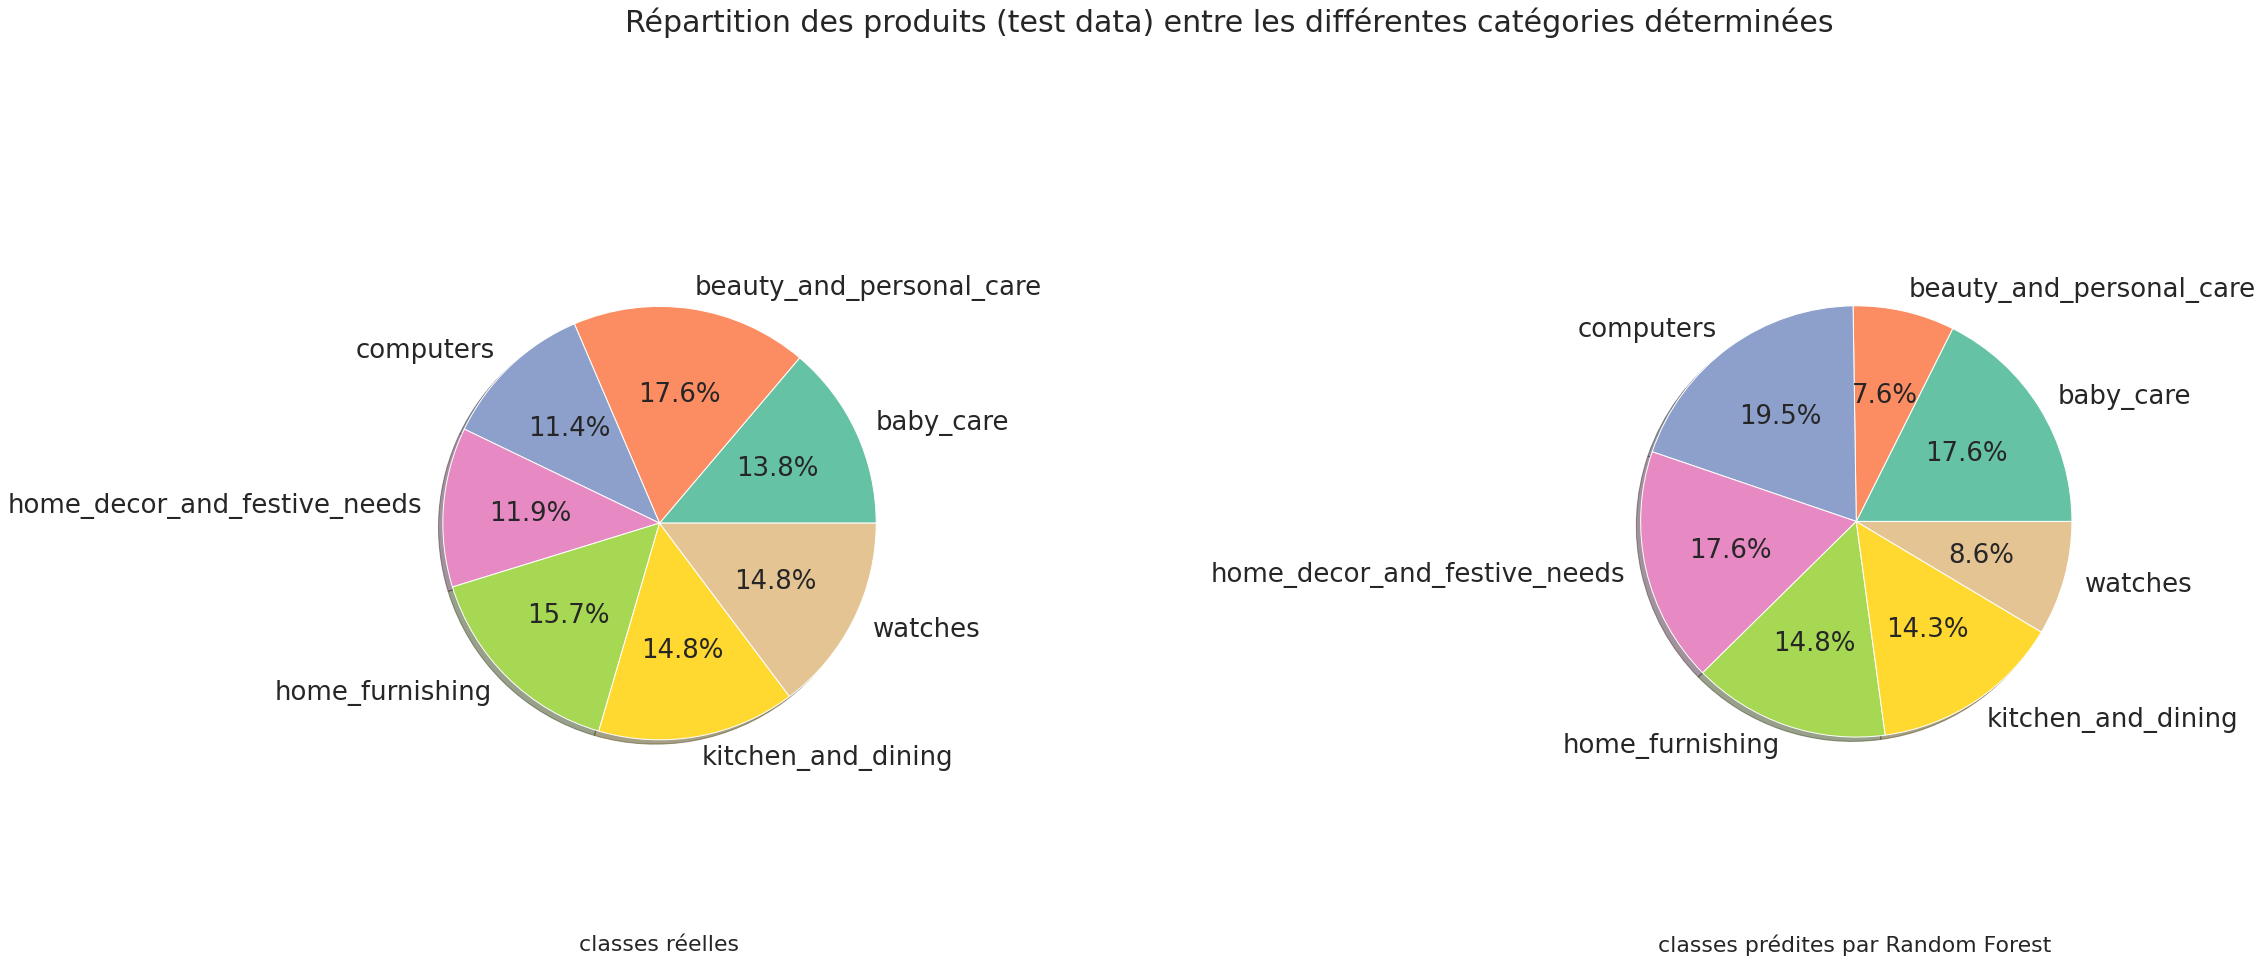

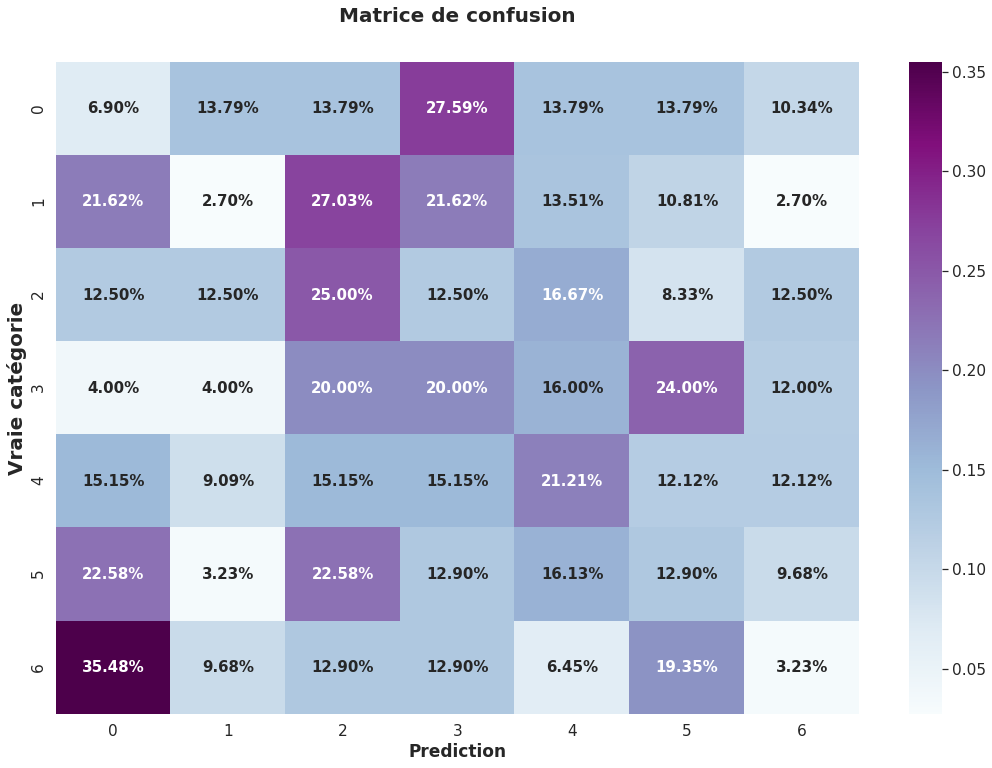

In [ ]:
accuracy, precision, recall, f1, resume_class = classification(
    best_param, df_visual_word_Xtrain, y_train, df_visual_word_Xtest, y_test, 'Random Forest')

Ici le score d'accuracy est de 0.15 ce qui montre que la classification fonctionne mal.

Ici le score de précision est de 0.15 montre que la prédiction est peu précise car le score est proche de 1.

Ici le score de recall est de 0.15 montre que la prédiction ne fait pas en majorité des vrais positifs car le score est proche de 0.

Les labels des catégories prédites correspondent aux labels des catégories réelles pour les donnéees test. Avec ce graphique, on peut voir que les catégories prédites sont proches de la classification manuelle. On peut voir aussi que pour les catégories 1, 4, 5 et 6 la classification regroupe moins de produits dans ces catégorie par rapport à la réalité. La conclusion inverse peut être faîte pour les catégories 0, 2 et 3.

L'algorithme se trompe sur toutes les prédictions. L'attribution d'une classe est donc dûe au hasard.

In [ ]:
classification_resume_sans_pca = classification_resume_sans_pca.append(
    pd.DataFrame(
        {
            "Algorithme": "Random Forest",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        },
        index=[1],
    )
)

In [ ]:
classification_resume_sans_pca

Algorithme  accuracy  precision    recall  f1_score
0            knn  0.133333   0.142147  0.133333  0.114277
1  Random Forest  0.123810   0.114656  0.123810  0.115078